# Setup

In [ ]:
!pip install pykalman
!pip install nbformat==4.4.0
!pip install 'plotly ==4.8.1'
!pip install dtw-python
%load_ext google.colab.data_table
# %unload_ext google.colab.data_table
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path = "/content/drive/My Drive/"

     |████████████████████████████████| 235kB 3.5MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp36-none-any.whl size=48464 sha256=22a576331ebe9e4abc1aa8e28c1cb95fc8482b2b87279133ec4942e3cd7912eb
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman
     |████████████████████████████████| 163kB 5.0MB/s 
  Found existing installation: nbformat 5.0.7
    Uninstalling nbformat-5.0.7:
      Successfully uninstalled nbformat-5.0.7
     |████████████████████████████████| 11.5MB 3.9MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 583kB 4.2MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%

In [ ]:

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import bisect
import math
# from dtw import *
import glob
import sys
import json
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from pykalman import KalmanFilter
import os
from scipy.signal import savgol_filter
from sklearn.utils import shuffle

sns.set(rc={'figure.figsize':(40, 15)})
pd.options.plotting.backend = "plotly"
# path = ""
path = "/content/drive/My Drive/"
path_jj = os.path.join(path, "Datasets", "Data_jj")
path_bm = os.path.join(path, "Datasets","Data_bm")



# Working with Jain Dataset

## Utility Functions

In [ ]:
def add_freq(df):
    """
    Adds time offset based on number of readings at each second
    Input:
    ====== 
    df: Sensor dataset 

 
    Output
    ======
    df: DataFrame with offset added to timestamp value
    
    """

    offsets = np.array([])
    # Creating offsets for each time value
    for freq in df.groupby("timestamp").count()['x']:
        offsets = np.append(offsets,np.linspace(0,1,freq))
    df["offset"] = offsets
    # Converting offsets to datetime format to allow addition to timestamp 
    df["offset"] = df.offset.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x))
    # Adding offset to timestamp value
    df["timestamp"] = df["timestamp"] + df["offset"]
    df = df.drop('offset',axis=1)
    return df


# This function creates "frames" by default
def convert_to_timeseries(df,offset = False):
    """
    Converts sensor dataframe to timeseries data. Each second represents a frame.
    """
    if 'timestamp' in df:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        if offset:
            df = add_freq(df)
        df = df.set_index('timestamp')
    return df

def preprocess_truth(df,time,keepNA = True):
    """
    Removes additional data from the "Truth" Dataframe and adds offset to Start time to align it with Actual trip time
    Input:
    ======
    df: Ground truth dataframe
    time: Start time of the trip
    keepNA: Boolean telling if Non Aggressive maneuvers should be removed or not
    
    Output
    ======
    maneuvers: DataFrame containing maneuvers and their actual start times.
    
    """

    # Removes Non-Aggressive maneuvers from the dataset
    maneuvers = df[df["Event"] != "Non-aggressive event"].iloc[:,:2]
    
    if keepNA:
        maneuvers = df.copy()

    maneuvers["Start"] = maneuvers["Start"].apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)  + time)
    maneuvers["End"] = maneuvers.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)) + time
    maneuvers = maneuvers.reset_index(drop =True)
    return maneuvers



def get_trip_duration(df):
    """
    Input:
    =======
    df: Sensor dataframe
    
    Output
    ======
    Duration of trip
    """
    return df.index.max()- df.index.min()

def create_time_segments(df,nf):
    """
    Input:
    ======
    Used for eftekhari dataset
    df: Sensor dataframe e.g. accel, gyro, magnet
    nf: number of frames that make up a time segement
    
    Output
    ======
    windows: A dictionary with i mapped to list of timestamps(frames) that make up the ith segment.
             Number of windows = total frames - nf + 1
    """
    
    # Each timestamp represents one frame
    frames = df.index.unique()
    windows = {}
    
    # Number of frames in a trip
    total_frames = len(frames)
    
    for i in range(0,total_frames - nf + 1,2):
        
        # maps window i to the list of frames that make up the ith window
        windows[i] = frames[i:i+nf]    
        
        # reverses the order of the list so that frame of the current second i.e. last timestamp is represented by 0th frame.
        # windows[i] = windows[i][::-1]
    return windows


def create_time_windows(df,nf):
    """
    Input:
    ======
    df: Sensor dataframe e.g. accel, gyro, magnet
    nf: number of frames that make up a time window
    
    Output
    ======
    windows: A dictionary with i mapped to list of timestamps(frames) that make up the ith window.
             Number of windows = total frames - nf + 1
    """
    
    # Each timestamp represents one frame
    frames = df.index.unique()
    windows = {}
    f = 0
    # Number of frames in a trip
    total_frames = len(frames)
    
    for i in range(total_frames - nf + 1):

        # If there are multiple trips in the dataset
        if (frames[i+nf-1] - frames[i]).seconds ==( nf-1):
            # maps window i to the list of frames that make up the ith window
            windows[f] = frames[i:i+nf]    
            f+=1
            
        # reverses the order of the list so that frame of the current second i.e. last timestamp is represented by 0th frame.
        # windows[i] = windows[i][::-1]
    return windows

    
def create_attribute_dict(sensor_axis,window):
    """
    Input:
    ======
    sensor_axis: Series of sensor's axis from which attributes will be calculated.e.g. accel['x'] or accel['y']
    window: Time window for which the attributes will be calculated
    
    Output
    ======
    attribute_dict: A dictionary with keys  "mean, median, std, tendency" mapped to lists containing the respective
                    quantities, calculated for each frame in the window as described by the following paper:
                    https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0174959.
    """
    
    attribute_dict = {}
    for i in range(1,len(window)+1):
        
        # Calculates quantities for the frame of current second
        if i == 1:
            attribute_dict["mean"] =[sensor_axis.loc[window[:i]].mean()]
            attribute_dict["median"] = [sensor_axis.loc[window[:i]].median()]
            attribute_dict["std"] = [sensor_axis.loc[window[:i]].std()]
            attribute_dict["tendency"] = []
        
        # Calculates quantities for the remaining frames
        else:
            attribute_dict["mean"].append(sensor_axis.loc[window[:i]].mean())
            attribute_dict["median"].append(sensor_axis.loc[window[:i]].median())
            attribute_dict["std"].append(sensor_axis.loc[window[:i]].std())
            attribute_dict["tendency"].append(sensor_axis.loc[window[i-1]].mean()/attribute_dict["mean"][0])
            
    return attribute_dict

def create_attribute_vector(attribute_dict):
    """
    Input:
    ======
    attribute_dict: Dictionary containing attributes to be converted to vector
    
    Output
    ======
    attribute_vector: attribute vector for a single axis of sensor data
    """
    vector = []
    for i in attribute_dict.values():
        vector.extend(i)
    return vector

def time_in_range(t,frame_list):
    """
    Returns true if t lies in the the time time window defined by the frame_list
    Input:
    ======
    t: Timestamp to be checked
    frame_list: list of frmes
    
    Output
    ======
    True, If timestamp is in the range, False otherwise
    """
    if t>=frame_list.min() and t<=frame_list.max():
        return True
    return False

def savgol(sensor, window_length = 51, polyorder = 2 ):
    """
    This applies savgol filter to sensor data, inplace
    ======
    sensor: sensor to be normalized
    window_length: Set as 51 after rigourous testing
    polyorder: set as 2
    optimal values for gyro are 31,3
    """
    sensor['x'] = savgol_filter(sensor['x'].values, window_length, polyorder)
    sensor['y'] = savgol_filter(sensor['y'].values, window_length, polyorder)
    sensor['z'] = savgol_filter(sensor['z'].values, window_length, polyorder)


def df_to_sensor(df_sensor):
    """
    Input:
    =======
    df_sensor: Sensor dataframe
    
    Output
    ======
    Sensor object containing all data
    """
    temp = Sensor()
    temp.x = list(df_sensor["x"])
    temp.y = list(df_sensor["y"])
    temp.z = list(df_sensor["z"])
    temp.time = list(pd.to_datetime(df_sensor['uptimeNanos'].astype(float)/1e9, unit='s').apply(lambda x: x.strftime('%H:%M:%S.%f')))
    temp.t = [to_exceltime(t) for t in temp.time]
    return temp

# We will run this for each group and then assign that label + window time for the maneuver"
def classification_output(df):
    return df[0].groupby("timestamp").apply(lambda x:x.maneuver.mode())

## Functions that work on one sensor at a time

In [ ]:
def process_sensor(df_sensor, df_truth, nf = 3, axis_list = ['x'], ours = False, window_len = 31, polyorder = 4):
    """
    Assumes that at any given time, there is only one event/maneuver happening at max.
    Input:
    ======
    df_sensor: Dataframe containing sensor data e.g. accel, gyro, magnet
    df_truth: Dataframe containing ground truth label
    nf: Number of frames that make up the time window
    axis_list: list of axis that will be used for classification e.g. ['x'] or ['x','y','z']
    
    Output
    ======
    processed: list of tuples of the form (vectors,label,timestamp) where vectors is a dictionary with 
                axis name as key and attribute vector as value; and timestamp is the start time of the maneuver
    """
    df_sensor = convert_to_timeseries(df_sensor)
    # Start time of trip to adjust "Start" Column in ground truth table
    start_time = df_sensor.index.min()
    # Removing non-aggressive events from the table and adjusting Start time 

    if not ours: 
        df_sensor['x'] = savgol_filter(df_sensor.x,window_len, polyorder)
        df_sensor['y'] = savgol_filter(df_sensor.y, window_len, polyorder)
        df_sensor['z'] = savgol_filter(df_sensor.z, window_len, polyorder)
        df_truth = preprocess_truth(df_truth,start_time)
    
    # creating Sliding windows
    windows = create_time_windows(df_sensor,nf)
    
    
    processed = []
    
    # Tracks number of maneuvers identified
    i=0
    found = False
    
    for window, frames in windows.items():
        
        # Checks if any maneuver occurs in the time window
        if time_in_range(df_truth["Start"][i],frames):
            found = True
            attr_vectors = {}
            
            # Calculates attributes for each axis of the sensor
            for axis in axis_list:
                attr_dict = create_attribute_dict(df_sensor[axis],frames)
                attr_vectors[axis] = create_attribute_vector(attr_dict)
            
            label = df_truth["Event"][i]
            processed.append((attr_vectors,label,df_truth["Start"][i]))
        # Returns the list if all maneuvers in the trip have been identified. Otherwise starts looking for next maneuver
        else:
            if found and len(df_truth) == i+1:
                return processed
            elif found:
                i += 1
                found = False               
    return processed

def create_dataframe(processed_sensor, nf, axis_list = ["x","y","z"], tripid = "Waymore"):
    """
    This creates the dataframe that we will be using to train out model
    Input:
    ======
    processed_sensor: list of tuples from process_sensor function
    nf: Number of frames that make up the time window
    axis_list: list of axis that will be used for classification e.g. ['x'] or ['x','y','z']
    
    Output
    ======
    df: Dataframe containing attribute vectors in each row along with their respective labels
    """

    # Creating list skeleton for column names
    m = ["M{}".format(i) for i in range(nf)]
    md = ["MD{}".format(i) for i in range(nf)]
    std = ["SD{}".format(i) for i in range(nf)]
    t = ["T{}".format(i) for i in range(1,nf)]
    
    # Adjusts column names w.r.t axis
    col_names = m+md+std+t
    col_names = ["{}_{}".format(attrib,axis) for axis in axis_list for attrib in col_names]
    
    # Initializing data array and maneuver list
    data = np.array(list(processed_sensor[0][0].values())).ravel().reshape(1,-1)
    maneuver = [processed_sensor[0][1]]
    timestamp = [processed_sensor[0][2]]
    
    for vector,label,start_time in processed_sensor[1:]:
        row = np.array(list(vector.values())).ravel().reshape(1,-1)
        data = np.append(data,row,axis=0)
        maneuver.append(label)
        timestamp.append(start_time)
    df = pd.DataFrame(data = data,columns=col_names)
    df['maneuver'] = maneuver
    df['timestamp'] = timestamp

    # if tripid == "":
    #     # Re-arranging columns
    #     cols = df.columns.tolist()
    #     cols = cols[-1:] + cols[:-1]
    #     df = df[cols]
    # else:
    df["tripid"] = tripid
    cols = df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df = df[cols]
    return df




## Main Preprocessing Function




In [ ]:

l = process_path(16)
l[1].head(10).iloc[:,[0,1,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]]

Trip lasted for 0 days 00:21:09


timestamp tripid  ...        T2_z               maneuver
0 2016-05-14 10:54:35.000     16  ...    7.644251   Non-aggressive event
1 2016-05-14 10:54:35.000     16  ...    8.647467   Non-aggressive event
2 2016-05-14 10:54:35.000     16  ...   -1.162291   Non-aggressive event
3 2016-05-14 10:54:52.500     16  ...   14.311422  Aggressive right turn
4 2016-05-14 10:54:52.500     16  ...   42.304673  Aggressive right turn
5 2016-05-14 10:55:03.000     16  ...    0.838308   Non-aggressive event
6 2016-05-14 10:55:03.000     16  ...   -1.532151   Non-aggressive event
7 2016-05-14 10:55:03.000     16  ...   -8.577675   Non-aggressive event
8 2016-05-14 10:56:08.000     16  ...   43.455208  Aggressive right turn
9 2016-05-14 10:56:08.000     16  ... -458.885002  Aggressive right turn

[10 rows x 14 columns]

In [ ]:

def process_path(source_path, nf =3, axis_list = ["x","y","z"], export = False):
    """
    Generates dataframes for each trip that contain classified attribute vectors for each sensor
    Input:
    ======
    source_path: folder number
    nf: Number of frames that make up the time window
    axis_list: list of axis that will be used for classification e.g. ['x'] or ['x','y','z']
    export: Flag that if True, exports dataframes to processed.xlsx
    

    Output
    ======
    list of Dataframes corresponding to each Sensor
    
    Sample Usages:
    ==============
    process_path(16,export=True)
    process_path(16, nf=4, axis_list = ['x','y','z'], export=True)
       
    """    
    # lin_accel and accel differ only in z values
    linaccel = pd.read_csv(os.path.join(path_jj, str(source_path), "aceleracaoLinear_terra.csv"))
    
    # Sensor data sampled at 51Hz
    accel = pd.read_csv(os.path.join( path_jj, str(source_path), "acelerometro_terra.csv"))
    gyro = pd.read_csv(os.path.join( path_jj, str(source_path), "giroscopio_terra.csv"))
    # Sensor data sampled at 102Hz
    magnet = pd.read_csv(os.path.join( path_jj, str(source_path), "campoMagnetico_terra.csv"))
    
    # True event labels with start and finish time (seconds).
    truth = pd.read_csv(os.path.join( path_jj, str(source_path), "groundTruth.csv"))
    
    # Translating event labels from Portoguese to English
    portu_to_english = {'evento_nao_agressivo':'Non-aggressive event','troca_faixa_esquerda_agressiva': 
                        'Aggressive left lane change','aceleracao_agressiva':'Aggressive acceleration',
                        'freada_agressiva':'Aggressive breaking','curva_esquerda_agressiva':'Aggressive left turn',
                        'curva_direita_agressiva':'Aggressive right turn','troca_faixa_direita_agressiva':
                        'Aggressive right lane change'}

    truth['evento'] = [portu_to_english[x] for x in truth['evento']]
    truth.columns = ["Event", "Start", "End"]
    
    print("Trip lasted for", get_trip_duration(convert_to_timeseries(magnet)))
    tid = str(source_path)

    # Creating Dataframes consisting of attribute vectors and labels to train our model
    accel_processed = process_sensor(accel, truth, nf, axis_list)
    df_accel = create_dataframe(accel_processed, nf, axis_list,tid)    
    gyro_processed = process_sensor(gyro, truth, nf, axis_list)
    df_gyro = create_dataframe(gyro_processed, nf, axis_list,tid)  
    
    # magnet_processed = process_sensor(magnet, truth, nf, axis_list)
    # df_magnet = create_dataframe(magnet_processed, nf, axis_list)  
    # linaccel_processed = process_sensor(linaccel, truth, nf, axis_list)
    # df_linaccel = create_dataframe(linaccel_processed, nf, axis_list)  
 
    dest_path = os.path.join( path_jj, str(source_path), f"jj_{source_path}_{nf}_processed.xlsx")

    # Exports dataframes to processed.xlsx file
    if export:
        with pd.ExcelWriter(dest_path) as writer:
            df_accel.to_excel(writer, sheet_name = 'Acclerometer')
            # df_linaccel.to_excel(writer, sheet_name = 'Linear_Acceleration')
            df_gyro.to_excel(writer, sheet_name = 'Gyroscope')
            # df_magnet.to_excel(writer, sheet_name = 'Magnetometer')
            truth.to_excel(writer, sheet_name = 'Events')

    # return [df_accel,df_magnet,df_gyro,df_linaccel]
            
    return [df_accel,df_gyro]

def process_paths(source_paths, nf = 3):
    """
    Generates dataframes for each trip that contain classified attribute vectors for each sensor
    Input:
    ======
    source_paths: list of folder numbers
    nf: Number of frames that make up the time window    

    Output
    ======
    list of processed Dataframes corresponding to each Accel, Gyro and Gyro_z
    
    Sample Usages:
    ==============
    process_path([16,17] , nf = 4)
       
    """ 
    df_accel = None
    df_gyro = None
    initialized = False
    for path in source_paths:
        temp = process_path(path, nf)
        if not initialized:
            df_accel = temp[0]
            df_gyro = temp[1]
            initialized = True
        else:
            df_accel = pd.concat([df_accel, temp[0]], ignore_index= True)
            df_gyro = pd.concat([df_gyro, temp[1]], ignore_index= True)

    # # Concatenating all data 
    # a = pd.concat([d1[0],d2[0],d3[0],d4[0]],ignore_index=True)
    # g = pd.concat([d1[1],d2[1],d3[1],d4[1]],ignore_index=True)

    # Dropping x,y axis columns from gyroscope data data
    drop_cols = [i for i in df_gyro.columns if 'x' in i or 'y' in i]
    df_gyroz = df_gyro.drop(columns = drop_cols)

    # Combining accel and gyro
    df_combined = df_gyro.copy()
    df_temp = df_accel.copy()

    for i in range(2, len(df_accel.columns) - 1):
        df_temp.rename(columns = {df_accel.columns[i]:'a' + df_accel.columns[i]},inplace = True)
        df_combined.rename(columns = {df_gyro.columns[i]:'g' + df_gyro.columns[i]}, inplace = True)
        df_combined.insert(i, df_temp.columns[i], df_accel.iloc[:,i])
                
    dest_path = os.path.join( path_jj, f"jj_{nf}_processed.xlsx")
    with pd.ExcelWriter(dest_path) as writer:
            df_combined.to_excel(writer, sheet_name = 'Combined')
            df_accel.to_excel(writer, sheet_name = 'Acclerometer')
            df_gyro.to_excel(writer, sheet_name = 'Gyroscope')
            df_gyroz.to_excel(writer, sheet_name = 'Gyroscope_z')
    return df_combined, df_accel, df_gyro, df_gyroz

## Generating Processed Data CSV

This is an extremely computational task and doesn't need to be run again as we have already processed all the datasets available from Jain Jr

In [ ]:
def create_all_jain():
    """Creates data files for all trips in Jain JR Dataset"""
    days = []
    # gets folder names from jj_path
    with os.scandir(path_jj) as entries:
        for entry in entries:
            if entry.is_dir():
                days.append(entry.name)
    # Creates data files for different nf values            
    for nf in range(3,9):
        print(f"Creating Dataset for window size {nf}")
        process_paths(days, nf)

# create_all_jain()

# Working with BM Dataset

## Sensor Class

In [ ]:
class Sensor:

    def __init__(self, imu = True):
        self.imu = imu
        if self.imu:
            self.x = []
            self.y = []
            self.z = []
        else:
            self.speed = []
            self.time = []
            self.t = []
            self.lon =[]
            self.lat = []
            self.alt = []
            self.accuracy = []
            self.course = []
            self.dist = []
                        

        # t is in excel time and time is in datetime.
        self.t = []
        self.time = []

    def get_len(self):
        return len(self.t)

    def plot(self,segment = []):
        if segment ==[]:
            if self.imu:
                plt.plot(self.t,self.x)
                plt.plot(self.t,self.y)
                plt.plot(self.t,self.z)
                plt.legend(["x","y","z"])

            else:
                plt.plot(self.t,self.speed)
                plt.legend(["speed"])
        elif len(segment) == 1:
            if self.imu:
                plt.plot(self.t[:segment[0]],self.x[:segment[0]])
                plt.plot(self.t[:segment[0]],self.y[:segment[0]])
                plt.plot(self.t[:segment[0]],self.z[:segment[0]])
                plt.legend(["x","y","z"])

            else:
                plt.plot(self.t[:segment[0]],self.speed[:segment[0]])
                plt.legend(["speed"])

        else:
            
            if self.imu:
                plt.plot(self.t[segment[0]:segment[1]],self.x[segment[0]:segment[1]])
                plt.plot(self.t[segment[0]:segment[1]],self.y[segment[0]:segment[1]])
                plt.plot(self.t[segment[0]:segment[1]],self.z[segment[0]:segment[1]])
                plt.legend(["x","y","z"])

            else:
                plt.plot(self.t[segment[0]:segment[1]],self.speed[segment[0]:segment[1]])
                plt.legend(["speed"])

    
    #*********#
    # FILTERS #
    #*********#
            

    def smooth(self, window_size = 4): 
        """
        Applies smoothing sliding window filter to the sensor and returns a new Sensor object
        """
        if self.imu:
            smooth_data = Sensor()

            if self.x != []:
                for i in range(self.get_len()):
                    frame = i - window_size
                    if frame < 0:
                        frame = 0
                    sums = [0,0,0]
                    count = 0

                    # Ensure that only those frame are considered that lie in the window
                    while frame <= i + window_size and frame <self.get_len():
                        sums[0] += self.x[frame]
                        sums[1] += self.y[frame]
                        sums[2] += self.z[frame]
                        frame += 1
                        count += 1
                    
                    if count == 0: count = 1 
                    # Assigning final data
                    smooth_data.x.append(sums[0]/count)
                    smooth_data.y.append(sums[1]/count)
                    smooth_data.z.append(sums[2]/count)
                smooth_data.t = self.t
                smooth_data.time = self.time
                return smooth_data

    def kalman(self,means = [0,0,0]):
        """
        Applies Kalman Filter to axis data. Use when sensors are already re-oriented.
        mean = [0,0,0] for gyro
        means = [0,0,9.7] for accel
        *returns Sensor object
        """
        if self.imu:
            output = []
            temp = Sensor()
            kfx = KalmanFilter(transition_matrices = [1],
                                observation_matrices = [1],
                                initial_state_mean = means[0],
                                initial_state_covariance = 1.1,
                                observation_covariance=0.8,
                                transition_covariance=.07)
            temp.x,_ = kfx.filter(self.x)

            kfy = KalmanFilter(transition_matrices = [1],
                        observation_matrices = [1],
                        initial_state_mean = means[1],
                        initial_state_covariance = 1.1,
                        observation_covariance=0.8,
                        transition_covariance=.07)
            temp.y,_ = kfy.filter(self.y)
            kfz = KalmanFilter(transition_matrices = [1],
                observation_matrices = [1],
                initial_state_mean = means[2],
                initial_state_covariance = 1.1,
                observation_covariance=0.8,
                transition_covariance=.07)

            temp.z,_ = kfz.filter(self.z)
            temp.t = self.t
            temp.time = self.time
            return temp
        
    def savgol(self,window_length= 51, polyorder= 2):
        """
        This applies savgol filter to sensor data
        ======
        window_length: Set as 51 after rigourous testing
        polyorder: set as 2
        """
        if self.imu:
            temp = Sensor()
            temp.x = savgol_filter(self.x, window_length, polyorder)
            temp.y = savgol_filter(self.y, window_length, polyorder)
            temp.z = savgol_filter(self.z, window_length, polyorder)
            temp.t = self.t
            temp.time = self.time
            return temp


    def compute_means(self):
        """
        Computes means for the sensor
        """
        if self.imu:
            temp = Sensor()
            temp.x = get_means(self.t,self.x)
            temp.y = get_means(self.t,self.y)
            temp.z = get_means(self.t,self.z)
            temp.t = self.t
            temp.time = self.time
            return temp


    def to_string(self,identifier):
        """
        Writes sensor data in the format that is required by the dashboard
        """

        if self.imu:
            return [";".join([str(identifier),str(self.time[i]),str(self.t[i]),str(self.x[i]),str(self.y[i]),str(self.z[i])])  for i in range(self.get_len())]
        else:
            return [";".join(["geo", str(self.time[i]), str(self.t[i]), str(self.lat[i]) , str(self.lon[i]),  str(self.alt[i]), 
                              str(identifier), str(self.accuracy[i]), str(self.course[i]), str(self.speed[i]), str(self.dist[i])])  for i in range(self.get_len())]
    
    def to_dataframe(self):
        if self.imu:
            temp =  {'timestamp': [x.split('.')[0] for x in self.time], "x": self.x, "y":self.y, "z": self.z}
            temp = pd.DataFrame(temp)
            return temp
        else:
            temp =  {'timestamp': [x.split('.')[0] for x in self.time], "latitude": self.lat, "longitude":self.lon, "altitude": self.alt,
                     "accuracy": self.accuracy, "course":self.course, "speed": self.speed, "distance": self.dist}
            temp = pd.DataFrame(temp)
            return temp


# Vector Class definition

class Vector:
     x, y, z, len_squared = 0.0, 0.0, 0.0, 0.0

     def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.len_squared = (x * x + y * y + z * z)

     def __lt__(self,Vector):
        return self.len_squared < Vector.len_squared

     def __gt__(self,Vector):
        return self.len_squared > Vector.len_squared

     def __ge__(self,Vector):
        return self.len_squared >= Vector.len_squared

     def __le__(self,Vector):
        return self.len_squared <= Vector.len_squared


## Utility Functions

In [ ]:
def to_exceltime(t):
    """ 
    Converts date in string to date in exceltime
    """
    t = datetime.strptime(t, '%H:%M:%S.%f')
    exceltime = t.hour / 24
    exceltime += (t.minute/(24*60))
    exceltime += (t.second/(24*60*60))
    exceltime += (t.microsecond/(24*60*60*1000000))
    return exceltime

def to_datetime(t):
    """
    Converts exceltime to datetime (date might not be correct)
    """
    if type(t) != float:
        t = float(t)
    t = math.modf(t)[0]
    t = datetime.min +timedelta(microseconds = t*24*60*60*1000000)
    return t.strftime("%m/%d/%Y, %H:%M:%S.%f")

def read_table(file_name):
    """
    read_table(vpath+"data.csv")[-5:]
    """
    table = []
    with open(file_name, "r") as f:
        data = f.readlines()
        for line in data:
            words = line.splitlines()[0].split(';')
            table.append(words)
            
    return table

def write_sensor(data, file):
    with open(file, "w") as f:
        for line in data:
            f.write(line + "\n")
    
def quantile_mean(timestamp, time_list, axis_data, window = 0.5, percent = 0.5):
    """
    This function computes quantile means around a specific timestamp value
    """

    # higher value of windows smooths the data more
    window = window / (24 * 60 * 60)

    # Selects data that lies in defined window
    low_index = bisect.bisect_left(time_list, timestamp - window)
    high_index = bisect.bisect_right(time_list, timestamp + window)
    data = axis_data[low_index: high_index]
    data.sort()

    # Subsetting the window to take a smaller region for smoothing
    n = len(data)
    low = int (math.floor(n * (0.5 * (1 - percent))))
    up =  int (math.ceil(n * (0.5 * (1 + percent))))
    
    if (low == up):
        return 0
    if (up - low == 1):
        return data[low]

    # Calculates final mean
    total = 0    
    for i in range(low,up):
         total+= data[i]
    
    return total/ (up - low)



def get_means(time_list, axis_data):
    """
    Computes means on varying sized windows of axis_data.
    returns smoothed data
    """
    temp = []
    # Converting to excel time
    if type(time_list[0]) != float:
        time_list = [to_exceltime(t) for t in time_list]
    for timestamp in time_list:
        temp.append(quantile_mean(timestamp,time_list,axis_data))
    return temp

def squared_diff(i, j, x, y, z):
    """
    Computes squared difference between two sensor readings
    """
    
    return np.square(x[j] - x[i]) + np.square(y[j] - y[i]) + np.square(z[j] - z[i])


def get_window_indices(sensor, threshold = 100, time_thresh =3, adjacent = False):
    """
    Creates dynamic sized windows based on threshold values to determine important segments of data.
    time_thresh: defines max window size acceptable (default = 3s).
    """

    # converting to excel time
    time_thresh = time_thresh/ (24 * 60 * 60) 

    # initialize list of indices
    result = []
    result.append(0)
    end = 0

    for i in range(1, sensor.get_len()) :
        diff = squared_diff(end, i, sensor.x, sensor.y, sensor.z)
        if diff >= threshold or (sensor.t[i] - sensor.t[i-1]) > time_thresh:
            result.append(i)
            end = i
        elif adjacent:
            end = i
    return result


def get_rotation_matrix(nx, ny, nz, cos_phi, sin_phi):
    m00 = cos_phi + (1.0 - cos_phi) * nx * nx
    m01 = (1.0 - cos_phi) * nx * ny - sin_phi * nz
    m02 = (1.0 - cos_phi) * nx * nz + sin_phi * ny
    m10 = (1.0 - cos_phi) * ny * nx + sin_phi * nz
    m11 = cos_phi + (1.0 - cos_phi) * ny * ny
    m12 = (1.0 - cos_phi) * ny * nz - sin_phi * nx
    m20 = (1.0 - cos_phi) * nz * nx - sin_phi * ny
    m21 = (1.0 - cos_phi) * nz * ny + sin_phi * nx
    m22 = cos_phi + (1.0 - cos_phi) * nz * nz
    matrix = np.matrix([[m00,m01,m02],[m10,m11,m12],[m20,m21,m22]], dtype=float)
    
    return matrix


def get_z_rotation_matrix(start, end, sensor, part = 0.3):
    """
    Returns matrix that will rotate co-ordinates such that Z points to ground.
    """
    # list of class Vector
    acc = []
    for i in range(start,end):
        acc.append(Vector(sensor.x[i], sensor.y[i], sensor.z[i]))
    
    acc.sort()

    xx = 0.0
    yy = 0.0 
    zz = 0.0
     
    # Setting interval 
    start2 = int (len(acc) * (1 - part) * 0.5)
    end2 = int (len(acc) * (1 + part) * 0.5)
    
    if start2 == end2:
        start2 = start
        end2 = end
        # for i in range(len(acc)):
        #     xx += acc[i].x
        #     yy += acc[i].y
        #     zz += acc[i].z
    # print("This is orignial ({},{}), this is the next *{},{})".format(start,end,start2,end2))
    # Calculates means
    # else:
    for i in range(start2,end2):
        xx += acc[i].x
        yy += acc[i].y
        zz += acc[i].z

    xx /= end2 - start2
    yy /= end2 - start2
    zz /= end2 - start2


    l1 = np.sqrt(np.square(xx) + np.square(yy) + np.square(zz))
    l2 = np.sqrt(np.square(xx) + np.square(yy))

    if (l1 < 10**-17) or (l2 < 10**-17):
        print ("Small lengths in get_z_rotation_matrix")
        return get_rotation_matrix(0, 0, 1, 1, 0)
    

    nx = yy / l2
    ny = -xx / l2
    nz = 0.0
    cos_phi = zz / l1
    sin_phi = np.sqrt(1 - np.square(cos_phi))

    return get_rotation_matrix(nx, ny, nz, cos_phi, sin_phi)

def get_plane_rotation_matrix(start, end, accel, gyro, geo, speed_thresh = 3):
    """
    Returns rotation matrix with x-axis facing forward
    """

    assert (start < end)
    speed_thresh = speed_thresh/ (24 * 60 * 60)

    xx = 0.0
    yy = 0.0
    c = 0.0

    for i in range(start,end):

        index_zg = bisect.bisect_left(gyro.z, accel.t[i])
        if index_zg == gyro.get_len():
            coeff = 1.0 / (1.0 + np.abs(-416621723))
        else:
            coeff = 1.0 / (1.0 + np.abs(gyro.z[index_zg]))
        speed_index = int (bisect.bisect_left(geo.t, accel.t[i]))

        if (speed_index+1 >= geo.get_len()) or (geo.t[speed_index+1]-geo.t[speed_index] > speed_thresh) or (geo.speed[speed_index+1] >= geo.speed[speed_index]):
            xx += accel.x[i] * coeff
            yy += accel.y[i] * coeff
        else :
            xx -= accel.x[i] * coeff
            yy -= accel.y[i] * coeff
        
        c += coeff
    
    xx /= c
    yy /= c
    leng = np.sqrt(np.square(xx) + np.square(yy))
    if leng < 10**-17:
        return get_rotation_matrix(0, 0, 1, 1, 0)
    
    xx /= leng
    yy /= leng
    return get_rotation_matrix(0, 0, 1, xx, yy)


def rotate_window(start, end, sensor, mat):
    """
    Rotates co-ordinates. Inplace
    """
    for i in range(start,end):
        x2 = mat[0,0] * sensor.x[i] + mat[0,1] * sensor.y[i] + mat[0,2] * sensor.z[i]
        y2 = mat[1,0] * sensor.x[i] + mat[1,1] * sensor.y[i] + mat[1,2] * sensor.z[i]
        z2 = mat[2,0] * sensor.x[i] + mat[2,1] * sensor.y[i] + mat[2,2] * sensor.z[i]
        sensor.x[i] = x2
        sensor.y[i] = y2
        sensor.z[i] = z2


## Trip Class

In [ ]:
class Trip:

    def __init__(self,i_path, e_path = "", no_truth = False):

        path_bm = os.path.join(path, "Datasets","Data_bm")
        self.path = os.path.join(path_bm, "Sensor", i_path)
        self.outpath = path_bm
        self.tid = i_path.split(".")[0]
        self.data = None

        if e_path == "":
            e_path = os.path.join(path_bm, "Sensor", self.tid + ".json")
        if not no_truth:
            self.events = self.get_events(e_path)
        self.processed_data = []

        # loading data from path
        self.data = pd.read_csv(self.path, header=None,error_bad_lines=False)
        self.data= self.data.iloc[:,0].apply(lambda x: x.split(';'))
        
        # Flag to track if data has been re-oriented or not
        self.normalized = False

        # Variables to store Sensor objects
        self.accel = Sensor()
        self.gyro = Sensor()
        self.magnet = Sensor()
        self.geo_net = Sensor(False)
        self.geo_gps = Sensor(False)
        self.geo =None


        # Trip start time and end time
        self.start_time = None
        self.end_time = None

        # Extracting sensor data

        self.extract_data()
        self.processed_data = sorted(self.processed_data, key=lambda row: row[1])

    def get_events(self,path):
        temp = pd.read_json(path)
        labels = {1:"lane change", 3:"Overtake", 6:"180-turn", 5: "90-turn", 4:"45-turn" }
        temp = temp[temp["type"].isin(labels.keys())]
        temp.direction = temp.direction.apply(lambda x: " left " if x ==0 else " right ")
        temp.type = temp.type.apply(lambda x: labels[x])
        temp["Event"] = "Aggressive" + temp.direction + temp.type
        temp["Start"] = pd.to_datetime(temp.start)
        temp["End"] = pd.to_datetime(temp.end)
        temp = temp.iloc[:,[4,5,6]]
        temp = temp.reset_index(drop =True)

        return temp


    
    def extract_data(self):
        """
        Extracts sensor data from .csv file
        """
        i=0
        time = []
        while i < len(self.data):
            header = False
            if self.data.iloc[i] == ["header","start"]:
                header == True
                i+=1
                while self.data.iloc[i] != ["header","end"]:
                    i+=1
            if header == False:
                line = self.data.iloc[i]

                # Trip duration
                if line[0] == "info":
                    time.append(float(line[2]))

                #Use index 1 to get time in datetime
                # Accelerometer
                elif line[0] == "1":
                    self.accel.time.append(line[1])
                    self.accel.t.append(float(line[2]))
                    # self.accel.t.append(datetime.strptime(line[1], '%H:%M:%S.%f'))
                    self.accel.y.append(float(line[4]))
                    self.accel.x.append(float(line[3]))
                    self.accel.z.append(float(line[5]))
                    # self.processed_data.append([1,datetime.strptime(line[1], '%H:%M:%S.%f'),float(line[3]),float(line[4]),float(line[5])])

                elif line[0] == "2":
                    self.magnet.time.append(line[1])
                    self.magnet.t.append(float(line[2]))
                    # self.magnet.t.append(datetime.strptime(line[1], '%H:%M:%S.%f'))
                    self.magnet.x.append(float(line[3]))
                    self.magnet.y.append(float(line[4]))
                    self.magnet.z.append(float(line[5]))
                    # self.processed_data.append([2,datetime.strptime(line[1], '%H:%M:%S.%f'),float(line[3]),float(line[4]),float(line[5])])


                # Gyroscope
                elif line[0] == "4":
                    self.gyro.time.append(line[1])
                    self.gyro.t.append(float(line[2]))
                    # self.gyro.t.append(datetime.strptime(line[1], '%H:%M:%S.%f'))
                    self.gyro.x.append(float(line[3]))
                    self.gyro.y.append(float(line[4]))
                    self.gyro.z.append(float(line[5]))
                    # self.processed_data.append([4,datetime.strptime(line[1], '%H:%M:%S.%f'),float(line[3]),float(line[4]),float(line[5])])
                
                elif line[0] == "geo":
                    if line[6] == "gps":
                        self.geo_gps.time.append(line[1])
                        self.geo_gps.t.append(float(line[2]))
                        self.geo_gps.lon.append(float(line[3]))
                        self.geo_gps.lat.append(float(line[4]))
                        self.geo_gps.alt.append(float(line[5]))
                        # self.geo.t.append(datetime.strptime(line[1], '%H:%M:%S.%f'))
                        self.geo_gps.accuracy.append(float(line[7]))
                        self.geo_gps.course.append(float(line[8]))
                        self.geo_gps.speed.append(float(line[9]))
                        self.geo_gps.dist.append(float(line[10]))
                        
                    elif line[6] == "net":
                        self.geo_net.time.append(line[1])
                        self.geo_net.t.append(float(line[2]))
                        self.geo_net.lon.append(float(line[3]))
                        self.geo_net.lat.append(float(line[4]))
                        self.geo_net.alt.append(float(line[5]))
                        # self.geo.t.append(datetime.strptime(line[1], '%H:%M:%S.%f'))
                        self.geo_net.accuracy.append(float(line[7]))
                        self.geo_net.course.append(float(line[8]))
                        self.geo_net.speed.append(float(line[9]))
                        self.geo_net.dist.append(float(line[10]))
                        

                        # self.processed_data.append(["geo",datetime.strptime(line[1], '%H:%M:%S.%f'),float(line[9])])

            # pd.DataFrame(data = accel_dict,columns=col_names)
            i+=1
        if len(time)>=2:
            self.start_time = time[0]
            self.end_time = time[-1]

    def get_duration(self):
        """Returns duration of the trip"""
        if self.start_time != None or self.end_time != None:
            return to_datetime(self.end_time - self.start_time)
         

    #*********#
    # FILTERS #
    #*********#
            
    def kalman_filter(self,sensor):
        """
        Applies Kalman Filter to axis data. Use when sensors are already re-oriented.
        sensor values = 'a' or 'g'
        *returns a Sensor object
        """
        if sensor == "a":
            means = [0,0,9.7]
            output = self.accel.kalman(means)
        elif sensor == "g":
            means = [0,0,0]
            output = self.gyro.kalman(means)
        else:
            print("Valid arguments are 'a' or 'g'")
            return
        return output

    def complementary_filter(self):

        # Smoothing Data
        accel = self.accel.smooth()
        gyro = self.gyro.smooth()

        RAD_TO_DEG = 180/3.14159

        output = Sensor()
        old_angx = [0.0]
        old_angy = [0.0]
        old_angz = [0.0]

        min_len = min(accel.get_len(), gyro.get_len())

        for i in range(min_len):

            # Smoothed Accleration values
            a_t = accel.t[i]
            a_x = accel.x[i]
            a_y = accel.y[i]
            a_z = accel.z[i]

            # Caclulating angles from accelerometer data
            a_angx = np.arctan(a_y / np.sqrt(np.power(a_x,2) + np.power(a_z,2))) * RAD_TO_DEG
            a_angy = np.arctan(-1 * a_x / np.sqrt(np.power(a_y,2) + np.power(a_z,2))) * RAD_TO_DEG
            a_angz = 0

            # Smoothed Gyroscope values
            g_x = gyro.x[i]
            g_y = gyro.y[i]
            g_z = gyro.z[i]
            g_t = gyro.t[i]           

            # Computing drifting gyro angles (filtered)
            dt = 0.12       #dt=120ms
            g_angx = g_x * dt + old_angx[-1]
            g_angy = g_y * dt + old_angy[-1]
            g_angz = g_z * dt + old_angz[-1]

            # Applying complimentary filter 
            alpha = 0.96        # depends on sampling rate
            angx = alpha * g_angx + (1.0 - alpha) * a_angx
            angy = alpha * g_angy + (1.0 - alpha) * a_angy
            angz = g_angz

            # Updating old angles
            old_angx.append(angx)
            old_angy.append(angy)
            old_angz.append(angz)


            # Appending values to ouput sensor
            output.x.append(angx)
            output.y.append(angy)
            output.z.append(angz)
            output.t.append((a_t + g_t)/2.0)

        # Returns sensor-fused data (accel + gyro)
        return output

    def plot(self, segment = []):
        """
        Plots accel, gyro and magnetometer
        """
        plt.figure(figsize=(30,10))

        plt.subplot(311)
        plt.title(f"Accelerometer", fontsize=10)
        self.accel.plot(segment)

        plt.subplot(312)
        plt.title(f"Gyroscope", fontsize=10)
        self.gyro.plot(segment)

        plt.subplot(313)
        plt.title(f"Magnetometer", fontsize=10)
        self.magnet.plot(segment)


    def normalizer(self, smooth= True, export =False, outpath = ""):     
        """
        Re-orients data according to predefined directions.
        Smooth: If true, Applies smooth filter to sensors
        output: If true, writes data to csv file
        """    
        if self.normalized == False:
            self.normalized = True
            # Computes running mean over acclerometer data
            accel_means = self.accel.compute_means()

            # splits data into windows of either size 3, or a value exceeding predefined threshold.
            indices = get_window_indices(accel_means)
            # print(indices)
            # print (len(indices), " windows(s) found\n")
        
            for i in range(len(indices)):

                # Identifying boundaries of current window
                start = indices[i]
                start2 = int ( bisect.bisect_left(self.gyro.t, self.accel.t[indices[i]]))
                start3 = int ( bisect.bisect_left(self.magnet.t, self.accel.t[indices[i]]) )

                if i < len(indices) - 1 :
                    finish = indices[i + 1]
                    finish2 = int ( bisect.bisect_left(self.gyro.t, self.accel.t[indices[i + 1]]) )
                    finish3 = int ( bisect.bisect_left(self.magnet.t, self.accel.t[indices[i + 1]]) )


                else:
                    finish = accel_means.get_len() 
                    finish2 = self.gyro.get_len()
                    finish3 = self.magnet.get_len()

                # Get the rotation matrix as return type 
                rot_matrix = get_z_rotation_matrix(start, finish, accel_means)

                # Rotates Gyroscope data and Mean accleration using rot_matrix 1
                rotate_window(start, finish, accel_means, rot_matrix)
                rotate_window(start2, finish2, self.gyro, rot_matrix)

                rot_matrix2 = get_plane_rotation_matrix(start, finish, accel_means, self.gyro, self.geo_gps)

                # Rotates Gyroscope data and Mean accleration using rot_matrix 2
                rotate_window(start, finish, accel_means, rot_matrix2)
                rotate_window(start2, finish2, self.gyro, rot_matrix2)

                # Rotates Accelerometer
                rotate_window(start, finish, self.accel, rot_matrix)
                rotate_window(start, finish, self.accel, rot_matrix2)

                # Rotates Magnetometer
                rotate_window(start3, finish3, self.magnet, rot_matrix)
                rotate_window(start3, finish3, self.magnet, rot_matrix2)

        # Writing the output file
        if export:
            result = None
            suffix = "_n.csv"
            if smooth:

                result = self.accel.smooth().to_string("1")
                result += self.magnet.smooth().to_string("2")
                result += self.gyro.smooth().to_string("4")  
                result += self.geo_gps.to_string("gps")
                result += self.geo_net.to_string("net")                
                suffix = "_s.csv" 
            else:
                result = self.accel.to_string("1")
                result += self.magnet.to_string("2")
                result += self.gyro.to_string("4")   
                result += self.geo_gps.to_string("gps")
                result += self.geo_net.to_string("net")     
            if outpath == "":
                outpath = os.path.join(self.outpath, "Processed Sensor", self.tid+suffix)
            write_sensor(result, outpath)
            return result

    def plot_trajectory(self):
        if self.geo == None:
            gps = self.geo_gps.to_dataframe()
            net = self.geo_net.to_dataframe()
            gps["type"] = "gps"
            gps["label"] = ""
            gps.iloc[0,-1]= "Start"
            gps.iloc[-1,-1]= "End"

            net["type"] = "net"
            net["label"] = ""
            net.iloc[0,-1]= "Start"
            net.iloc[-1,-1]= "End"

            self.geo = pd.concat([gps,net], ignore_index = True)

        fig = px.line_mapbox(self.geo, lat="latitude", lon="longitude", color="type",labels = "label", zoom=3)

        fig.update_layout(mapbox_style="open-street-map", mapbox_zoom=13, 
            margin={"r":0,"t":0,"l":0,"b":0},title = "Trajectory plot for trip")
        fig.show()


    def create_test_data(self, opt = "ag", nf = 3, axis_list = ["x","y","z"], export = False):
        """
        Normalization, Smoothing is done in this so we don't need to run it from outside.
        """
        if opt == "a":
            self.normalizer(export = export)
            accel_smooth = self.accel.smooth()
            accel_smooth_df = accel_smooth.to_dataframe()
            accel_processed = process_sensor(accel_smooth_df, self.events.iloc[:,[0,1]], nf, axis_list, True)
            df_accel = create_dataframe(accel_processed,nf,axis_list,self.tid).bfill().ffill()
            if export:
                with pd.ExcelWriter(self.outpath + self.tid + "_{}_frames.xlsx".format(nf))  as writer:
                    df_accel.to_excel(writer, sheet_name = 'Acclerometer')
                    self.events.to_excel(writer, sheet_name = 'Events')
            return df_accel

        
        elif opt == "g":
            self.normalizer(export = export)
            gyro_smooth = self.gyro.smooth()
            gyro_smooth_df = gyro_smooth.to_dataframe()
            gyro_processed = process_sensor(gyro_smooth_df, self.events.iloc[:,[0,1]], nf, axis_list, True)
            df_gyro = create_dataframe(gyro_processed,nf,axis_list,self.tid).bfill().ffill()
            if export:
                with pd.ExcelWriter(self.outpath + self.tid + "_{}_frames.xlsx".format(nf))  as writer:
                    df_gyro.to_excel(writer, sheet_name = 'Gyroscope')
                    self.events.to_excel(writer, sheet_name = 'Events')
            return df_gyro


        elif opt == "ag":
            self.normalizer(export = export)
            accel_smooth = self.accel.smooth()
            accel_smooth_df = accel_smooth.to_dataframe()
            accel_processed = process_sensor(accel_smooth_df, self.events.iloc[:,[0,1]], nf, axis_list, True)
            df_accel = create_dataframe(accel_processed,nf,axis_list,self.tid).bfill().ffill()

            gyro_smooth = self.gyro.smooth()
            gyro_smooth_df = gyro_smooth.to_dataframe()
            gyro_processed = process_sensor(gyro_smooth_df, self.events.iloc[:,[0,1]], nf, axis_list, True)
            df_gyro = create_dataframe(gyro_processed,nf,axis_list,self.tid).bfill().ffill()
    
        #   # Dropping x,y axis columns from gyroscope data data
        #     drop_cols = [i for i in df_gyro.columns if 'x' in i or 'y' in i]
        #     df_gyroz = df_gyro.drop(columns = drop_cols)

        #     # Adding data from accel to gyro
        #     df_combined = df_gyro.copy()
        #     df_temp = df_accel.copy()

        #     for i in range(2, len(df_accel.columns) - 1):
        #         df_temp.rename(columns = {df_accel.columns[i]:'a' + df_accel.columns[i]},inplace = True)
        #         df_combined.rename(columns = {df_gyro.columns[i]:'g' + df_gyro.columns[i]}, inplace = True)
        #         df_combined.insert(i, df_temp.columns[i], df_accel.iloc[:,i])
                        
        #     if export:
        #         dest_path = os.path.join( self.outpath, f"bm_{nf}_processed.xlsx")
        #         with pd.ExcelWriter(dest_path)  as writer:
        #             df_combined.to_excel(writer, sheet_name = 'Combined')
        #             df_accel.to_excel(writer, sheet_name = 'Acclerometer')
        #             df_gyro.to_excel(writer, sheet_name = 'Gyroscope')
        #             df_gyroz.to_excel(writer, sheet_name = 'Gyroscope_z')
        #             self.events.to_excel(writer, sheet_name = 'Events')
        #     return df_combined,df_accel,df_gyro,df_gyroz
            return df_accel,df_gyro
        else:
            print("Incorrect Option selected. Please input 'a' for Acceleration onyl, 'g' for Gyroscope only and 'ag' for Acceleration + Gyroscope. Shukria.")
        

## Generating Processed Data CSV

This is an extremely computational task and doesn't need to be run again as we have already processed all the datasets available from BM

In [ ]:
# os.chdir(path_bm  +"/Sensor")
days = glob.glob( '**.csv' )
# # Renaming files
# [os.rename(x, x.replace("-","")[:8]+ ".csv" ) for x in days]

        
def process_trip(source_paths , nf =3, smooth_exp = True):
    """
    Generates dataframes for each trip that contain classified attribute vectors for each sensor
    Input:
    ======
    source_paths: list of dates corresponding to trip
    nf: Number of frames that make up the time window    

    Output
    ======
    list of processed Dataframes corresponding to each Accel, Gyro and Gyro_z

    Sample Usages:
    ==============
    process_trip(['2015-01-25_SensorDatafile.csv'] , nf = 4)

    """ 
    df_accel = None
    df_gyro = None
    initialized = False
    for path in source_paths:
        data = Trip(path)
        temp = data.create_test_data(nf = nf,export = smooth_exp)
        if not initialized:
            df_accel = temp[0]
            df_gyro = temp[1]
            initialized = True
        else:
            df_accel = pd.concat([df_accel, temp[0]], ignore_index= True)
            df_gyro = pd.concat([df_gyro, temp[1]], ignore_index= True)

    # # Concatenating all data 
    # a = pd.concat([d1[0],d2[0],d3[0],d4[0]],ignore_index=True)
    # g = pd.concat([d1[1],d2[1],d3[1],d4[1]],ignore_index=True)

    # Dropping x,y axis columns from gyroscope data data
    drop_cols = [i for i in df_gyro.columns if 'x' in i or 'y' in i]
    df_gyroz = df_gyro.drop(columns = drop_cols)

    # Combining accel and gyro
    df_combined = df_gyro.copy()
    df_temp = df_accel.copy()

    for i in range(2, len(df_accel.columns) - 1):
        df_temp.rename(columns = {df_accel.columns[i]:'a' + df_accel.columns[i]},inplace = True)
        df_combined.rename(columns = {df_gyro.columns[i]:'g' + df_gyro.columns[i]}, inplace = True)
        df_combined.insert(i, df_temp.columns[i], df_accel.iloc[:,i])
                
    dest_path = os.path.join( path_bm, f"bm_{nf}_processed.xlsx")
    with pd.ExcelWriter(dest_path) as writer:
            df_combined.to_excel(writer, sheet_name = 'Combined')
            df_accel.to_excel(writer, sheet_name = 'Acclerometer')
            df_gyro.to_excel(writer, sheet_name = 'Gyroscope')
            df_gyroz.to_excel(writer, sheet_name = 'Gyroscope_z')
    return df_combined, df_accel, df_gyro, df_gyroz

def create_all_bm(init = [0,1]):
    """
    Runs processing pipeline to create processed csvs for different nf values. 
    """
    smooth_exp = True
    path_bm = os.path.join(path, "Datasets","Data_bm")
    os.chdir(path_bm  +"/Sensor")
    days = glob.glob( '**.csv' )
    # [os.rename(x, x.replace("-","")[:8]+ ".csv" ) for x in days]

    for i in range(init[0],init[1]):
        print(f"\nCreating Processed file for window size {i}\n")
        process_trip(days,i, smooth_exp)
        smooth_exp = False

# df_accel = pd.concat([l[0],l1[0],l2[0],l3[0]], ignore_index = True)
# df_gyro = pd.concat([l[2],l1[2],l2[2],l3[2]], ignore_index = True)
# df_gyroz = pd.concat([l[3],l1[3],l2[3],l3[3]], ignore_index = True)
# df_accel = pd.concat([l[1],l1[1],l2[1],l3[1]], ignore_index = True)
# dest_path = os.path.join( path_bm, f"bm_{8}_processed.xlsx")
# with pd.ExcelWriter(dest_path) as writer:
#         df_combined.to_excel(writer, sheet_name = 'Combined')
#         df_accel.to_excel(writer, sheet_name = 'Acclerometer')
#         df_gyro.to_excel(writer, sheet_name = 'Gyroscope')
#         df_gyroz.to_excel(writer, sheet_name = 'Gyroscope_z')

# n = temp.normalizer(False)
# comb = temp.create_test_data(export=True, nf = 3)
# comb = temp.create_test_data(export=True, nf = 4)
# comb = temp.create_test_data(export=True, nf = 5)
# comb = temp.create_test_data(export=True, nf = 7)
# comb = temp.create_test_data(export=True, nf = 8)
# print("Dataset Created")

# RUN THIS
# create_all_bm([3,9])

## Testing Normalization with different filters


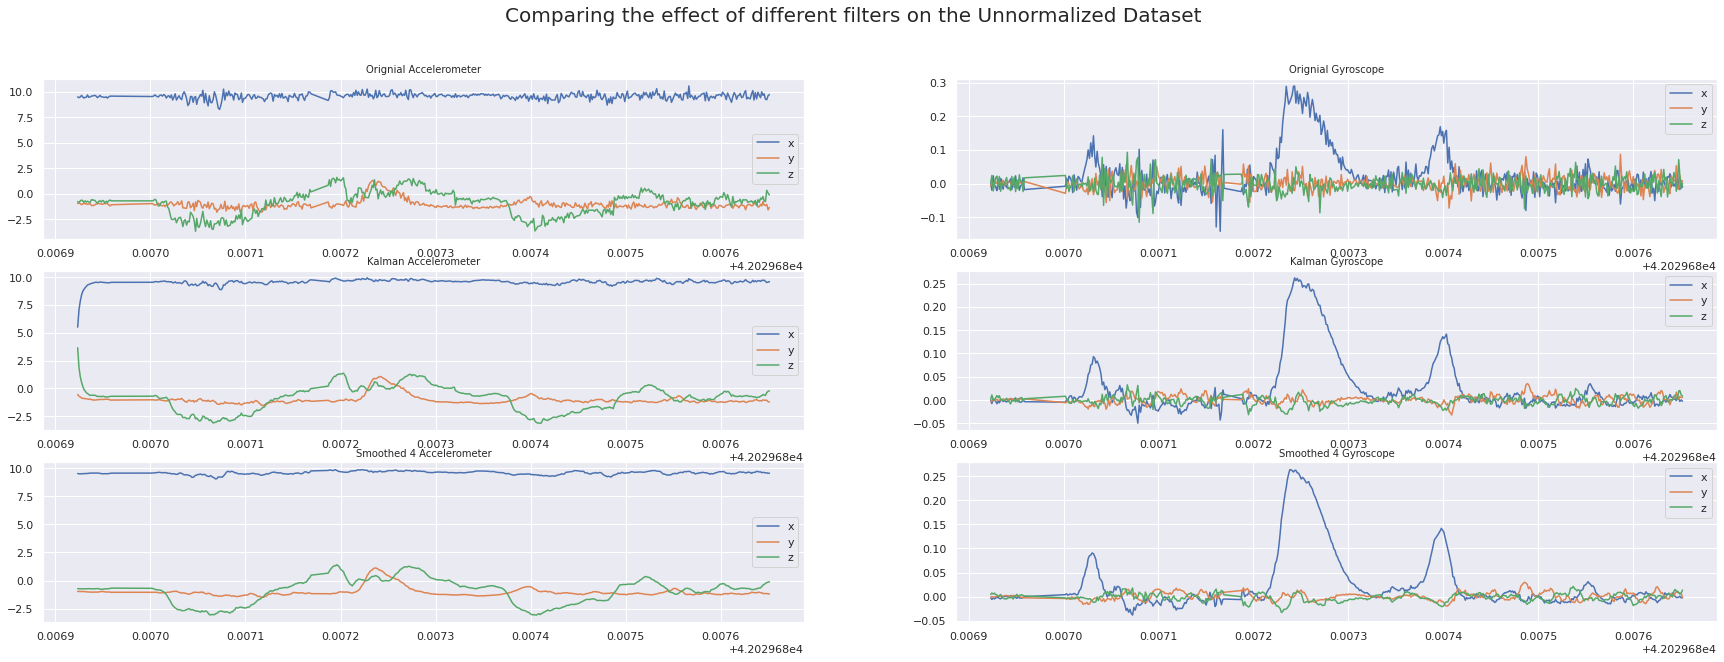

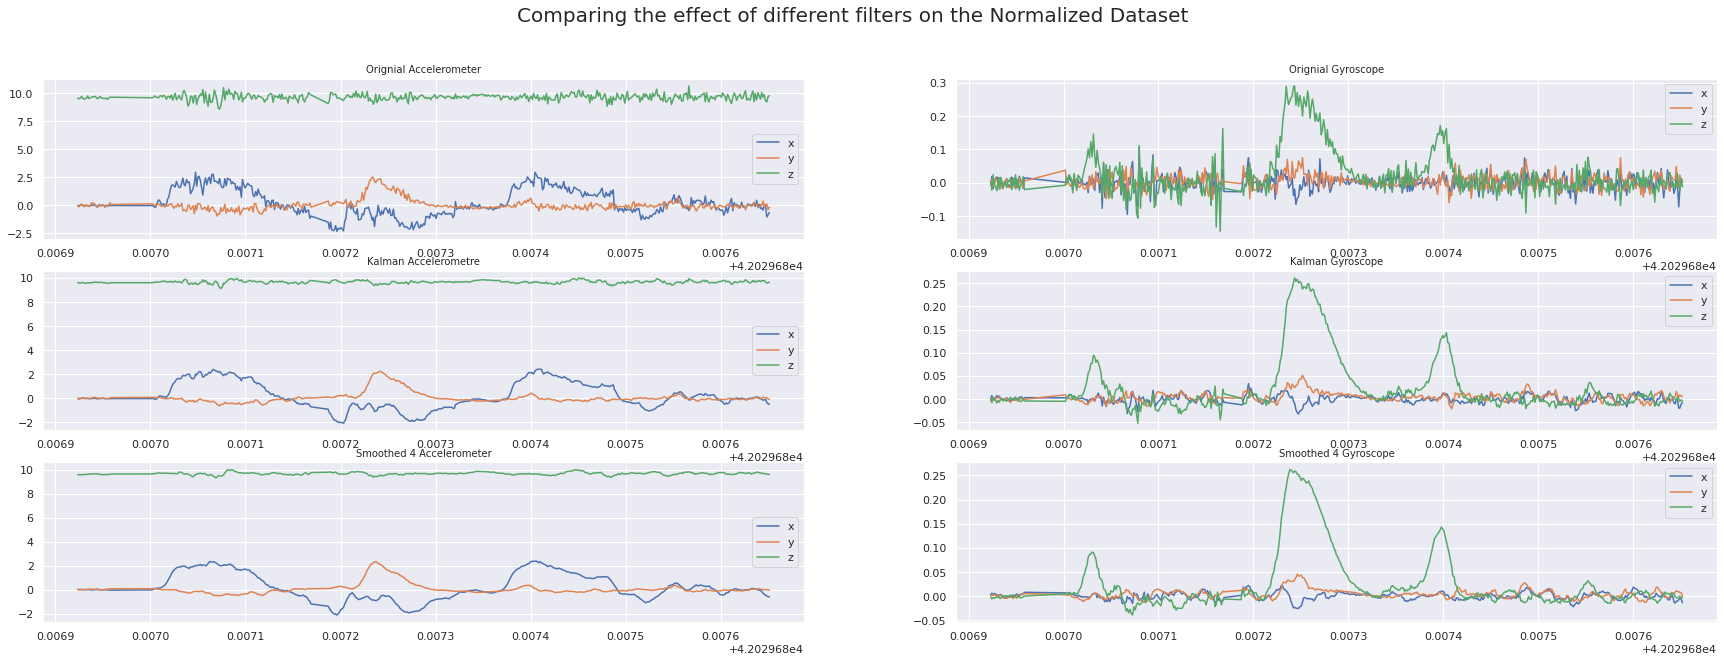

In [ ]:
def test_by_plots(test_path = "20150125.csv", smooth_val=4, smooth_test = False):
    temp = Trip(test_path, no_truth = True)

    ka = temp.kalman_filter('a')
    kg = temp.kalman_filter('g')
    sa = temp.accel.smooth(smooth_val)
    sg = temp.gyro.smooth(smooth_val)

    plt.figure(figsize=(30,10))
    plt.suptitle(f"Comparing the effect of different filters on the Unnormalized Dataset", fontsize=20)

    plt.subplot(321)
    plt.title(f"Orignial Accelerometer", fontsize=10)
    temp.accel.plot([500])

    plt.subplot(322)
    plt.title(f"Orignial Gyroscope", fontsize=10)
    temp.gyro.plot([500])

    # Plotting Kalman Filter
    plt.subplot(323)
    plt.title(f"Kalman Accelerometer", fontsize=10)
    ka.plot([500])

    plt.subplot(324)
    plt.title(f"Kalman Gyroscope", fontsize=10)
    kg.plot([500])

    # Plotting Smoothed
    plt.subplot(325)
    plt.title(f"Smoothed {smooth_val} Accelerometer", fontsize=10)
    sa.plot([500])

    plt.subplot(326)
    plt.title(f"Smoothed {smooth_val} Gyroscope", fontsize=10)
    sg.plot([500])

    temp.normalizer(False)
    ka = temp.kalman_filter('a')
    kg = temp.kalman_filter('g')
    sa = temp.accel.smooth(smooth_val)
    sg = temp.gyro.smooth(smooth_val)

    plt.figure(figsize=(30,10))
    plt.suptitle(f"Comparing the effect of different filters on the Normalized Dataset", fontsize=20)

    plt.subplot(321)
    plt.title(f"Orignial Accelerometer", fontsize=10)
    temp.accel.plot([500])

    plt.subplot(322)
    plt.title(f"Orignial Gyroscope", fontsize=10)
    temp.gyro.plot([500])

    # Plotting Kalman Filter
    plt.subplot(323)
    plt.title(f"Kalman Accelerometre", fontsize=10)
    ka.plot([500])

    plt.subplot(324)
    plt.title(f"Kalman Gyroscope", fontsize=10)
    kg.plot([500])

    # Plotting Smoothed
    plt.subplot(325)
    plt.title(f"Smoothed {smooth_val} Accelerometer", fontsize=10)
    sa.plot([500])

    plt.subplot(326)
    plt.title(f"Smoothed {smooth_val} Gyroscope", fontsize=10)
    sg.plot([500])

def filter_comparison_plot(test_path):
    temp = Trip(test_path)
    data1 = convert_to_timeseries(temp.accel.to_dataframe(),True)
    s = temp.accel.smooth()
    # s = df_to_sensor(data1)
    # s = s.smooth()
    data1['x_fil'] = savgol_filter(data1['x'].values, window_length, polyorder)
    data1['y_fil'] = savgol_filter(data1['y'].values, window_length, polyorder)
    data1['z_fil'] = savgol_filter(data1['z'].values, window_length, polyorder)

    fig, ax = plt.subplots(1, 3, figsize=(40, 10))
        
    ax[0].plot(data1[:500]['x'].values, label='x')
    ax[0].plot(data1[:500]['x_fil'].values, label='x Filtered')
    ax[0].legend();

    ax[1].plot(data1[:500]['y'].values, label='y')
    ax[1].plot(data1[:500]['y_fil'].values, label='y Filtered')
    ax[1].legend();

    ax[2].plot(data1[:500]['z'].values, label='z')
    ax[2].plot(data1[:500]['z_fil'].values, label='z Filtered')
    ax[2].legend();
    plt.suptitle(f"Original v. Filtered", fontsize= 20)

    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(40, 10))
        
    ax[0].plot(temp.accel.x[:500], label='x')
    ax[0].plot(s.x[:500], label='x Smoothed')

    ax[0].legend();

    ax[1].plot(temp.accel.y[:500], label='y')
    ax[1].plot(s.y[:500], label = "y Smoothed")

    ax[1].legend();

    ax[2].plot(temp.accel.z[:500], label='z')
    ax[2].plot(s.z[:500], label='y Smoothed')

    ax[2].legend();
    plt.suptitle(f"Original v. Smoothed", fontsize= 20)
    plt.tight_layout()
    plt.show();


    fig, ax = plt.subplots(1, 3, figsize=(40, 10))
        
    ax[0].plot(s.x[:500], label='x Smoothed')
    ax[0].plot(data1[:500]['x_fil'].values, label='x Filtered')
    ax[0].legend();

    ax[1].plot(s.y[:500], label='y Smoothed')
    ax[1].plot(data1[:500]['y_fil'].values, label='y Filtered')
    ax[1].legend();

    ax[2].plot(s.z[:500], label='z Smoothed')
    ax[2].plot(data1[:500]['z_fil'].values, label='z Filtered')
    ax[2].legend();
    plt.suptitle(f"Smoothed v. Filtered", fontsize= 20)
    plt.tight_layout()
    plt.show();


test_by_plots()


In [ ]:
# test_by_plots("admanidata.csv",)


# Visualization

In [ ]:
path16 = path_jj +"/16/"

path17 = path_jj + "/17/"

path20 = path_jj +"/20/"

path21 = path_jj +"/21/"


portu_to_english = {'evento_nao_agressivo':'Non-aggressive event','troca_faixa_esquerda_agressiva': 'Aggressive left lane change',
                    'aceleracao_agressiva':'Aggressive acceleration','freada_agressiva':'Aggressive breaking',
                   'curva_esquerda_agressiva':'Aggressive left turn','curva_direita_agressiva':'Aggressive right turn',
                  'troca_faixa_direita_agressiva':'Aggressive right lane change'}

accel1 = pd.read_csv(path16 + "acelerometro_terra.csv")
magnet1 = pd.read_csv(path16 + "campoMagnetico_terra.csv")
gyro1 = pd.read_csv(path16 + "giroscopio_terra.csv")
truth1 = pd.read_csv(path16 + "groundTruth.csv")
truth1['evento'] = [portu_to_english[x] for x in truth1['evento']]
truth1.columns = ["Event", "Start", "End"]

accel2 = pd.read_csv(path17 + "acelerometro_terra.csv")
magnet2 = pd.read_csv(path17 + "campoMagnetico_terra.csv")
gyro2 = pd.read_csv(path17 + "giroscopio_terra.csv")
truth2 = pd.read_csv(path17 + "groundTruth.csv")
truth2['evento'] = [portu_to_english[x] for x in truth2['evento']]
truth2.columns = ["Event", "Start", "End"]

accel3 = pd.read_csv(path20 + "acelerometro_terra.csv")
magnet3 = pd.read_csv(path20 + "campoMagnetico_terra.csv")
gyro3 = pd.read_csv(path20 + "giroscopio_terra.csv")
truth3 = pd.read_csv(path20 + "groundTruth.csv")
truth3['evento'] = [portu_to_english[x] for x in truth3['evento']]
truth3.columns = ["Event", "Start", "End"]

accel4 = pd.read_csv(path21 + "acelerometro_terra.csv")
magnet4 = pd.read_csv(path21 + "campoMagnetico_terra.csv")
gyro4 = pd.read_csv(path21 + "giroscopio_terra.csv")
truth4 = pd.read_csv(path21 + "groundTruth.csv")
truth4['evento'] = [portu_to_english[x] for x in truth4['evento']]
truth4.columns = ["Event", "Start", "End"]

savgol(accel1)
savgol(magnet1)
savgol(gyro1,window_length=31,polyorder=3)

savgol(accel2)
savgol(magnet2)
savgol(gyro2,window_length=31,polyorder=3)

savgol(accel3)
savgol(magnet3)
savgol(gyro3,window_length=31,polyorder=3)

savgol(accel4)
savgol(magnet4)
savgol(gyro4,window_length=31,polyorder=3)


In [ ]:
temp = Trip("admanidata.csv", no_truth = True)

In [ ]:
temp.plot_trajectory()

# Testing

In [ ]:

turn_color = px.colors.sequential.RdBu
na_color = px.colors.sequential.Teal
colors = {'Aggressive left lane change': turn_color[-4], 'Aggressive left 45-turn': turn_color[-3], 'Aggressive left turn': turn_color[-2], "Aggressive left 180-turn":turn_color[-1], "Aggressive left Overtake": turn_color[-5],
          'Aggressive right lane change': turn_color[3], 'Aggressive right 45-turn':turn_color[2] ,'Aggressive right turn':turn_color[1], "Aggressive right 180-turn": turn_color[0],  "Aggressive right Overtake": turn_color[4],
          'Aggressive acceleration': 'darkviolet', 'Aggressive breaking': 'mediumvioletred', 'Non-aggressive event': na_color[-2],  'No Maneuver': na_color[-2],
          'Aggressive right 90-turn': turn_color[1], 'Aggressive left 90-turn': turn_color[-2]}

In [ ]:
def get_data():
    window_length = 31
    polyorder = 4
    data1 = pd.read_csv(os.path.join(path_jj, str(16), "giroscopio_terra.csv"))
    truth = pd.read_csv(os.path.join(path_jj, str(16), "groundTruth.csv"))
    # data1["uptimeNanos"] = pd.to_datetime(data1['uptimeNanos'].astype(float)/1e9, unit='s')
    # .apply(lambda x: x.strftime('%H:%M:%S.%f'))
    data1['x_fil'] = savgol_filter(data1['x'].values, window_length, polyorder)
    data1['y_fil'] = savgol_filter(data1['y'].values, window_length, polyorder)
    data1['z_fil'] = savgol_filter(data1['z'].values, window_length, polyorder)

    form = "%H:%M:%S.%f"
    portu_to_english = {'evento_nao_agressivo':'Non-aggressive event','troca_faixa_esquerda_agressiva': 
                        'Aggressive left lane change','aceleracao_agressiva':'Aggressive acceleration',
                        'freada_agressiva':'Aggressive breaking','curva_esquerda_agressiva':'Aggressive left turn',
                        'curva_direita_agressiva':'Aggressive right turn','troca_faixa_direita_agressiva':
                        'Aggressive right lane change'}

    truth['evento'] = [portu_to_english[x] for x in truth['evento']]
    truth.columns = ["Event", "Start", "End"]
    init = pd.to_datetime(data1["timestamp"][0])
    data1 = convert_to_timeseries(data1, True)
    truth = preprocess_truth(truth,init)
    event_no = 0
    for index, row in truth.iterrows():
        start = row['Start']
        finish = row['End']
        data1.loc[((data1.index >= start) & (data1.index < finish)), 'Event'] = row['Event']
        data1.loc[((data1.index >= start) & (data1.index < finish)), 'Eventno'] = event_no
        event_no +=1
    data1["Event"]  = data1.Event.fillna("No Maneuver")
    data1["Eventno"]  = data1.Eventno.fillna(-1)


    temp = Trip("20150125.csv")
    temp.normalizer()
    g = temp.gyro.smooth().to_dataframe()
    g = convert_to_timeseries(g,True)
    event_no = 0
    for index, row in temp.events.iterrows():
        start = row['Start']
        finish = row['End']
        g.loc[((g.index >= start) & (g.index < finish)), 'Event'] = row['Event']
        g.loc[((g.index >= start) & (g.index < finish)), 'Eventno'] = event_no
        event_no +=1
    g["Event"]  = g.Event.fillna("No Maneuver")
    g["Eventno"]  = g.Eventno.fillna(-1)

    return data1, truth, g,temp.events, temp

In [ ]:
gyro, truth, g, t, temp = get_data()

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimelike.py:1268: PerformanceWarning:

Adding/subtracting array of DateOffsets to DatetimeArray not vectorized



In [ ]:
g["color"] = g.Event.apply(lambda x: colors[x])
gyro["color"] = gyro.Event.apply(lambda x: colors[x])

data1 = gyro[gyro.Event != "No Maneuver"]
data2 = g[g.Event != "No Maneuver"]



In [ ]:
groups1 = data1.groupby(["Event","Eventno"])
keys1  = list(groups1.groups.keys())
show=  0
for i in keys1:
    if show <=5:
        fig = groups1.get_group(i).plot(y= ['x_fil','y_fil','z_fil'], title = f"{i[0]} {i[1]}")
        fig.show()
        show+=1

In [ ]:
groups1.get_group(keys1[0]).describe()

uptimeNanos           x           y  ...       y_fil       z_fil  Eventno
count  2.300000e+02  230.000000  230.000000  ...  230.000000  230.000000    230.0
mean   1.178627e+13   -0.092196   -0.091059  ...   -0.090946    0.331700      4.0
std    1.306378e+09    0.163718    0.183117  ...    0.133449    0.258321      0.0
min    1.178402e+13   -0.745457   -0.767856  ...   -0.491663   -0.063870      4.0
25%    1.178514e+13   -0.154659   -0.150671  ...   -0.187877    0.068389      4.0
50%    1.178627e+13   -0.068031   -0.057970  ...   -0.035703    0.393387      4.0
75%    1.178739e+13    0.011676    0.030983  ...    0.000378    0.591004      4.0
max    1.178852e+13    0.316404    0.263058  ...    0.074740    0.681611      4.0

[8 rows x 8 columns]

In [ ]:
groups1.get_group(keys1[1]).describe()

uptimeNanos           x           y  ...       y_fil       z_fil  Eventno
count  1.840000e+02  184.000000  184.000000  ...  184.000000  184.000000    184.0
mean   1.188752e+13   -0.113375   -0.134344  ...   -0.134396    0.403883      5.0
std    1.045609e+09    0.191991    0.208447  ...    0.157108    0.235084      0.0
min    1.188573e+13   -0.761338   -0.978680  ...   -0.451309   -0.027112      5.0
25%    1.188663e+13   -0.192966   -0.249056  ...   -0.282472    0.182225      5.0
50%    1.188752e+13   -0.083783   -0.073158  ...   -0.060231    0.514429      5.0
75%    1.188842e+13   -0.015498   -0.002734  ...   -0.011405    0.585032      5.0
max    1.188932e+13    0.714779    0.273248  ...    0.061398    0.690936      5.0

[8 rows x 8 columns]

In [ ]:
offset = pd.tseries.offsets.DateOffset(seconds= 0)
start = temp.events.iloc[4].Start
end = temp.events.iloc[4].End
mask = (g.index >= (start-offset)) & (g.index <=(end + offset))
left45  = g[mask]
# left45
# plot_event([g], temp.events, "Aggressive left 45-turn")

In [ ]:
left45.plot(y= ["x","y","z"])

In [ ]:
def dtw(s, t, window):
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)])
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [ ]:
left45.head()

x  ...            color
timestamp                             ...                 
2020-06-25 16:30:51.000000 -0.005597  ...  rgb(67,147,195)
2020-06-25 16:30:51.000000 -0.003696  ...  rgb(67,147,195)
2020-06-25 16:30:51.142857 -0.002734  ...  rgb(67,147,195)
2020-06-25 16:30:51.285714 -0.003551  ...  rgb(67,147,195)
2020-06-25 16:30:51.428571 -0.005773  ...  rgb(67,147,195)

[5 rows x 5 columns]

In [ ]:
a = [1,2,3,3,5,10,10,20]
b= [1,2,3,3,5]
dtw(a,b, window =4)
# dtw(left45.z,left45.z,window=3)

array([[ 0., inf, inf, inf, inf, inf],
       [inf,  0.,  1.,  3.,  5.,  9.],
       [inf,  1.,  0.,  1.,  2.,  5.],
       [inf,  3.,  1.,  0.,  0.,  2.],
       [inf,  5.,  2.,  0.,  0.,  2.],
       [inf,  9.,  5.,  2.,  2.,  0.],
       [inf, inf, 13.,  9.,  9.,  5.],
       [inf, inf, inf, 16., 16., 10.],
       [inf, inf, inf, inf, 33., 25.]])

In [ ]:
fig = px.scatter(x= data1.index, y=data1.z, color=data1.Event, marginal_y="rug")
fig.show()
fig = px.scatter(x= data2.index, y=data2.z, color=data2.Event, marginal_y="rug")
fig.show()
# fig = px.scatter(x= data1.uptimeNanos, y=data1.y, color=data1.Event, marginal_y="rug")
# fig.show()
# fig = px.scatter(x= data1.uptimeNanos, y=data1.z, color=data1.Event, marginal_y="rug")
# fig.show()
# fig.update_xaxes(
#     rangeslider_visible=True,
#     rangeselector=dict(
#         activecolor = "#eefeef",
#         buttons=list([
#             dict(count=2, label="2m", step="minute", stepmode="todate"),
#             dict(count=30, label="30s", step="second", stepmode="todate"),

#         ])
#     )
# )




In [ ]:
g[g.Event == "Aggressive left 45-turn"]

x  ...            color
timestamp                             ...                 
2020-06-24 16:30:51.000000 -0.005597  ...  rgb(67,147,195)
2020-06-24 16:30:51.000000 -0.003696  ...  rgb(67,147,195)
2020-06-24 16:30:51.142857 -0.002734  ...  rgb(67,147,195)
2020-06-24 16:30:51.285714 -0.003551  ...  rgb(67,147,195)
2020-06-24 16:30:51.428571 -0.005773  ...  rgb(67,147,195)
...                              ...  ...              ...
2020-06-24 16:42:59.285714  0.004110  ...  rgb(67,147,195)
2020-06-24 16:42:59.428571 -0.000139  ...  rgb(67,147,195)
2020-06-24 16:42:59.571429 -0.008366  ...  rgb(67,147,195)
2020-06-24 16:42:59.714286 -0.011909  ...  rgb(67,147,195)
2020-06-24 16:42:59.857143 -0.009539  ...  rgb(67,147,195)

[472 rows x 5 columns]

In [ ]:
def plot_instance(sensor_list, start, end, axes= ["x","y","z"], offset = 2):
    """
    Plots one instance of any maneuver between start and end time
    """
    plt.figure(figsize = (20,4.8))
    offset = pd.tseries.offsets.DateOffset(seconds= offset)
    r = len(sensor_list)
    subplot = 1
    for sensor in sensor_list:   
        mask = (sensor.index >= (start-offset)) & (sensor.index <=(end + offset))
        num = 100 + r*10 + subplot
        plt.subplot(num)
        for axis in axes:
            plt.axvspan(start, end, color='#FF9379', alpha=0.2)
            plt.plot(sensor.index[mask], sensor[mask][axis])
        plt.legend(["x","y","z"])
        plt.title("Sensor {}".format(subplot))
        subplot+=1
        
def plot_event(sensor_list,df_truth, event, axes= ["x","y","z"], offset=2):
    """
    Plots all instances of a maneuver in a given trip
    """
    e = df_truth[df_truth["Event"] == event]
    for i in range(e.count()[0]):
        plot_instance(sensor_list, e.iloc[i]['Start'], e.iloc[i]['End'], axes, offset)
e = truth =Aggressive left turn"

In [ ]:
processed = temp.create_test_data(nf =6)

In [ ]:
Q1 = processed[1].quantile(0.25)
Q3 = processed[1].quantile(0.75)
IQR = Q3 - Q1
# print(IQR)
new_df = processed[1][~(processed[1]["T7_z"] < (Q1.T7_z - 1.5 * IQR.T7_z)) | (processed[1]["T7_z"] > (Q3.T7_z + 1.5 * IQR.T7_z))]
new_df.describe()

M0_x        M1_x        M2_x  ...        T5_z        T6_z         T7_z
count  252.000000  252.000000  252.000000  ...  252.000000  252.000000   252.000000
mean     0.003204    0.003500    0.003662  ...    4.433034   11.525204    19.227570
std      0.007561    0.006191    0.005162  ...   57.128353   70.709872   113.397088
min     -0.020433   -0.015653   -0.014367  ... -158.503760  -43.314399   -34.032256
25%     -0.001831   -0.000271    0.000953  ...   -4.888088   -5.371699    -7.024326
50%      0.003244    0.003533    0.003672  ...   -0.278353   -0.295397    -0.382253
75%      0.008696    0.007972    0.007275  ...    1.877524    3.277193     4.410953
max      0.019074    0.020921    0.015152  ...  568.476314  538.810456  1407.824909

[8 rows x 93 columns]

In [ ]:
fig = px.box(y= new_df["T3_z"], x = new_df.maneuver)
fig.show()

In [ ]:
fig = px.scatter(y= new_df["T3_z"], color = new_df.maneuver,  marginal_y="rug")
fig.show()

In [ ]:

# create_attribute_dict(g['z'],
window = ['16:30:36','16:30:37','16:30:38']
groups = g.groupby("timestamp")
groups.get_group(window[0])

timestamp         x         y         z
694  16:30:36  0.000388 -0.005802 -0.030334
695  16:30:36 -0.001466 -0.005684 -0.033831
696  16:30:36 -0.001619 -0.004101 -0.035829
697  16:30:36 -0.001973 -0.004291 -0.035828
698  16:30:36  0.001995 -0.002096 -0.033826
699  16:30:36  0.001303 -0.006730 -0.031733
700  16:30:36  0.003603  0.001870 -0.037013
701  16:30:36  0.001976  0.002885 -0.036455

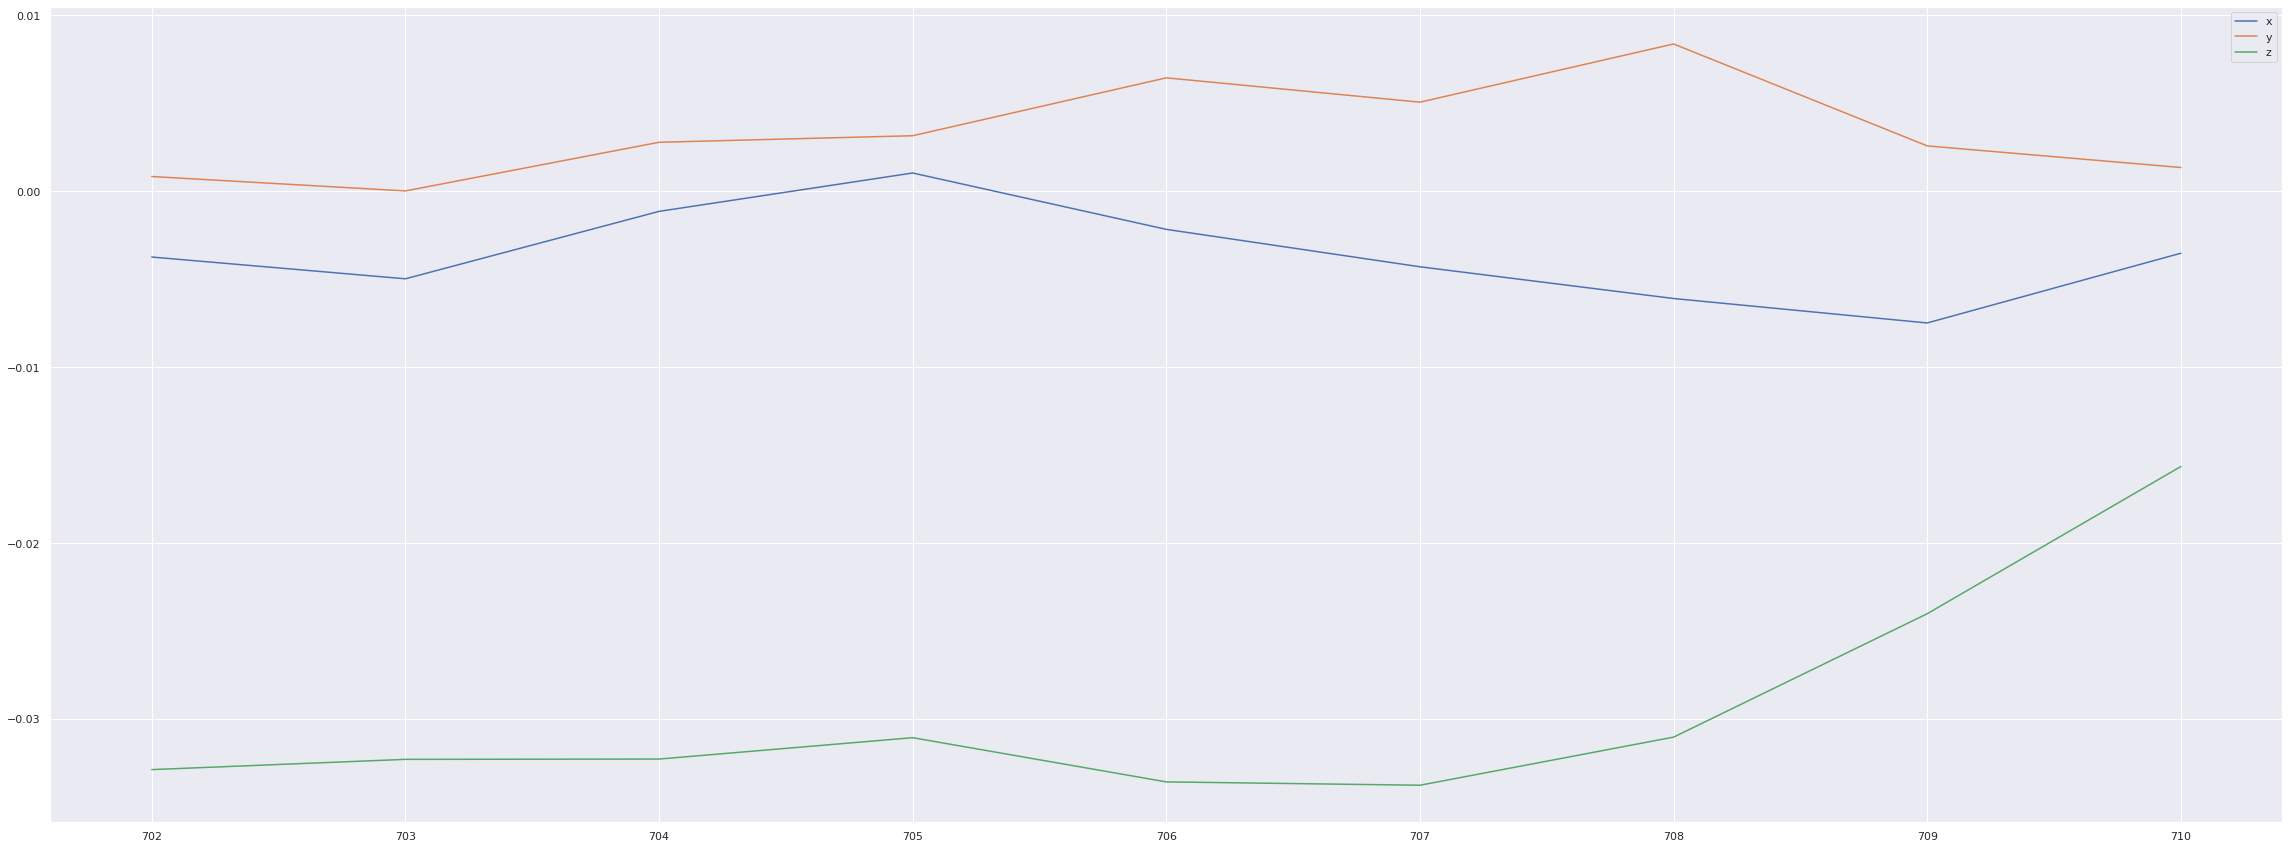

In [ ]:
groups.get_group(window[1])

In [ ]:
groups.get_group(window[1])

timestamp         x         y         z
702  16:30:37 -0.003738  0.000838 -0.032866
703  16:30:37 -0.004975  0.000018 -0.032283
704  16:30:37 -0.001143  0.002783 -0.032266
705  16:30:37  0.001038  0.003155 -0.031051
706  16:30:37 -0.002165  0.006445 -0.033563
707  16:30:37 -0.004292  0.005062 -0.033753
708  16:30:37 -0.006095  0.008370 -0.031019
709  16:30:37 -0.007484  0.002577 -0.024006
710  16:30:37 -0.003521  0.001351 -0.015642

In [ ]:
new_df[new_df["T7_z"] >10]

timestamp    tripid  ...        T7_z                  maneuver
7   2020-06-24 16:29:36  20150125  ...   20.080267   Aggressive left 90-turn
47  2020-06-24 16:32:02  20150125  ...  101.507497  Aggressive left 180-turn
56  2020-06-24 16:32:25  20150125  ...   34.980487  Aggressive right 45-turn
68  2020-06-24 16:33:10  20150125  ...   15.864961   Aggressive left 45-turn
69  2020-06-24 16:33:10  20150125  ...   11.430999   Aggressive left 45-turn
70  2020-06-24 16:33:10  20150125  ...   14.293587   Aggressive left 45-turn
84  2020-06-24 16:34:09  20150125  ...   48.012529  Aggressive left 180-turn
91  2020-06-24 16:34:22  20150125  ...   10.943195  Aggressive right 45-turn
94  2020-06-24 16:34:22  20150125  ...   21.688238  Aggressive right 45-turn
95  2020-06-24 16:34:22  20150125  ...   30.930927  Aggressive right 45-turn
102 2020-06-24 16:34:46  20150125  ...   10.492960   Aggressive left 45-turn
110 2020-06-24 16:35:02  20150125  ...   13.757590  Aggressive left 180-turn
118 2020-06-24 16:35:42  20150125  ...   25.368400  Aggressive left 180-turn
119 2020-06-24 16:35:42  20150125  ...  147.997857  Aggressive left 180-turn
120 2020-06-24 16:35:42  20150125  ...  290.433919  Aggressive left 180-turn
129 2020-06-24 16:35:55  20150125  ...   10.388583  Aggressive right 45-turn
163 2020-06-24 16:38:04  20150125  ...   11.811749  Aggressive right 45-turn
164 2020-06-24 16:38:04  20150125  ...   17.588102  Aggressive right 45-turn
183 2020-06-24 16:38:56  20150125  ...  148.471739  Aggressive left 180-turn
189 2020-06-24 16:39:34  20150125  ...   78.269309  Aggressive left 180-turn
208 2020-06-24 16:40:25  20150125  ...   83.153409   Aggressive left 45-turn
220 2020-06-24 16:40:37  20150125  ...   52.145443  Aggressive left 180-turn
221 2020-06-24 16:40:37  20150125  ...  194.959545  Aggressive left 180-turn
230 2020-06-24 16:41:22  20150125  ...  219.047425  Aggressive left 180-turn
231 2020-06-24 16:41:22  20150125  ...   24.246102  Aggressive left 180-turn
265 2020-06-24 16:42:52  20150125  ...   49.889010  Aggressive right 45-turn
274 2020-06-24 16:43:11  20150125  ...  243.708505  Aggressive right 90-turn

[27 rows x 96 columns]

In [ ]:
processed[1][processed[1]["T7_z"] >10]

timestamp    tripid  ...         T7_z                  maneuver
7   2020-06-24 16:29:36  20150125  ...    20.080267   Aggressive left 90-turn
24  2020-06-24 16:30:48  20150125  ...    22.503996  Aggressive right 45-turn
30  2020-06-24 16:31:11  20150125  ...    14.552229   Aggressive left 45-turn
47  2020-06-24 16:32:02  20150125  ...   101.507497  Aggressive left 180-turn
56  2020-06-24 16:32:25  20150125  ...    34.980487  Aggressive right 45-turn
58  2020-06-24 16:32:25  20150125  ...    94.394085  Aggressive right 45-turn
65  2020-06-24 16:33:10  20150125  ...   596.113287   Aggressive left 45-turn
68  2020-06-24 16:33:10  20150125  ...    15.864961   Aggressive left 45-turn
69  2020-06-24 16:33:10  20150125  ...    11.430999   Aggressive left 45-turn
70  2020-06-24 16:33:10  20150125  ...    14.293587   Aggressive left 45-turn
84  2020-06-24 16:34:09  20150125  ...    48.012529  Aggressive left 180-turn
85  2020-06-24 16:34:09  20150125  ...   376.846656  Aggressive left 180-turn
91  2020-06-24 16:34:22  20150125  ...    10.943195  Aggressive right 45-turn
94  2020-06-24 16:34:22  20150125  ...    21.688238  Aggressive right 45-turn
95  2020-06-24 16:34:22  20150125  ...    30.930927  Aggressive right 45-turn
101 2020-06-24 16:34:46  20150125  ...    10.585972   Aggressive left 45-turn
102 2020-06-24 16:34:46  20150125  ...    10.492960   Aggressive left 45-turn
110 2020-06-24 16:35:02  20150125  ...    13.757590  Aggressive left 180-turn
118 2020-06-24 16:35:42  20150125  ...    25.368400  Aggressive left 180-turn
119 2020-06-24 16:35:42  20150125  ...   147.997857  Aggressive left 180-turn
120 2020-06-24 16:35:42  20150125  ...   290.433919  Aggressive left 180-turn
129 2020-06-24 16:35:55  20150125  ...    10.388583  Aggressive right 45-turn
137 2020-06-24 16:36:40  20150125  ...   158.578856   Aggressive left 45-turn
139 2020-06-24 16:36:40  20150125  ...   155.193101   Aggressive left 45-turn
159 2020-06-24 16:37:49  20150125  ...   303.267704  Aggressive left 180-turn
163 2020-06-24 16:38:04  20150125  ...    11.811749  Aggressive right 45-turn
164 2020-06-24 16:38:04  20150125  ...    17.588102  Aggressive right 45-turn
183 2020-06-24 16:38:56  20150125  ...   148.471739  Aggressive left 180-turn
189 2020-06-24 16:39:34  20150125  ...    78.269309  Aggressive left 180-turn
208 2020-06-24 16:40:25  20150125  ...    83.153409   Aggressive left 45-turn
220 2020-06-24 16:40:37  20150125  ...    52.145443  Aggressive left 180-turn
221 2020-06-24 16:40:37  20150125  ...   194.959545  Aggressive left 180-turn
230 2020-06-24 16:41:22  20150125  ...   219.047425  Aggressive left 180-turn
231 2020-06-24 16:41:22  20150125  ...    24.246102  Aggressive left 180-turn
265 2020-06-24 16:42:52  20150125  ...    49.889010  Aggressive right 45-turn
274 2020-06-24 16:43:11  20150125  ...   243.708505  Aggressive right 90-turn
281 2020-06-24 16:43:32  20150125  ...    55.219872   Aggressive left 90-turn
282 2020-06-24 16:43:32  20150125  ...  1407.824909   Aggressive left 90-turn
283 2020-06-24 16:43:32  20150125  ...   572.340446   Aggressive left 90-turn
284 2020-06-24 16:43:32  20150125  ...   121.219711   Aggressive left 90-turn
285 2020-06-24 16:43:32  20150125  ...    96.674458   Aggressive left 90-turn

[41 rows x 96 columns]

In [ ]:
df_gyroz[(df_gyroz["T7_z"] >10)  & (df_gyroz.tripid == df_gyroz.tripid.unique()[0])]

timestamp    tripid  ...         T7_z                  maneuver
7   2020-06-23 16:29:36  20150125  ...    20.080267   Aggressive left 90-turn
24  2020-06-23 16:30:48  20150125  ...    22.503996  Aggressive right 45-turn
30  2020-06-23 16:31:11  20150125  ...    14.552229   Aggressive left 45-turn
47  2020-06-23 16:32:02  20150125  ...   101.507497  Aggressive left 180-turn
56  2020-06-23 16:32:25  20150125  ...    34.980487  Aggressive right 45-turn
58  2020-06-23 16:32:25  20150125  ...    94.394085  Aggressive right 45-turn
65  2020-06-23 16:33:10  20150125  ...   596.113287   Aggressive left 45-turn
68  2020-06-23 16:33:10  20150125  ...    15.864961   Aggressive left 45-turn
69  2020-06-23 16:33:10  20150125  ...    11.430999   Aggressive left 45-turn
70  2020-06-23 16:33:10  20150125  ...    14.293587   Aggressive left 45-turn
84  2020-06-23 16:34:09  20150125  ...    48.012529  Aggressive left 180-turn
85  2020-06-23 16:34:09  20150125  ...   376.846656  Aggressive left 180-turn
91  2020-06-23 16:34:22  20150125  ...    10.943195  Aggressive right 45-turn
94  2020-06-23 16:34:22  20150125  ...    21.688238  Aggressive right 45-turn
95  2020-06-23 16:34:22  20150125  ...    30.930927  Aggressive right 45-turn
101 2020-06-23 16:34:46  20150125  ...    10.585972   Aggressive left 45-turn
102 2020-06-23 16:34:46  20150125  ...    10.492960   Aggressive left 45-turn
110 2020-06-23 16:35:02  20150125  ...    13.757590  Aggressive left 180-turn
118 2020-06-23 16:35:42  20150125  ...    25.368400  Aggressive left 180-turn
119 2020-06-23 16:35:42  20150125  ...   147.997857  Aggressive left 180-turn
120 2020-06-23 16:35:42  20150125  ...   290.433919  Aggressive left 180-turn
129 2020-06-23 16:35:55  20150125  ...    10.388583  Aggressive right 45-turn
137 2020-06-23 16:36:40  20150125  ...   158.578856   Aggressive left 45-turn
139 2020-06-23 16:36:40  20150125  ...   155.193101   Aggressive left 45-turn
159 2020-06-23 16:37:49  20150125  ...   303.267704  Aggressive left 180-turn
163 2020-06-23 16:38:04  20150125  ...    11.811749  Aggressive right 45-turn
164 2020-06-23 16:38:04  20150125  ...    17.588102  Aggressive right 45-turn
183 2020-06-23 16:38:56  20150125  ...   148.471739  Aggressive left 180-turn
189 2020-06-23 16:39:34  20150125  ...    78.269309  Aggressive left 180-turn
208 2020-06-23 16:40:25  20150125  ...    83.153409   Aggressive left 45-turn
220 2020-06-23 16:40:37  20150125  ...    52.145443  Aggressive left 180-turn
221 2020-06-23 16:40:37  20150125  ...   194.959545  Aggressive left 180-turn
230 2020-06-23 16:41:22  20150125  ...   219.047425  Aggressive left 180-turn
231 2020-06-23 16:41:22  20150125  ...    24.246102  Aggressive left 180-turn
265 2020-06-23 16:42:52  20150125  ...    49.889010  Aggressive right 45-turn
274 2020-06-23 16:43:11  20150125  ...   243.708505  Aggressive right 90-turn
281 2020-06-23 16:43:32  20150125  ...    55.219872   Aggressive left 90-turn
282 2020-06-23 16:43:32  20150125  ...  1407.824909   Aggressive left 90-turn
283 2020-06-23 16:43:32  20150125  ...   572.340446   Aggressive left 90-turn
284 2020-06-23 16:43:32  20150125  ...   121.219711   Aggressive left 90-turn
285 2020-06-23 16:43:32  20150125  ...    96.674458   Aggressive left 90-turn

[41 rows x 34 columns]

In [ ]:
pro[(pro["T7_z"] > 10)]

Unnamed: 0           timestamp  ...        T7_z                     maneuver
7              7 2020-06-23 16:29:36  ...   20.080267      Aggressive left 90-turn
24            24 2020-06-23 16:30:48  ...   22.503996     Aggressive right 45-turn
30            30 2020-06-23 16:31:11  ...   14.552229      Aggressive left 45-turn
47            47 2020-06-23 16:32:02  ...  101.507497     Aggressive left 180-turn
56            56 2020-06-23 16:32:25  ...   34.980487     Aggressive right 45-turn
...          ...                 ...  ...         ...                          ...
4923        4923 2020-06-23 11:45:49  ...  690.849943     Aggressive left 180-turn
4924        4924 2020-06-23 11:45:49  ...  493.419361     Aggressive left 180-turn
4925        4925 2020-06-23 11:45:49  ...  135.872787     Aggressive left 180-turn
4927        4927 2020-06-23 11:45:49  ...  343.856156     Aggressive left 180-turn
4932        4932 2020-06-23 11:47:19  ...   13.582020  Aggressive left lane change

[580 rows x 35 columns]

In [ ]:
df['key'] = (df['Event'] != df['Event'].shift(1)).astype(int).cumsum()
groups = df.groupby(['key', 'Event'])
i =0
fig = go.Figure()
shown = []
for k in groups.groups.keys():
    if i <10:
        i+=1
        df = groups.get_group(k)
        trace = plotly.graph_objs.Scatter(x=df.uptimeNanos, y=df.x, name = k[1], legendgroup=k[1], showlegend = k[1] not in shown,
                                            marker={'color': (0,0,0)})
        fig.add_trace(trace,)
        shown.append(k[1])
fig.show()

In [ ]:
already_plotted = []
df=data1
fig = go.Figure()
for i in range(df.shape[0] + 1):
    # create a new trace if the category changes or at the end of the data frame
    if i in (0, df.shape[0]) or cat != df.iloc[i, ]['Event']:
        if i != 0:
            if i != df.shape[0]:
                x.append(df.iloc[i,].uptimeNanos)
                y.append(df.iloc[i,]['x'])
            trace = plotly.graph_objs.Scatter(x=x, y=y, 
                                              legendgroup=cat,  # group identical categories
                                              showlegend=cat not in already_plotted,  # hide legend if already plotted
                                              name=cat,
                                              marker={'color': colors[df.iloc[i - 1, ]['Event']]})
            fig.add_trace(trace)
            already_plotted.append(cat)
        if i == df.shape[0]:
            continue
        cat = df.iloc[i, ]["Event"]
        x = []
        y = []    

    x.append(df.iloc[i,].uptimeNanos)
    y.append(df.iloc[i,]['x'])      
fig.show()

In [ ]:
data1 = pd.read_csv(os.path.join(path_jj, str(16), "giroscopio_terra.csv"))
# data1 = temp.accel.smooth().to_dataframe()
s = df_to_sensor(data1)
s = s.smooth()
data1['x_fil'] = savgol_filter(data1['x'].values, window_length, polyorder)
data1['y_fil'] = savgol_filter(data1['y'].values, window_length, polyorder)
data1['z_fil'] = savgol_filter(data1['z'].values, window_length, polyorder)

fig, ax = plt.subplots(1, 3, figsize=(40, 10))
    
ax[0].plot(data1[:500]['x'].values, label='x')
ax[0].plot(data1[:500]['x_fil'].values, label='x filtered')
ax[0].legend();

ax[1].plot(data1[:500]['y'].values, label='y')
ax[1].plot(data1[:500]['y_fil'].values, label='y filtered')
ax[1].legend();

ax[2].plot(data1[:500]['z'].values, label='z')
ax[2].plot(data1[:500]['z_fil'].values, label='z filtered')
ax[2].legend();
plt.suptitle(f"Original v. Filtered", fontsize= 20)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(40, 10))
    
ax[0].plot(s.x[:500], label='x')
ax[0].plot(data1[:500]['x_fil'].values, label='x filtered')
ax[0].legend();

ax[1].plot(s.y[:500], label='y')
ax[1].plot(data1[:500]['y_fil'].values, label='y filtered')
ax[1].legend();

ax[2].plot(s.z[:500], label='z')
ax[2].plot(data1[:500]['z_fil'].values, label='z filtered')
ax[2].legend();
plt.suptitle(f"Smoothed v. Filtered", fontsize= 20)
plt.tight_layout()
plt.show();


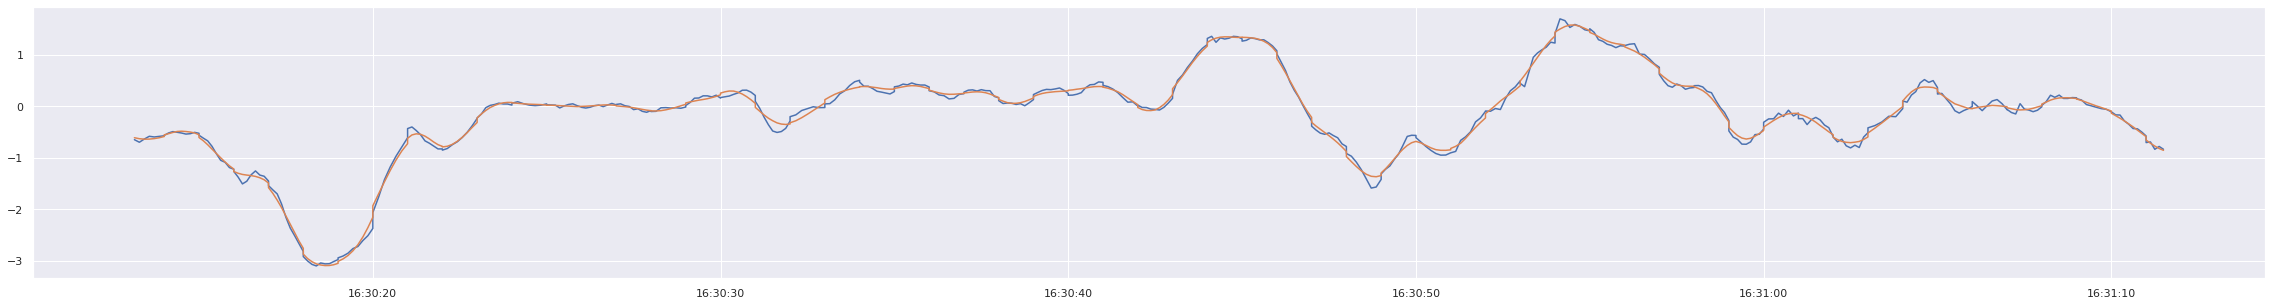

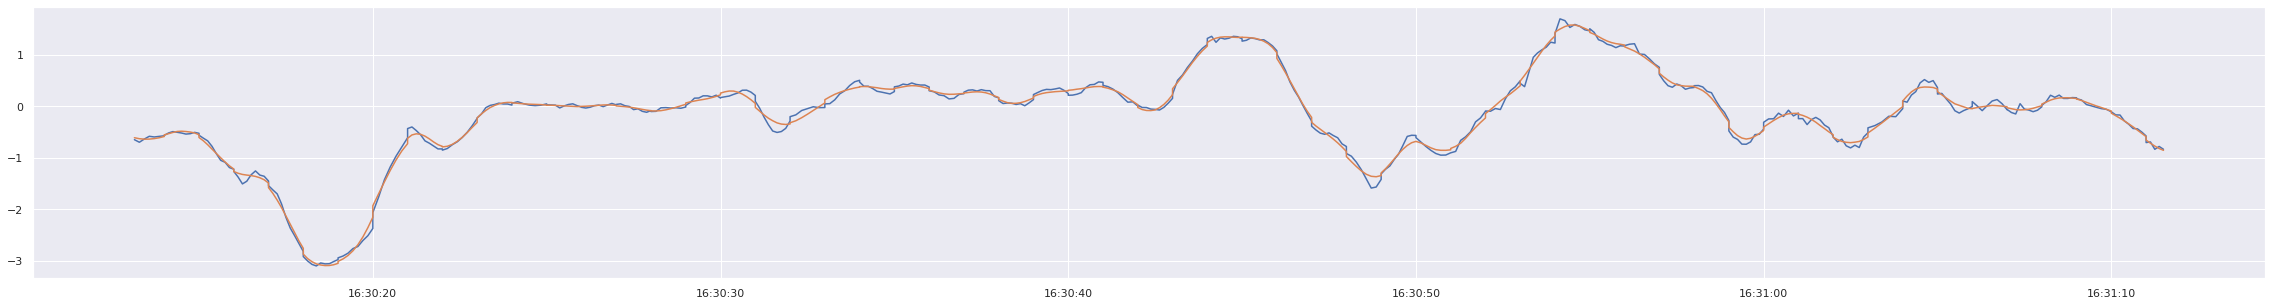

In [ ]:
u = 1000
l=500
fig, ax = plt.subplots(figsize = (40,5))
ax.plot(data1["x"][l:u])
ax.plot(data1["x_fil"][l:u])

# axis = [2,3,4]
fig, ax = plt.subplots(figsize = (40,5))
ax.plot(data1.index[l:u], data1["x"][l:u])
ax.plot(data1.index[l:u], data1["x_fil"][l:u])

plt.show()

# Playground

In [ ]:
df_gyroz.head()

timestamp    tripid  ...       T7_z                     maneuver
0 2020-06-23 16:29:18  20150125  ...  -4.337628  Aggressive left lane change
1 2020-06-23 16:29:18  20150125  ...  -1.446361  Aggressive left lane change
2 2020-06-23 16:29:18  20150125  ...  -0.404384  Aggressive left lane change
3 2020-06-23 16:29:36  20150125  ... -14.526580      Aggressive left 90-turn
4 2020-06-23 16:29:36  20150125  ... -85.844193      Aggressive left 90-turn

[5 rows x 34 columns]

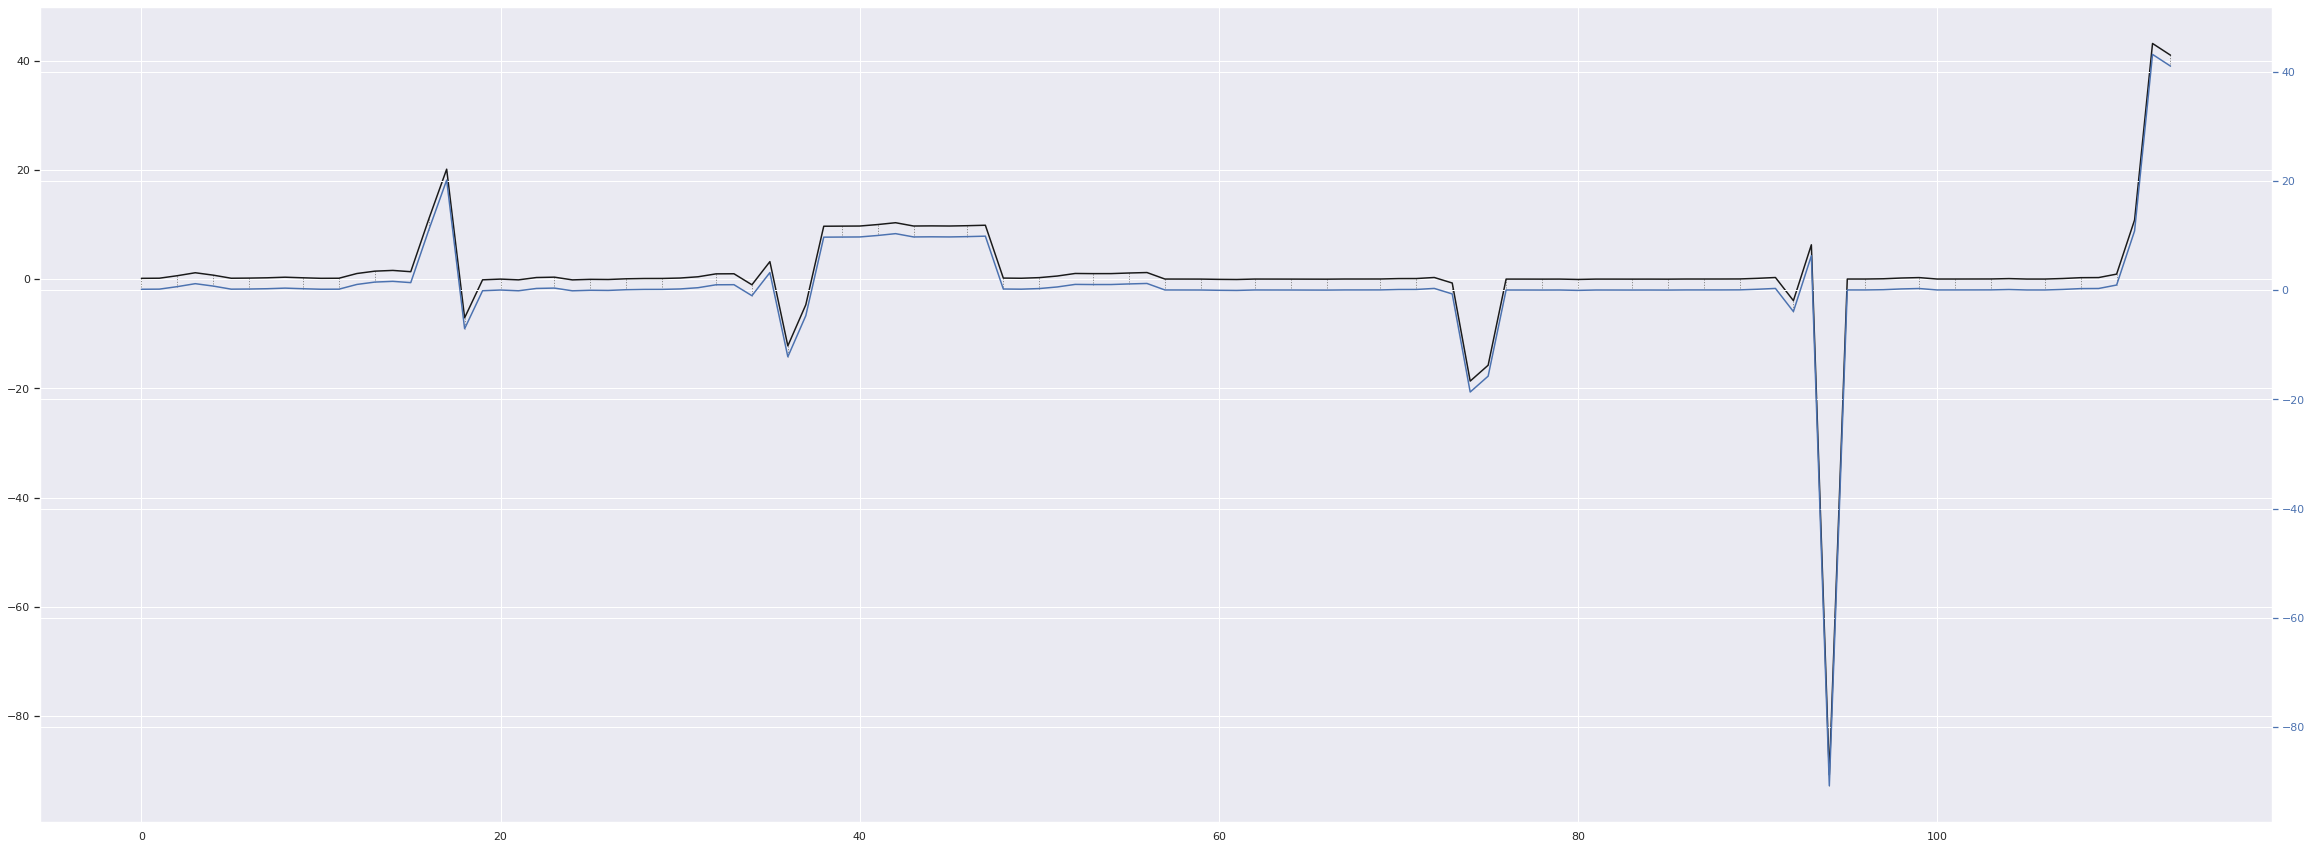

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



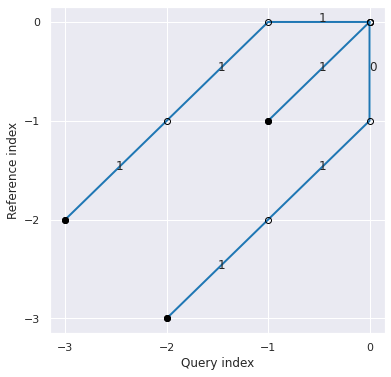

In [ ]:

# ## A noisy sine wave as query
# idx = np.linspace(0,6.28,num=100)
# query = np.sin(idx) + np.random.uniform(size=200)/10.0
template = pro[(pro["tripid"] == 16) & (pro["maneuver"] == "Aggressive left turn")].iloc[0,3:-1].to_numpy()
query =template = pro[(pro["tripid"] == 16) & (pro["maneuver"] == "Aggressive left turn")].iloc[11,3:-1].to_numpy()

## A cosine is for template; sin and cos are offset by 25 samples
# template = np.cos(idx)

## Find the best match with the canonical recursion formula
alignment = dtw(query, template, keep_internals=True)

# ## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
print(rabinerJuangStepPattern(6,"c"))
rabinerJuangStepPattern(6,"c").plot()


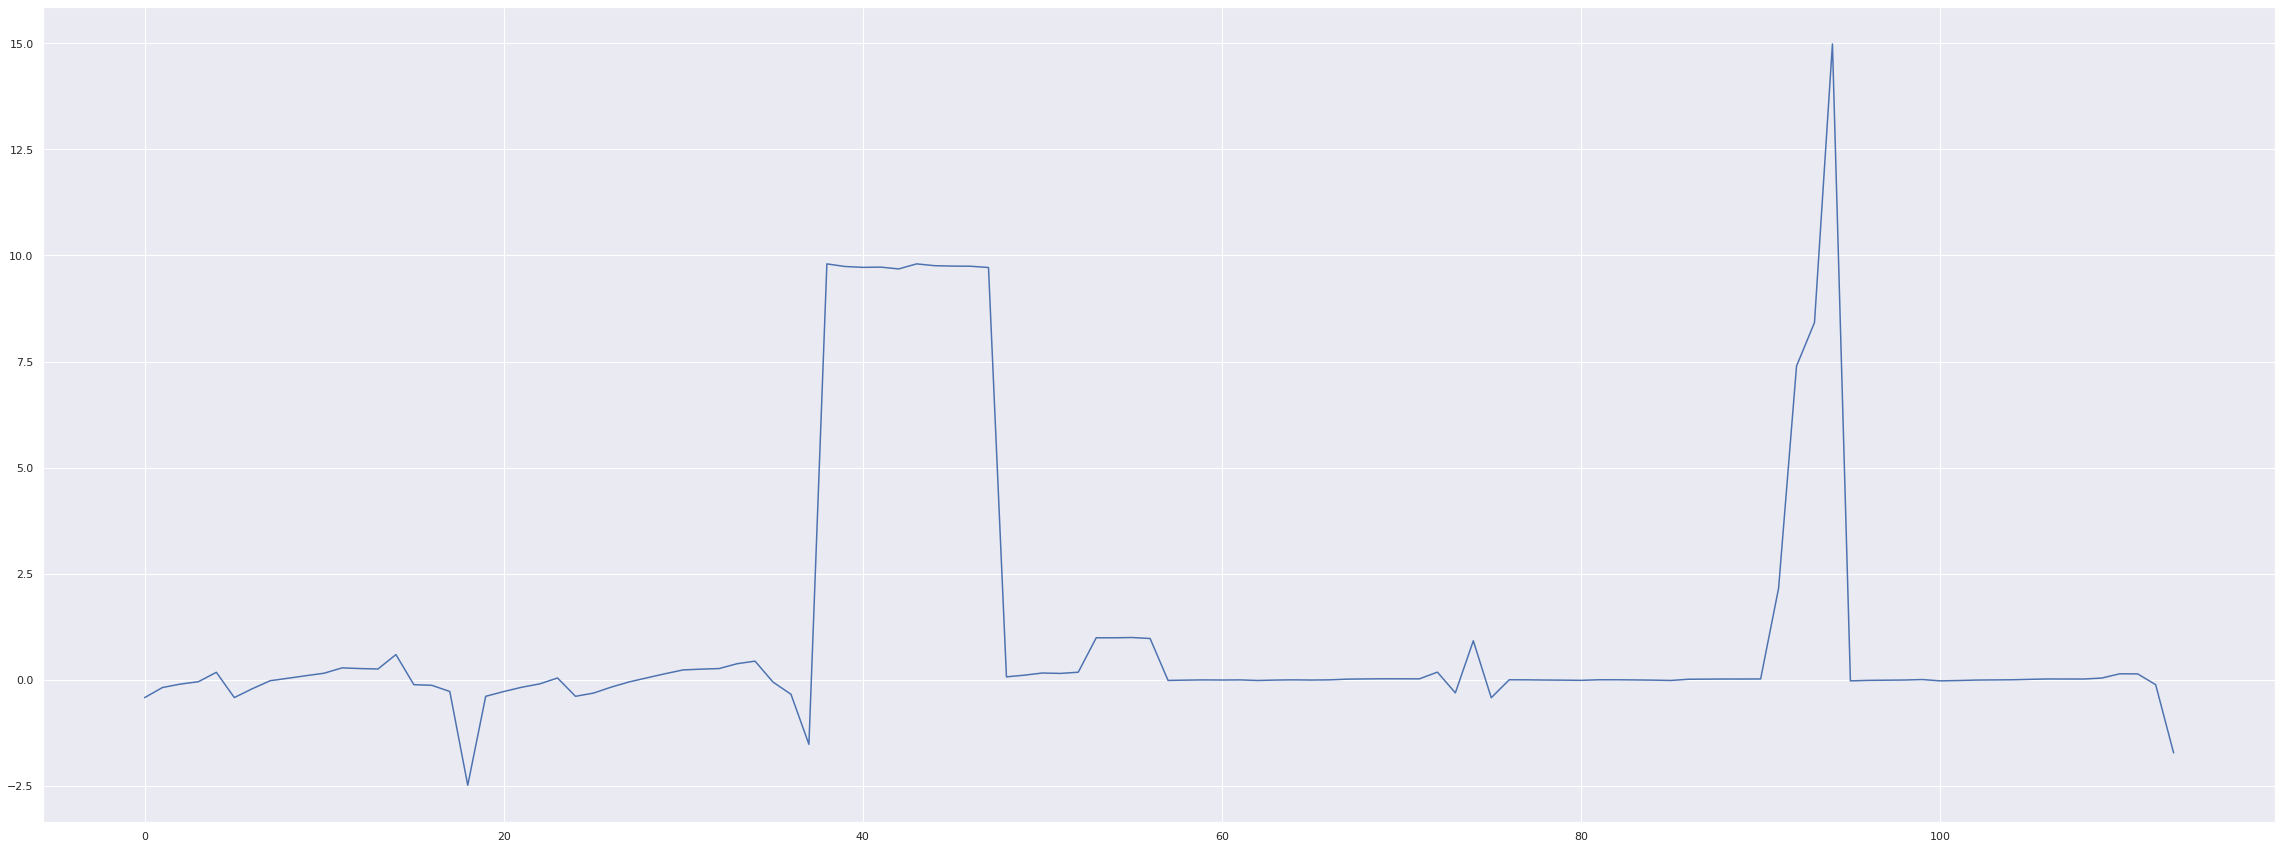

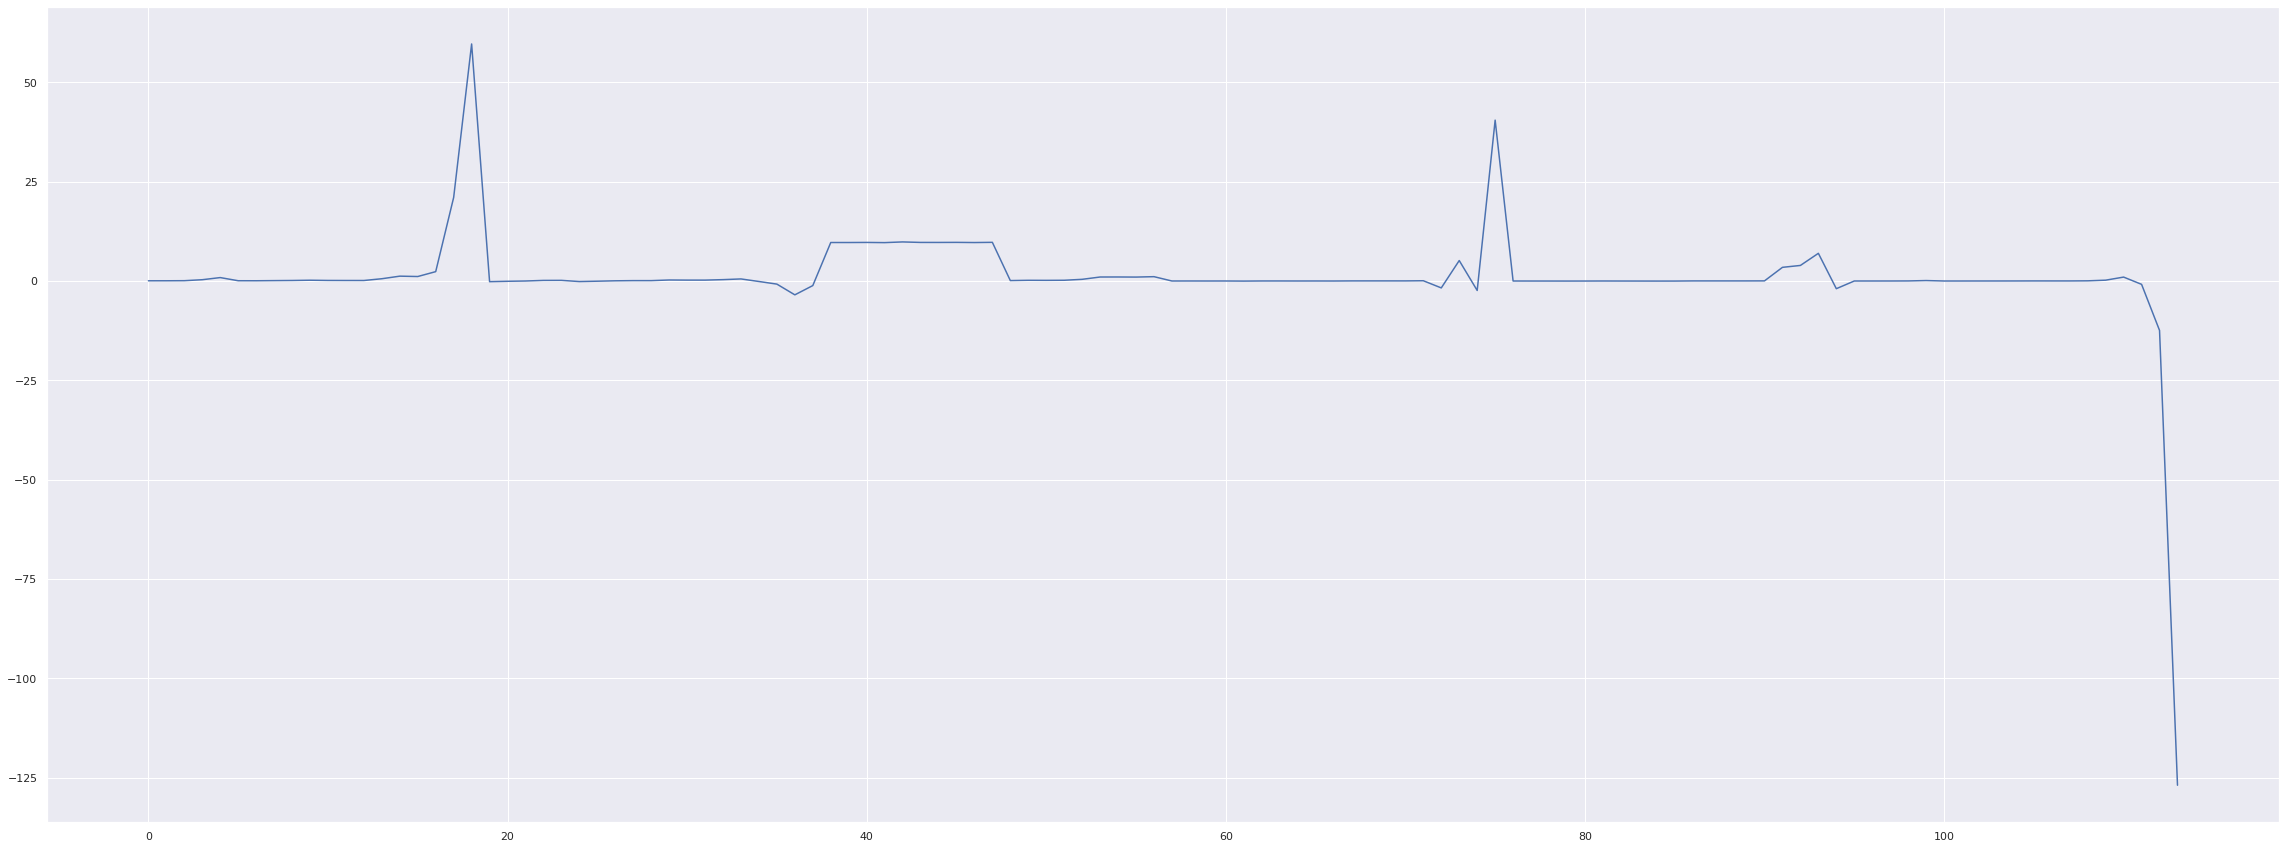

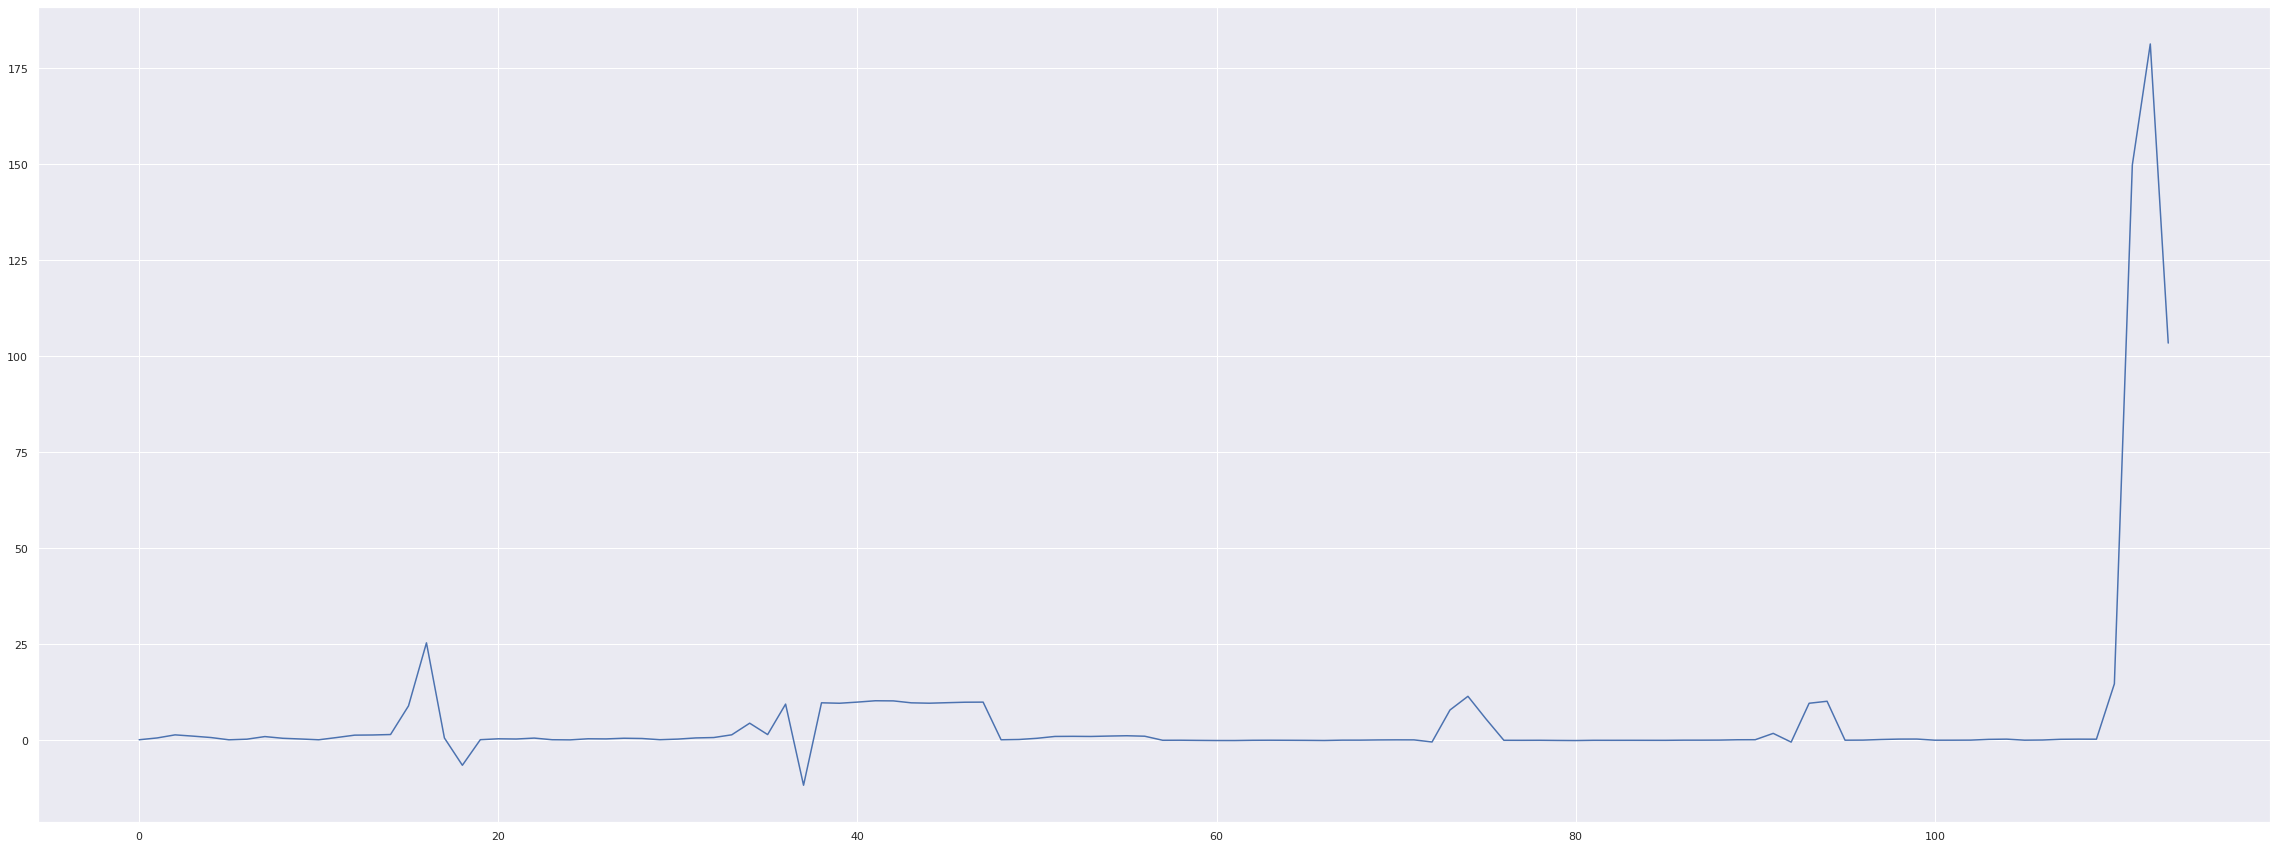

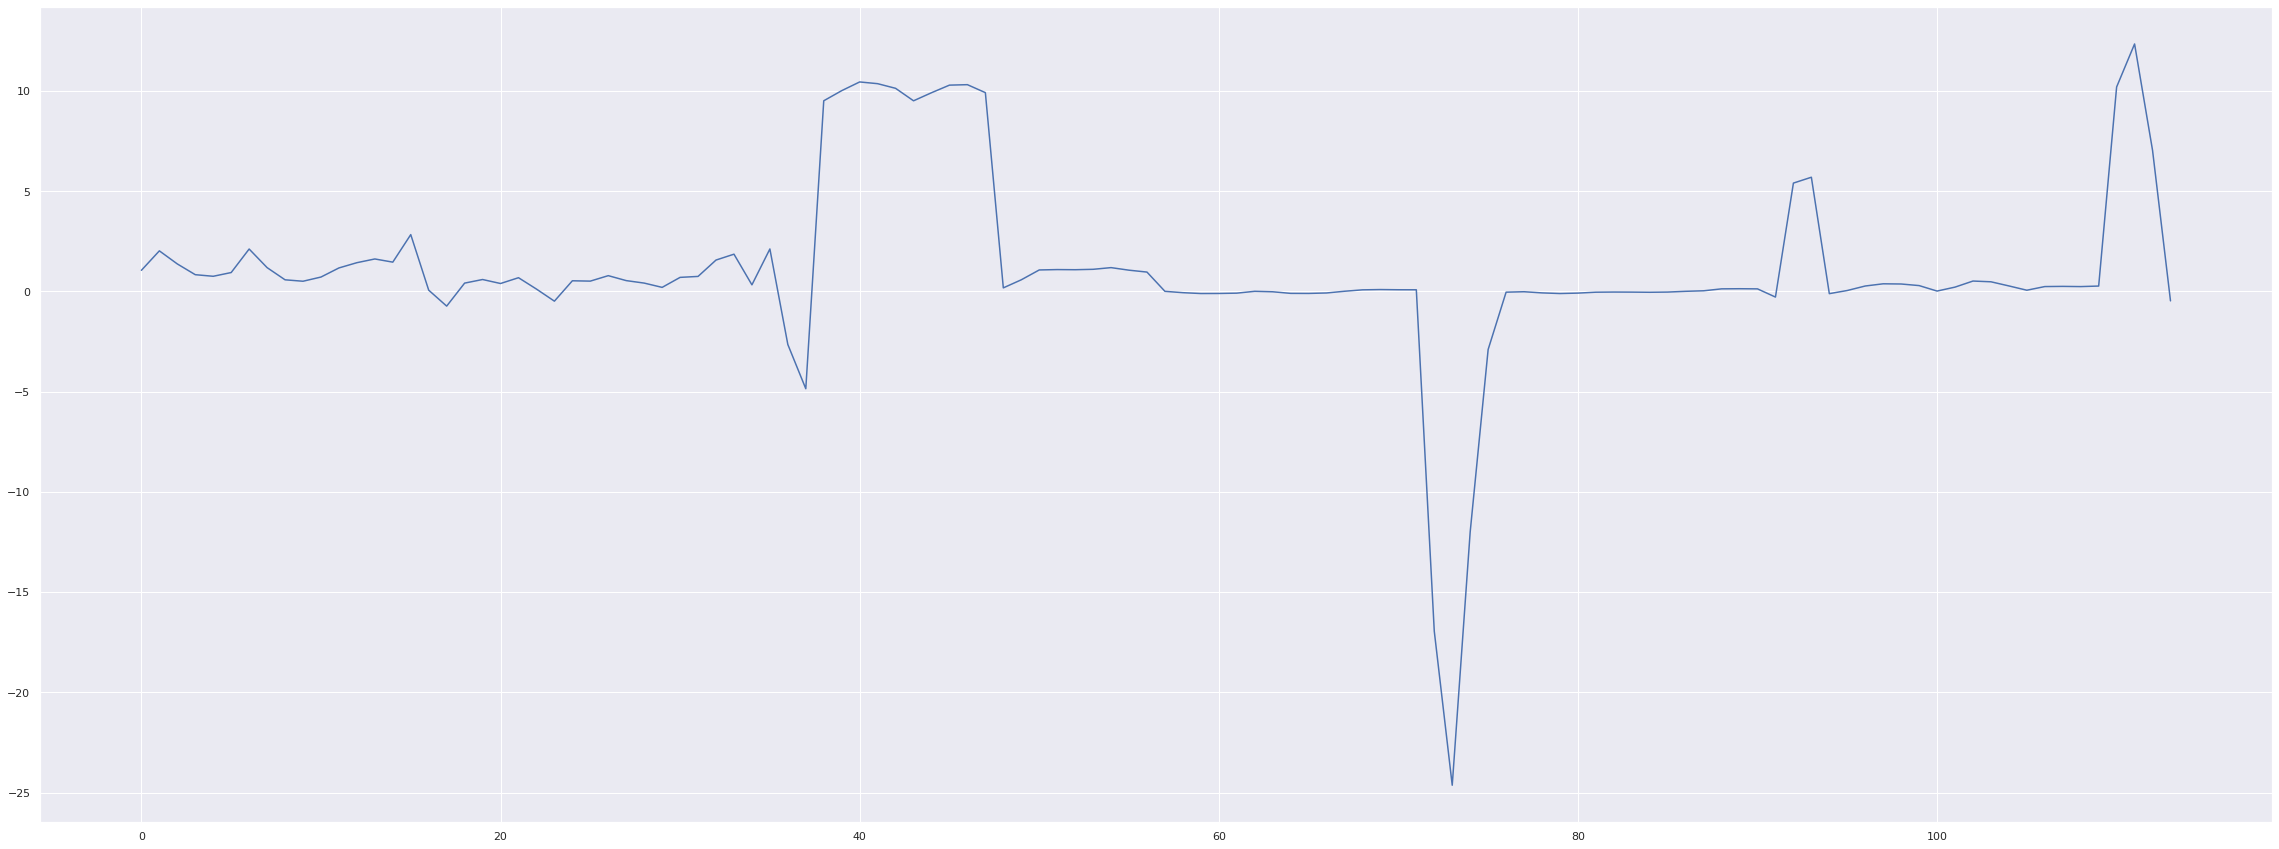

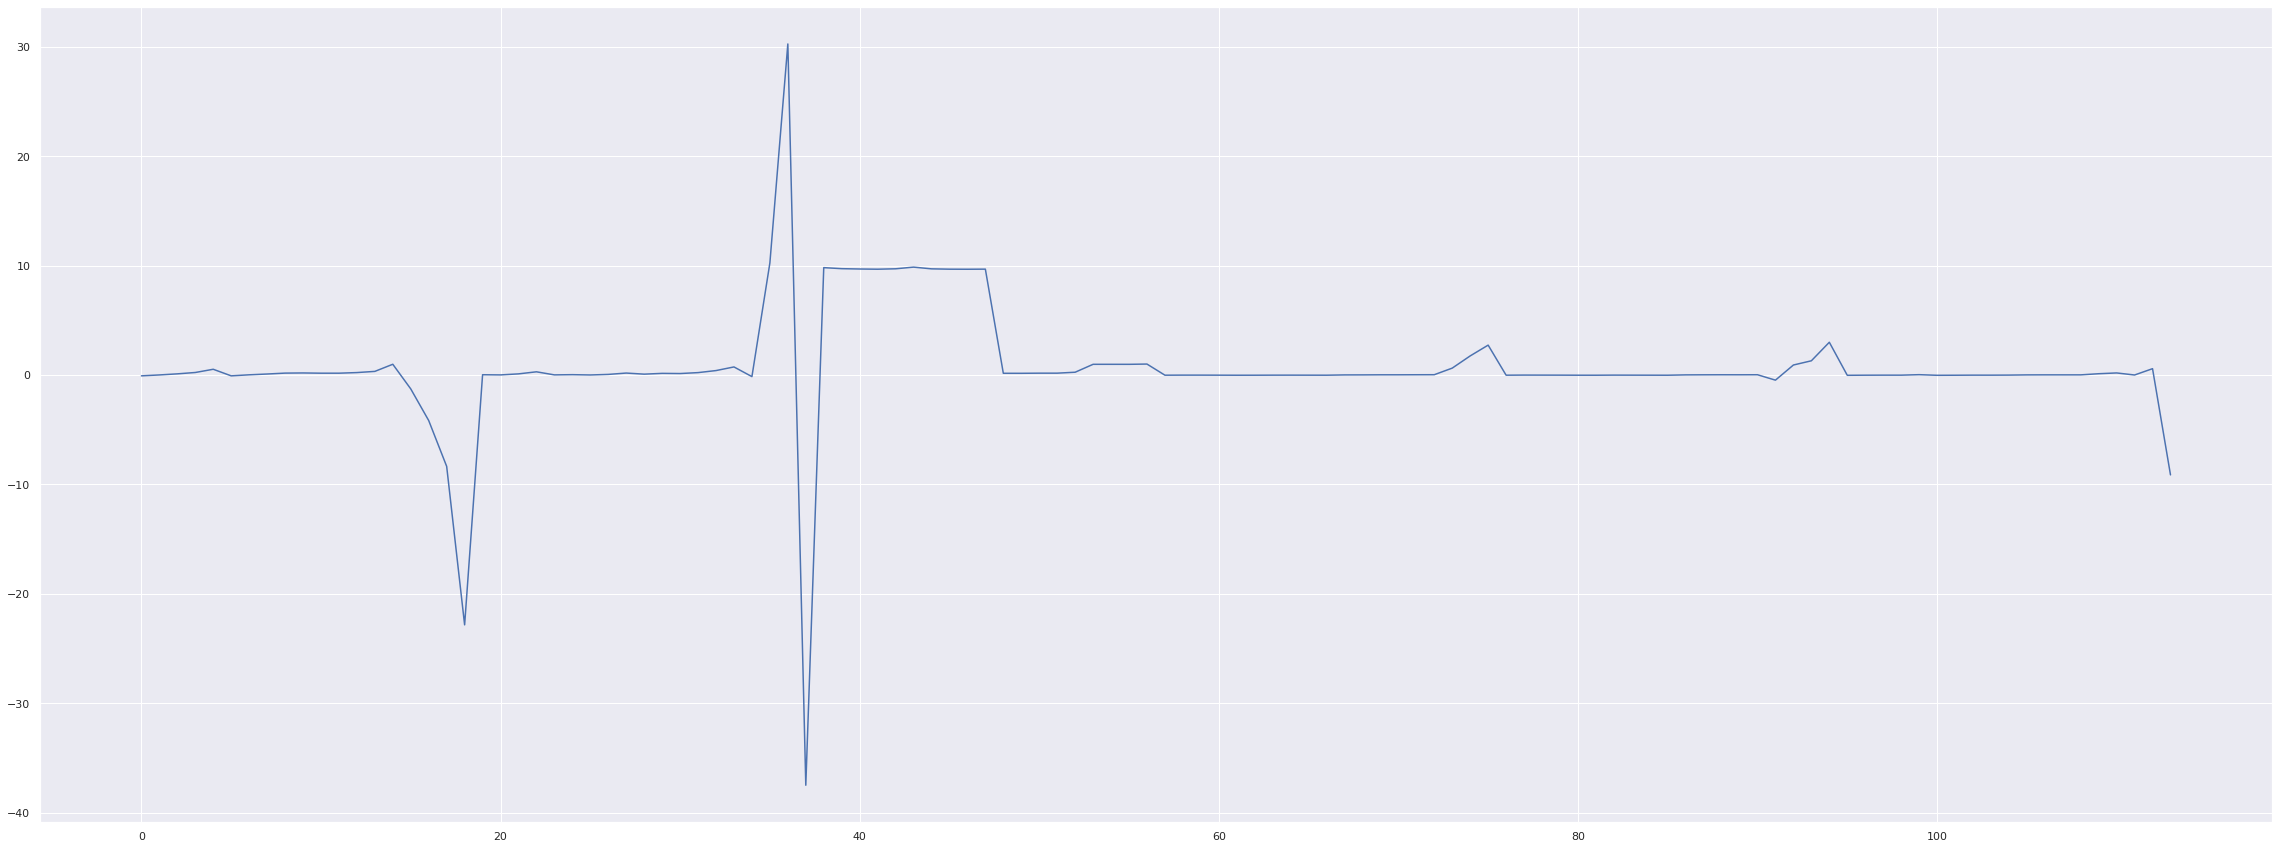

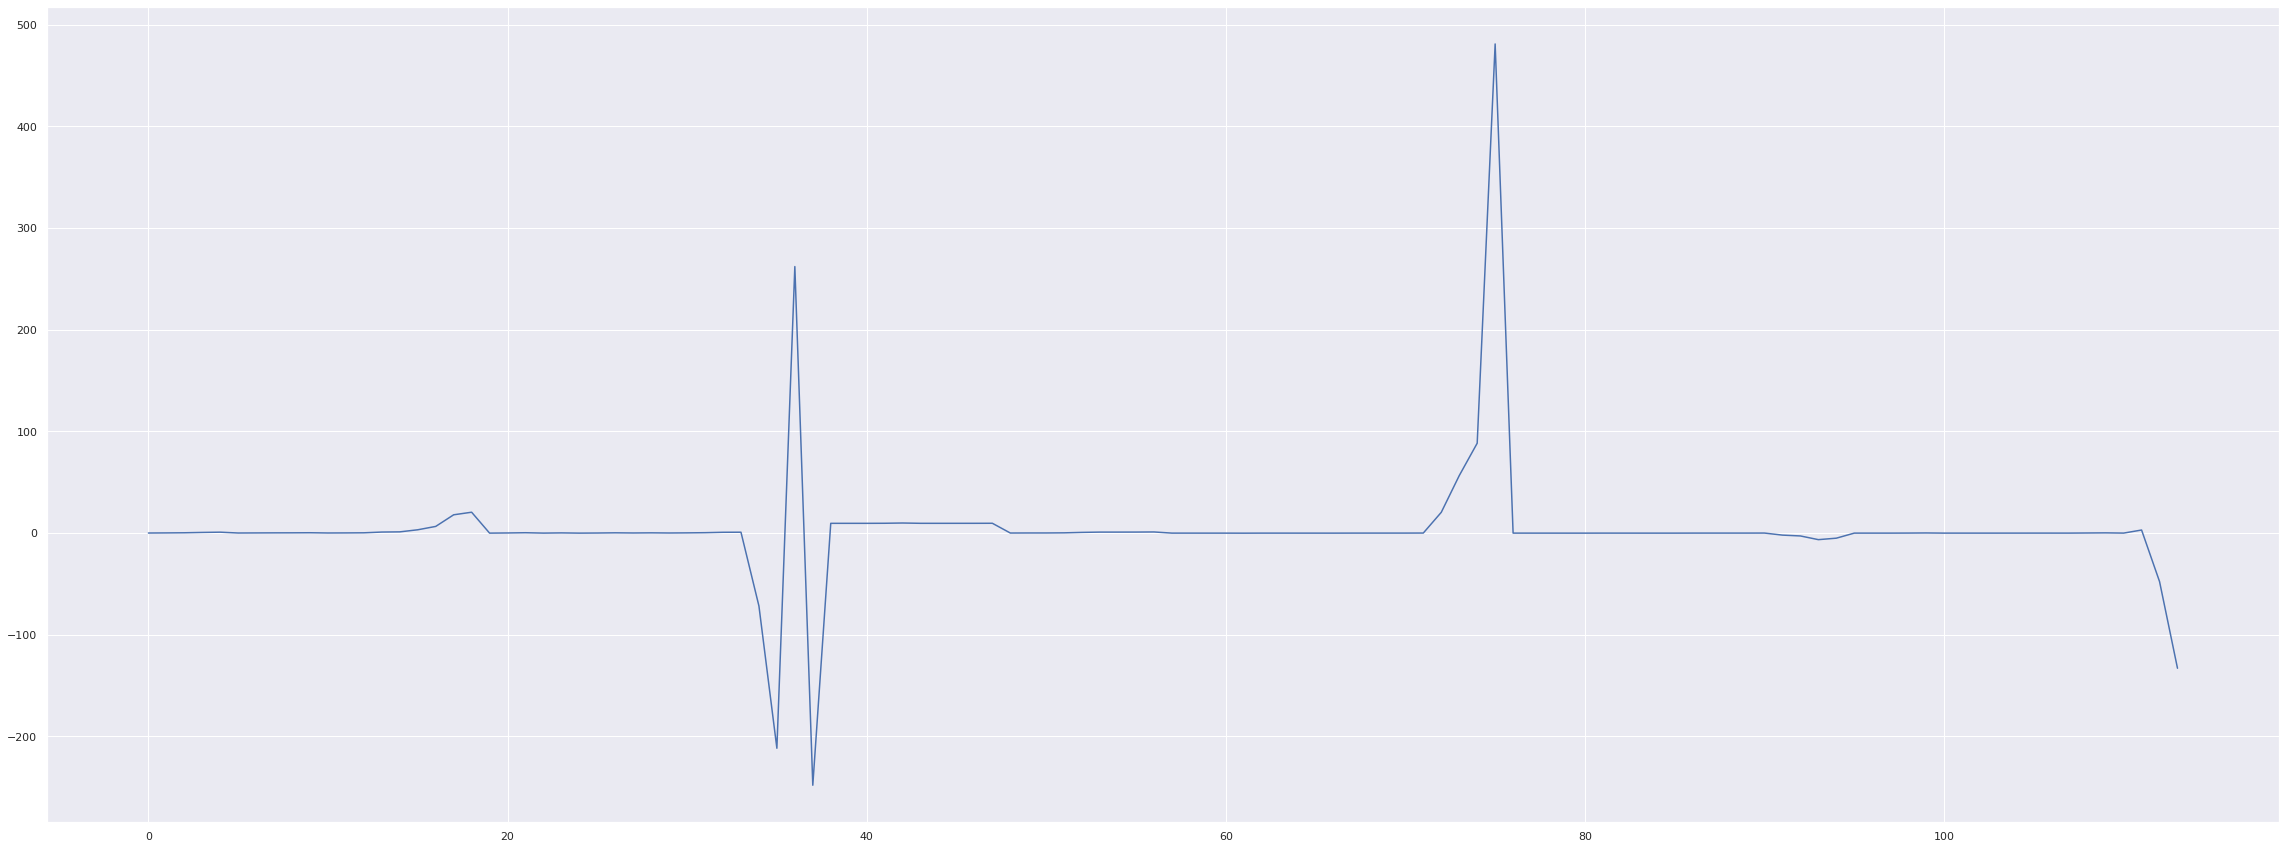

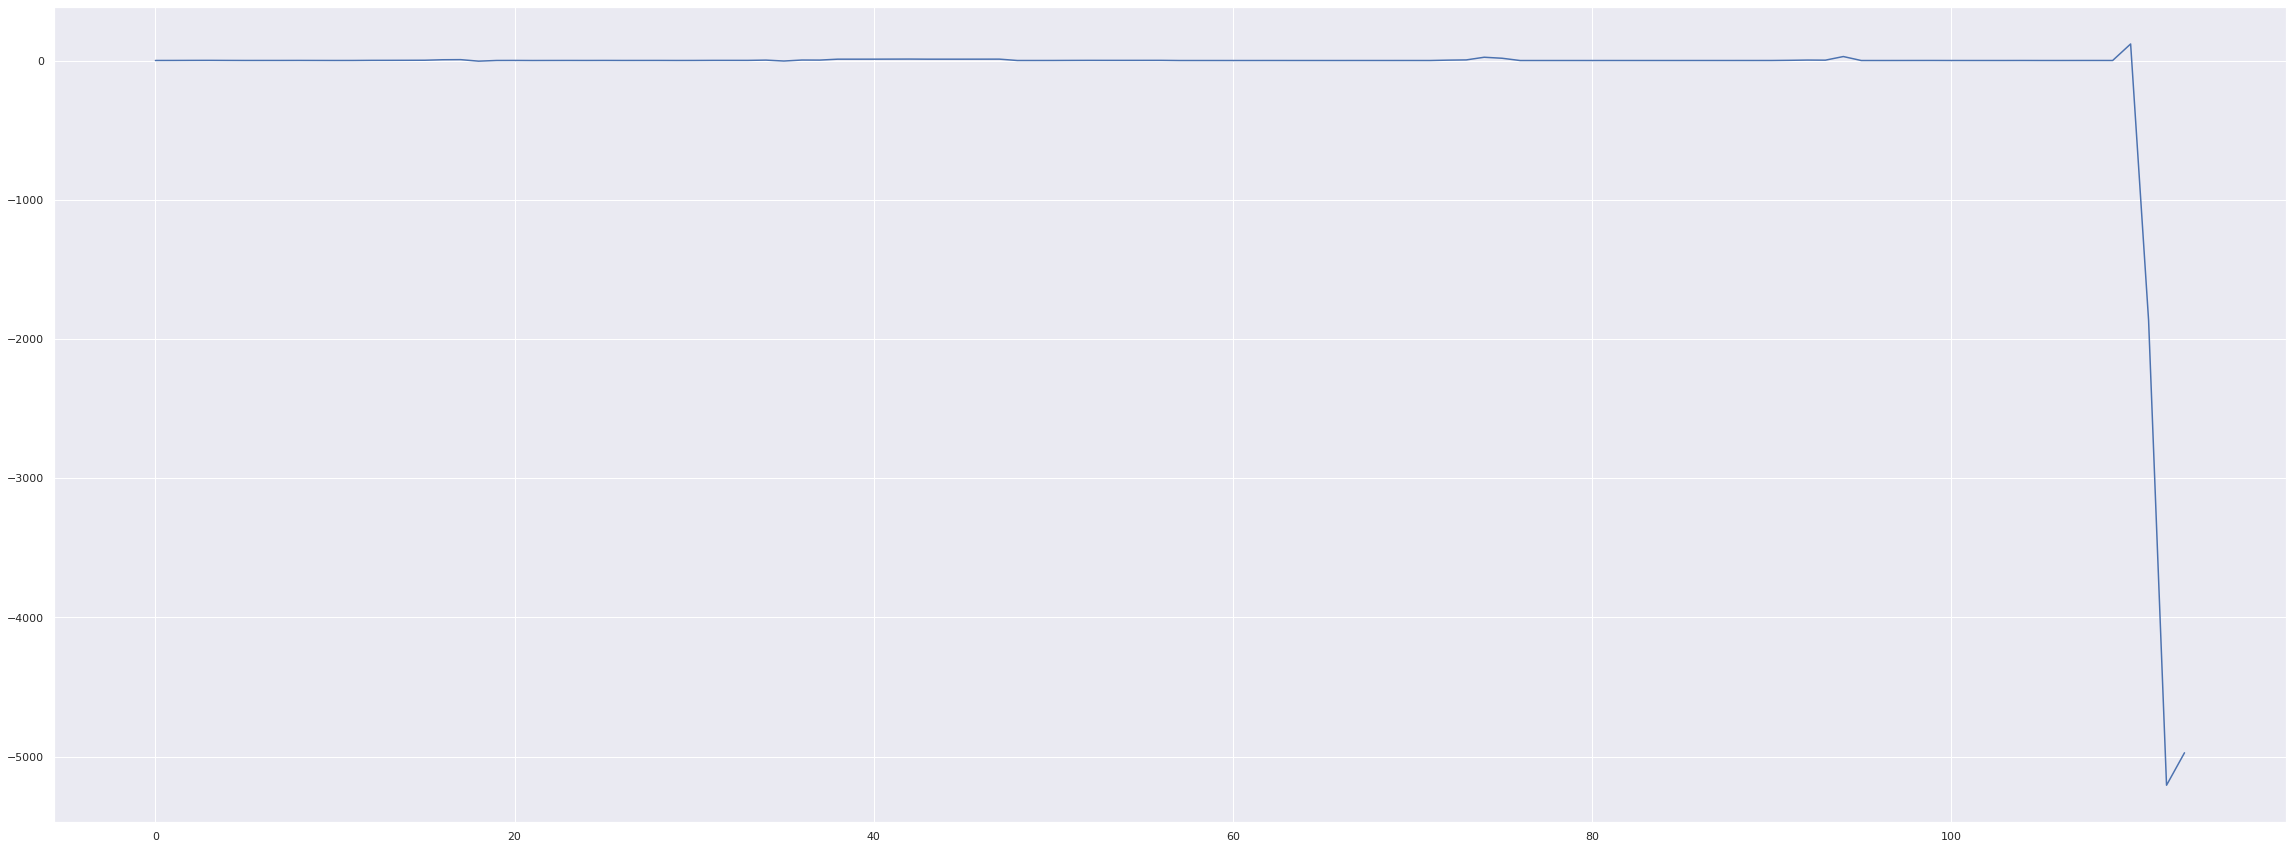

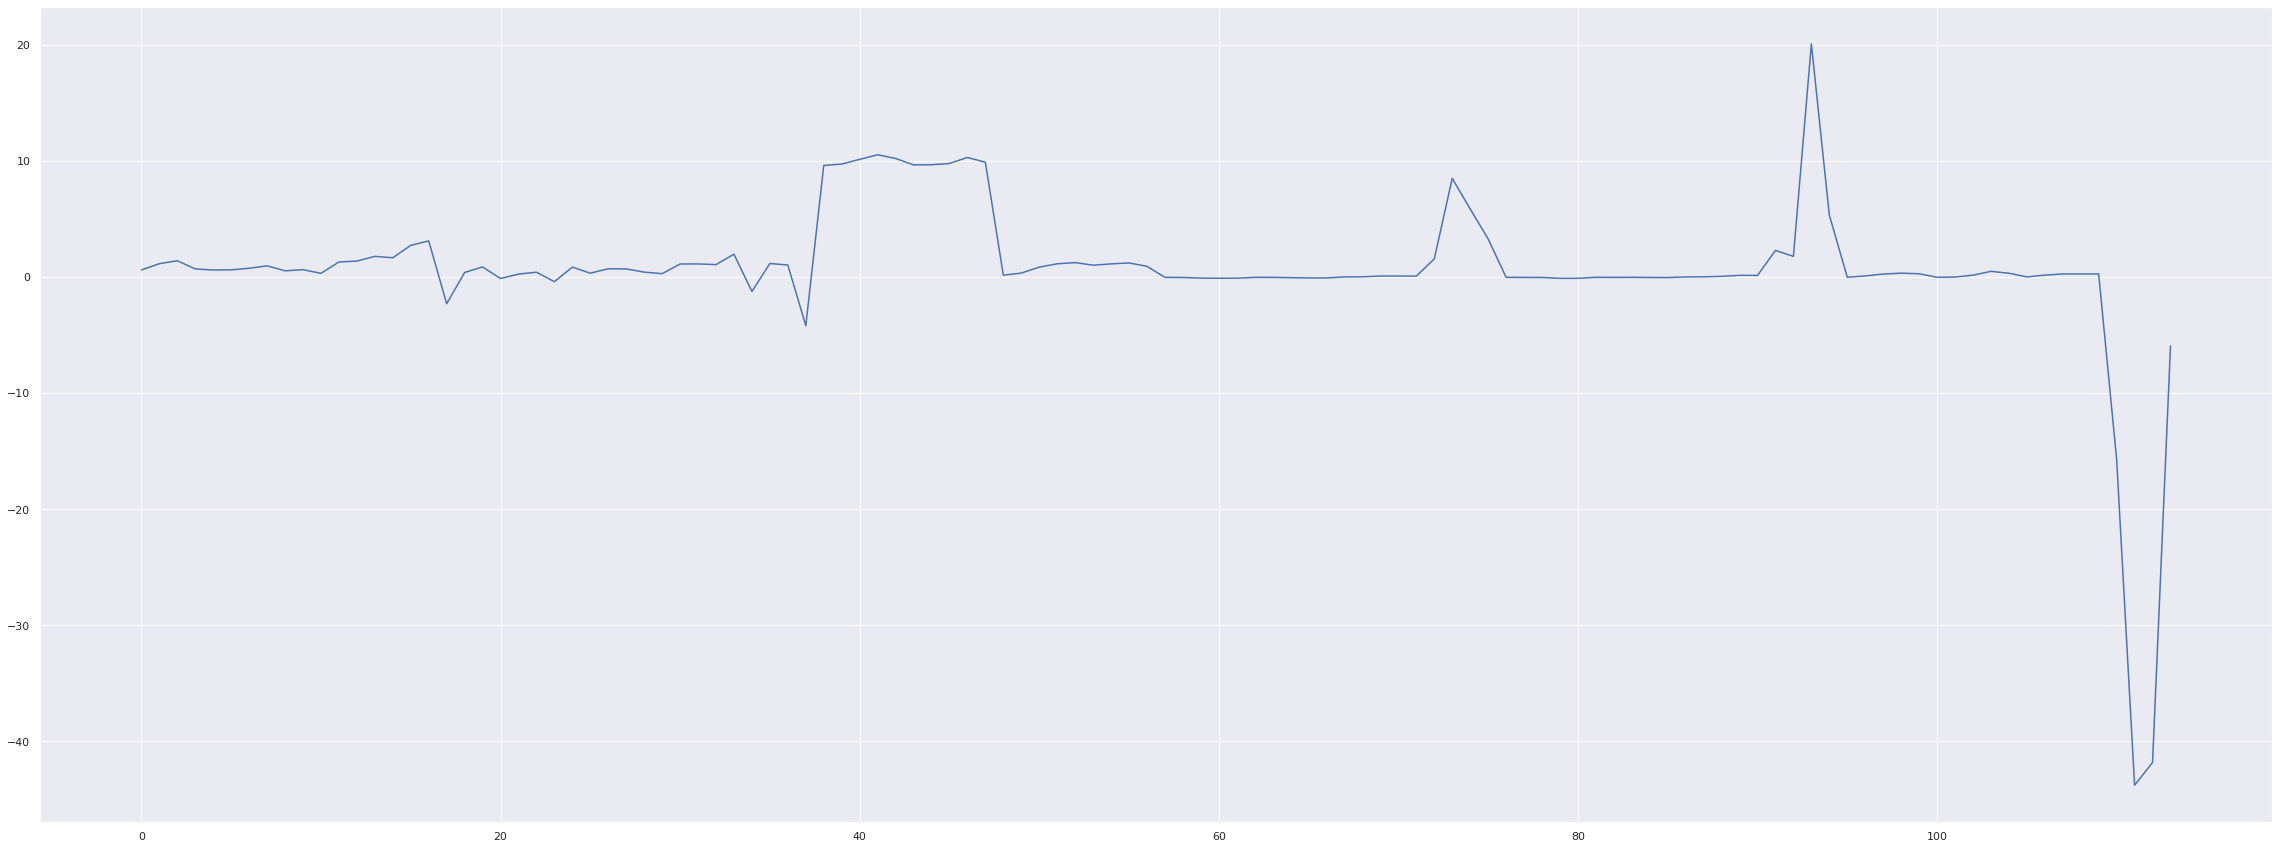

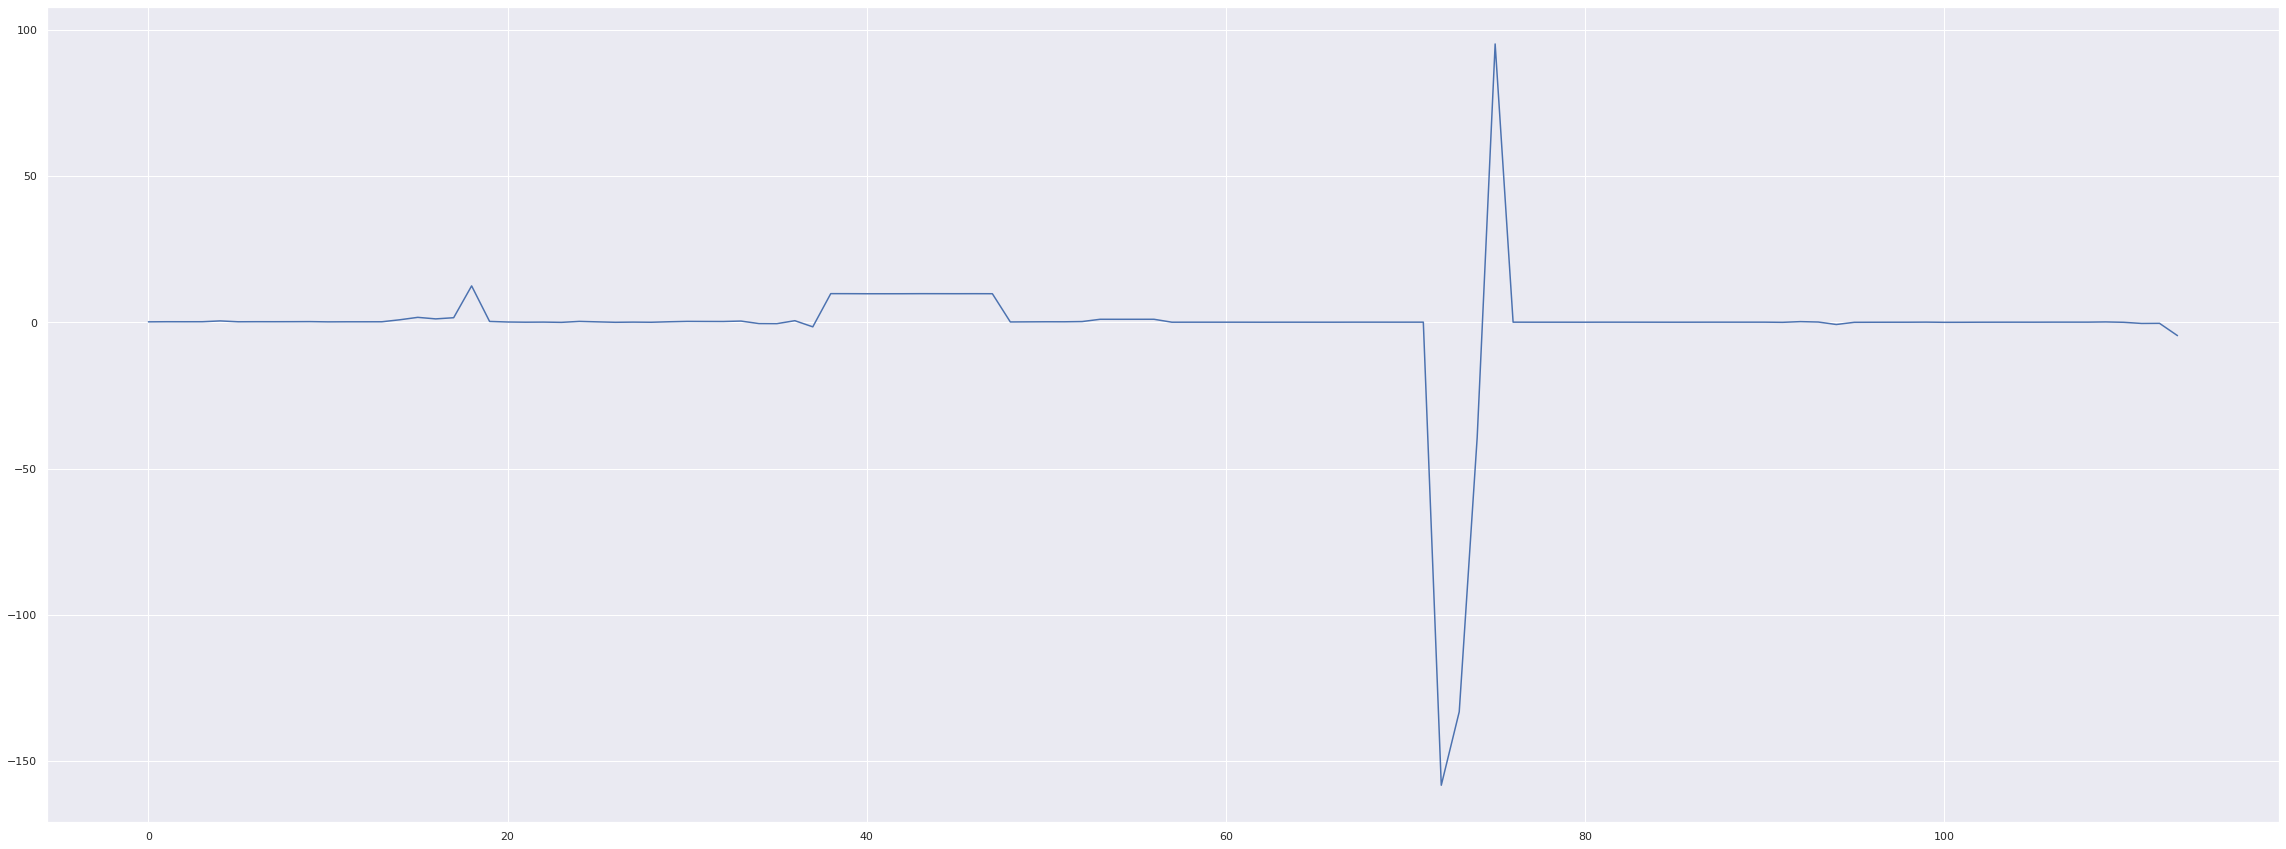

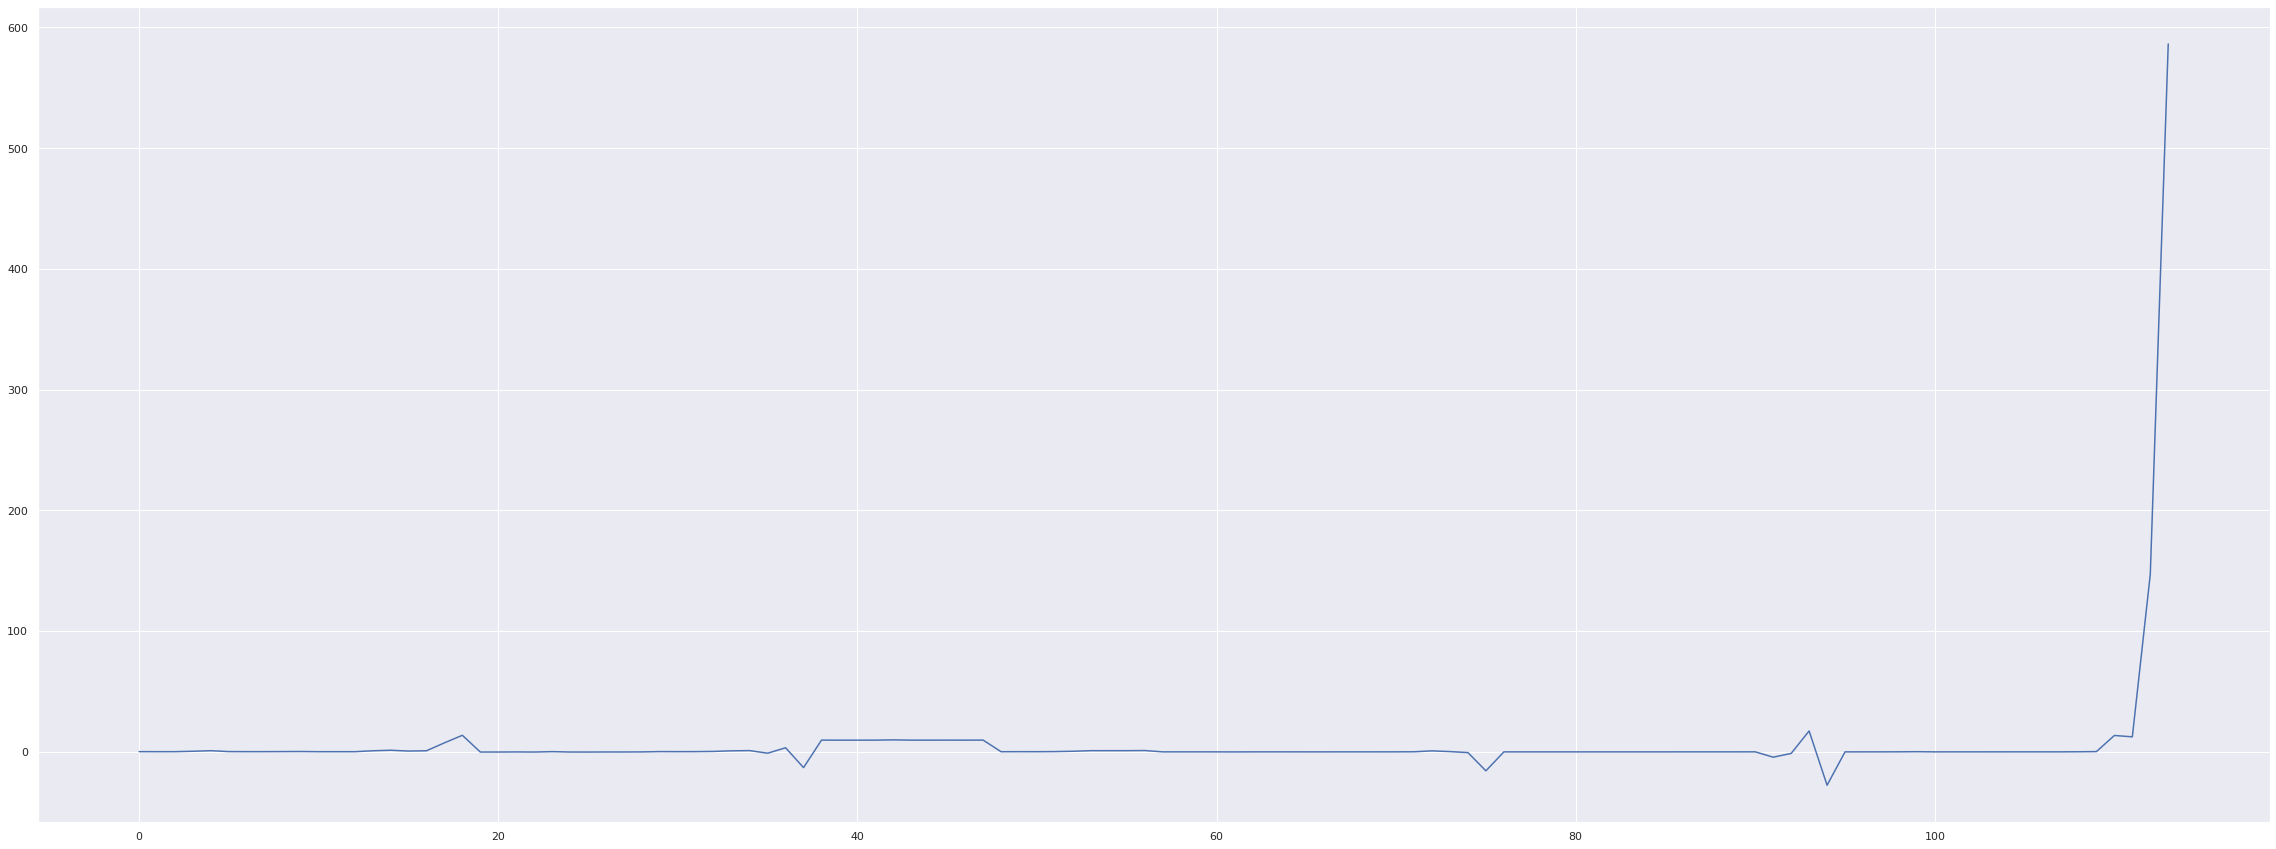

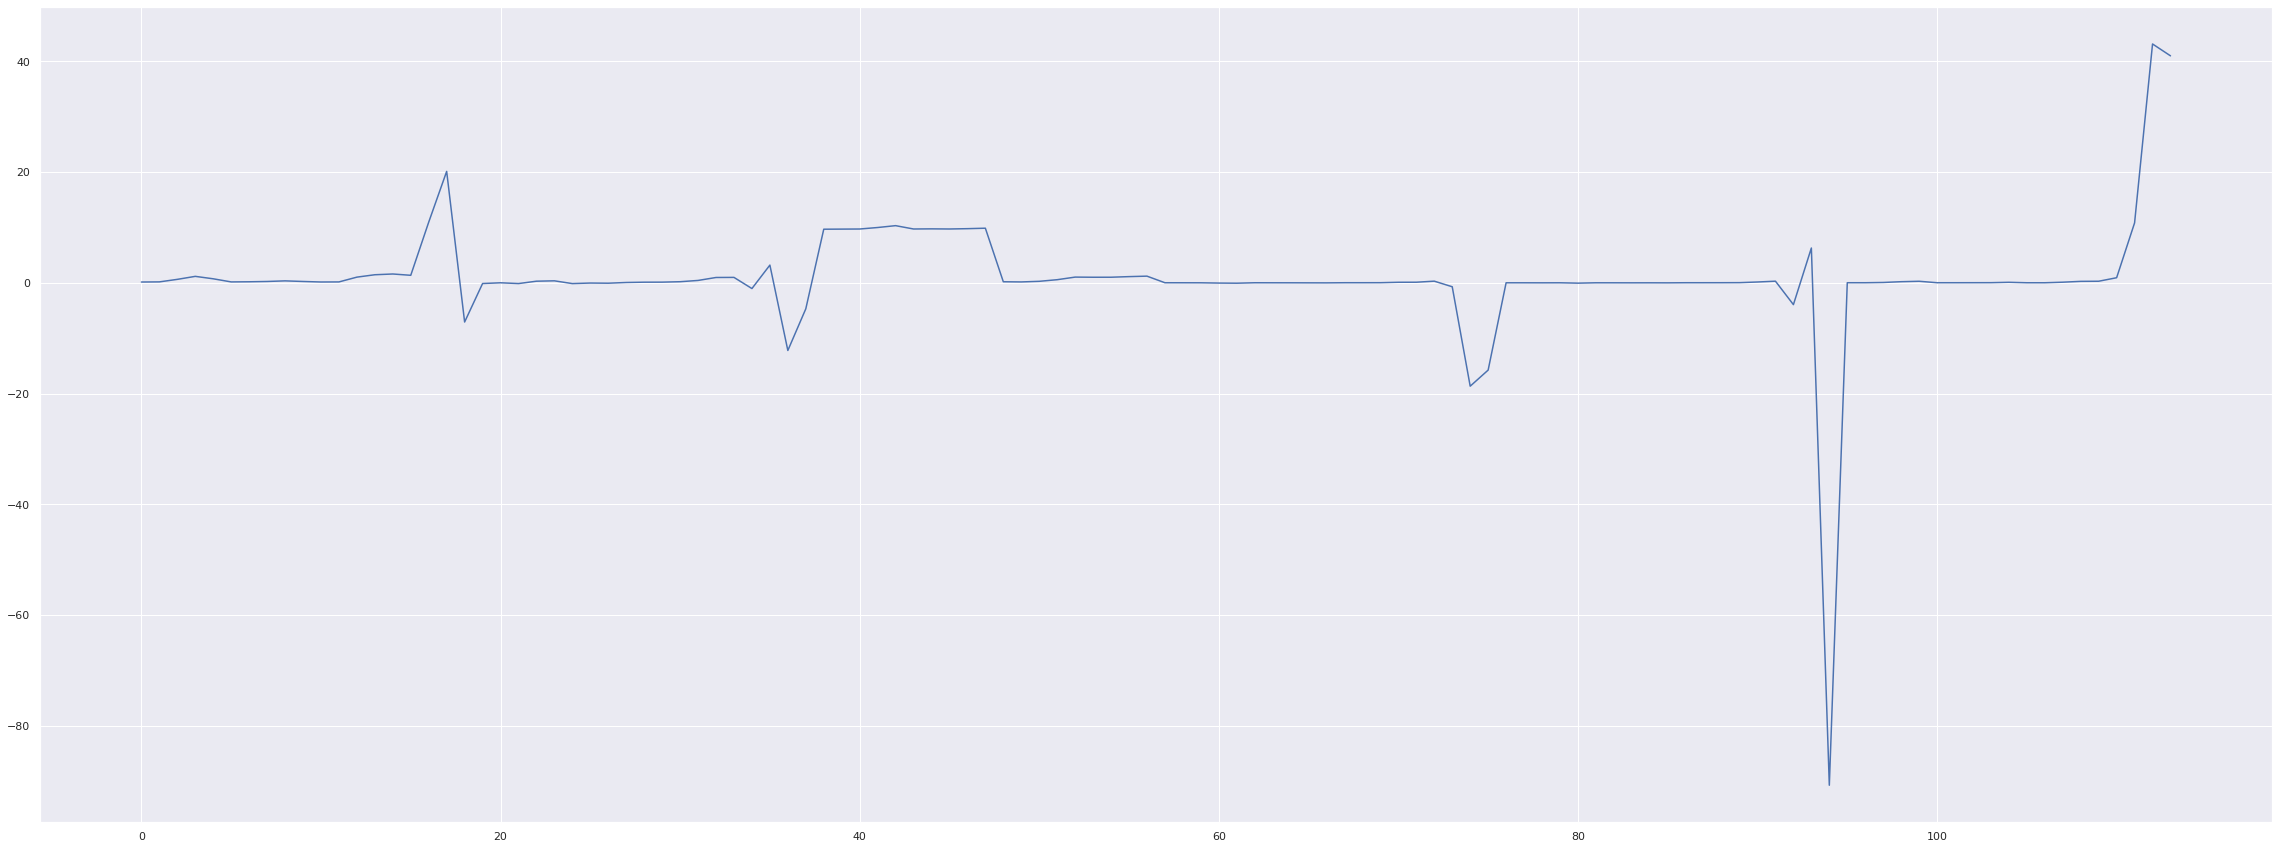

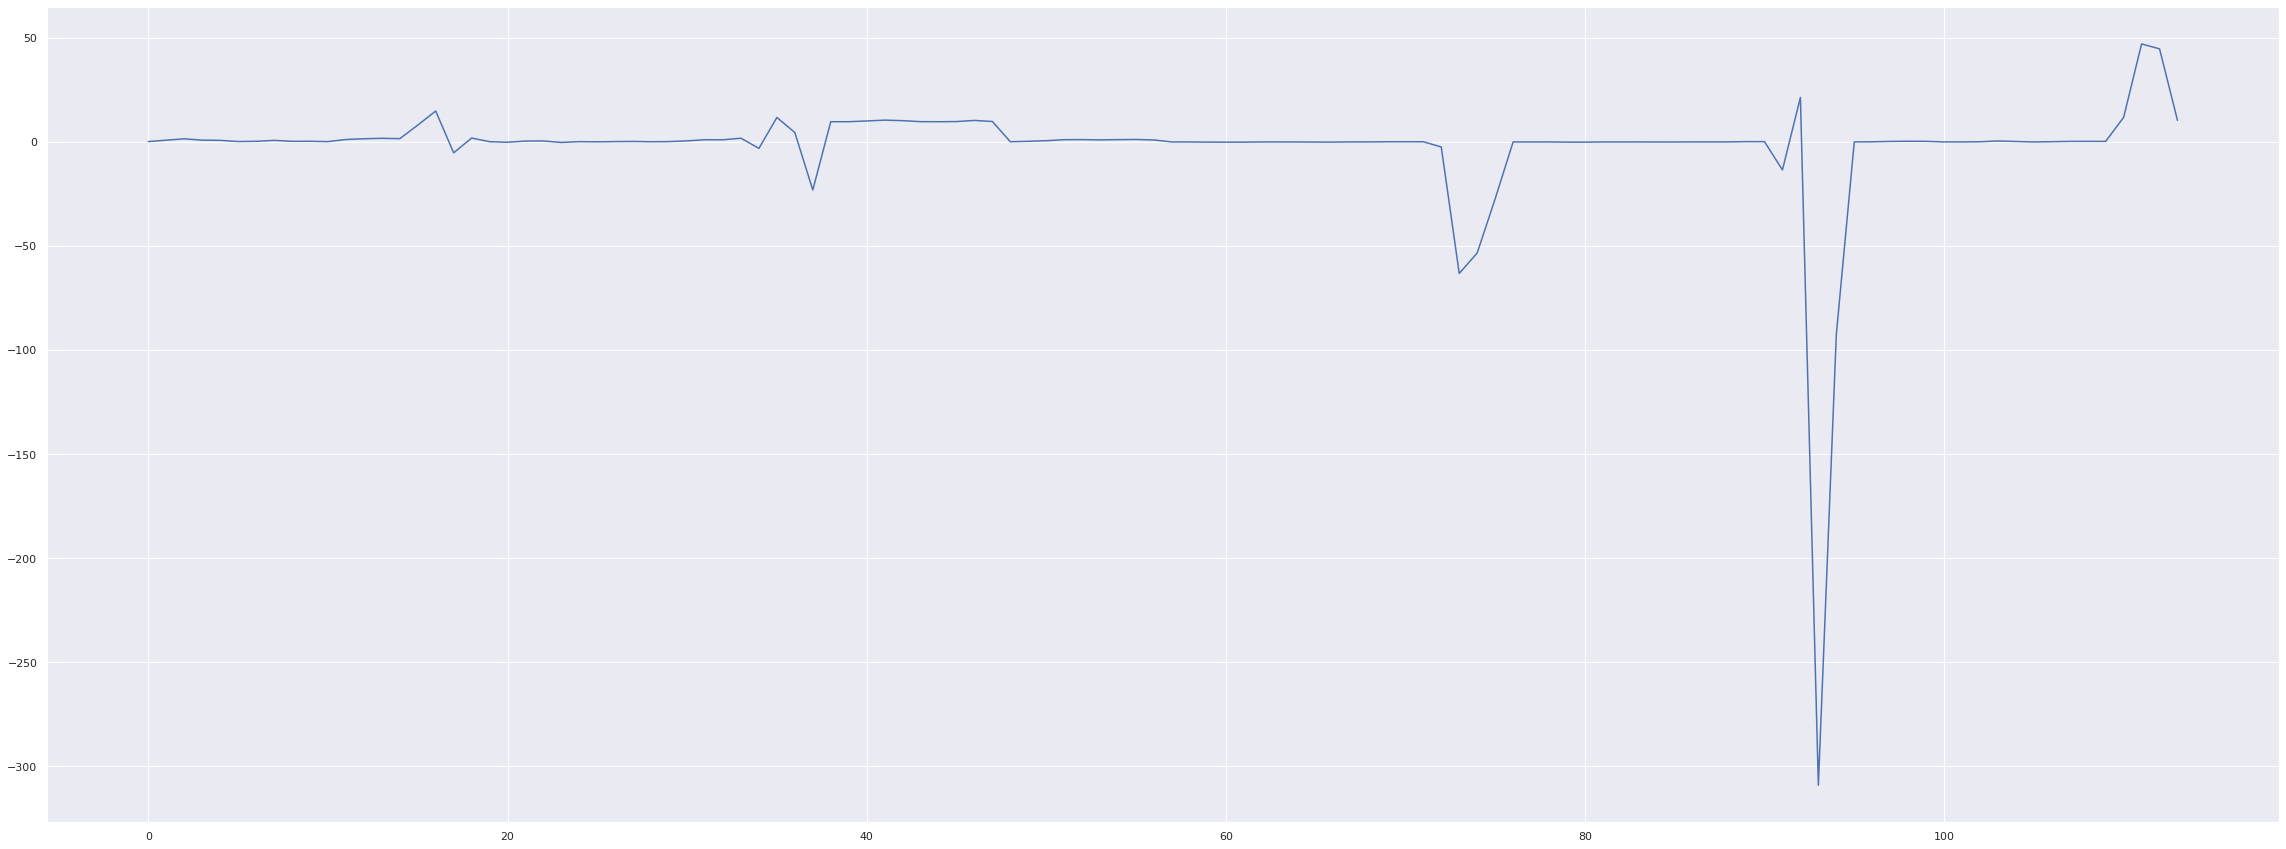

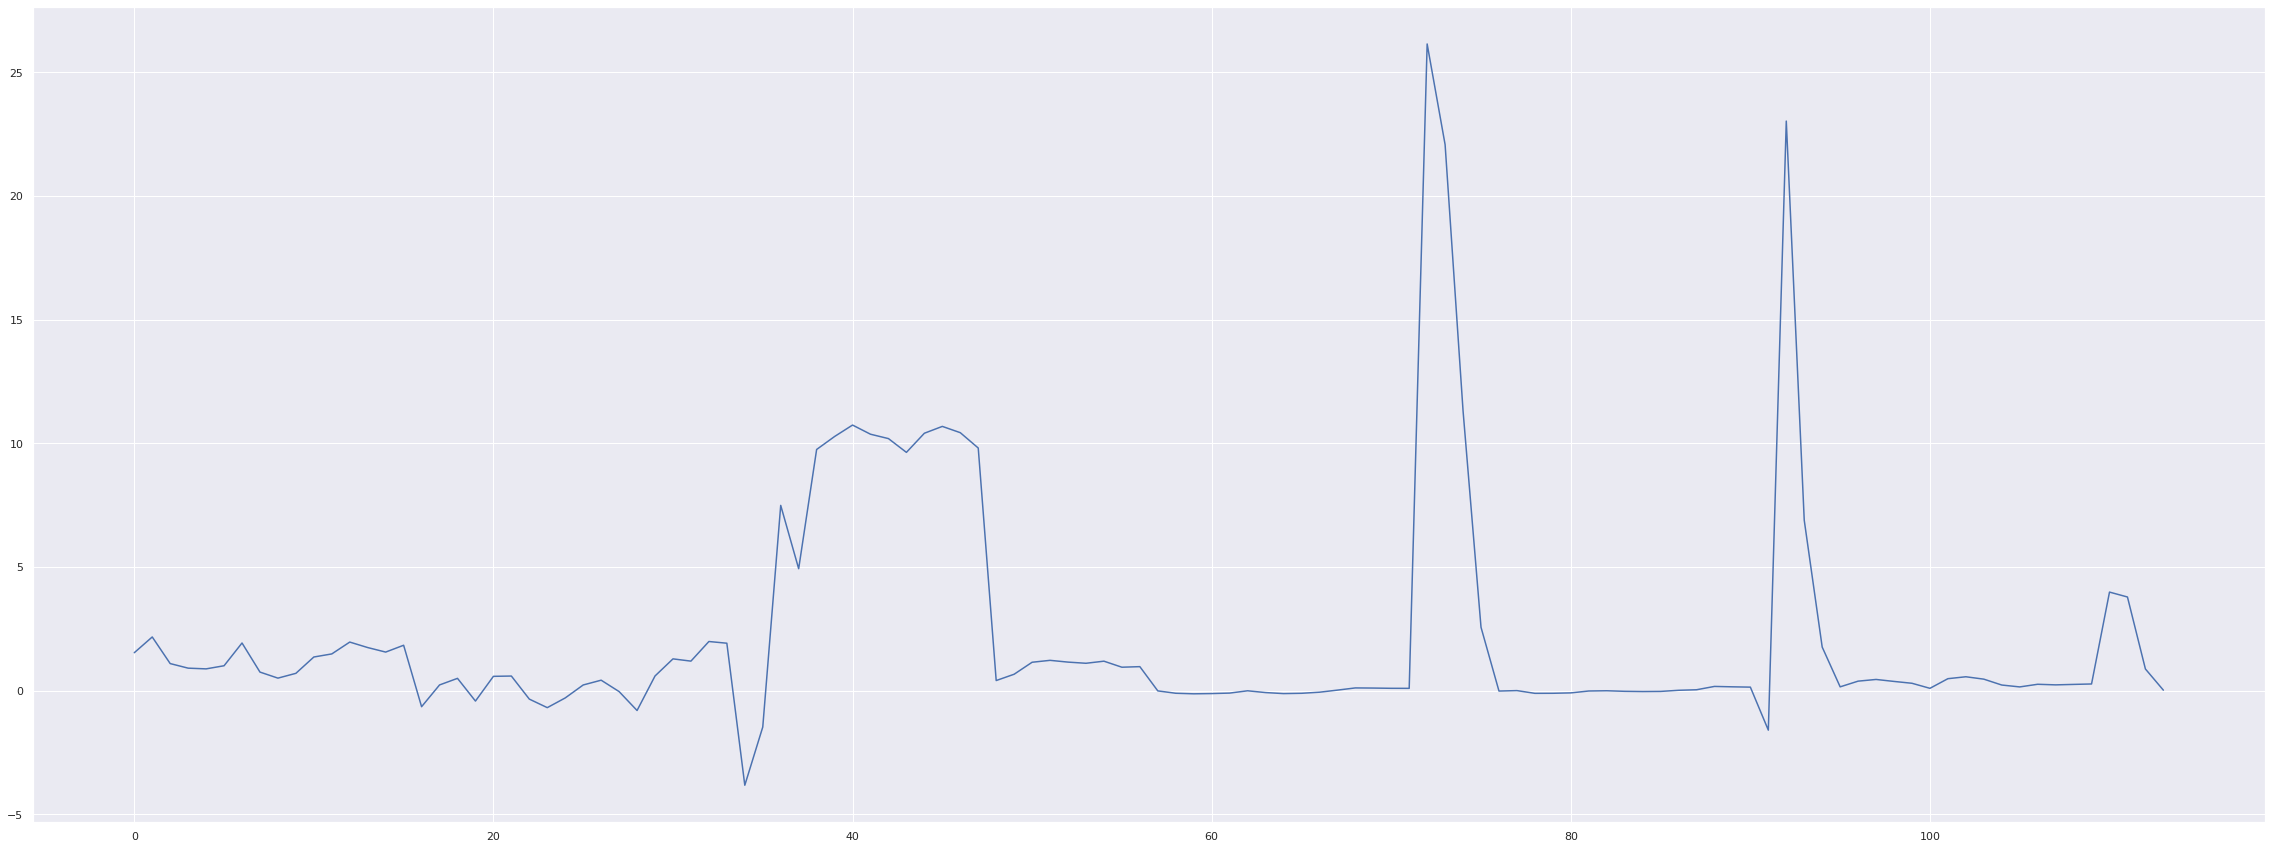

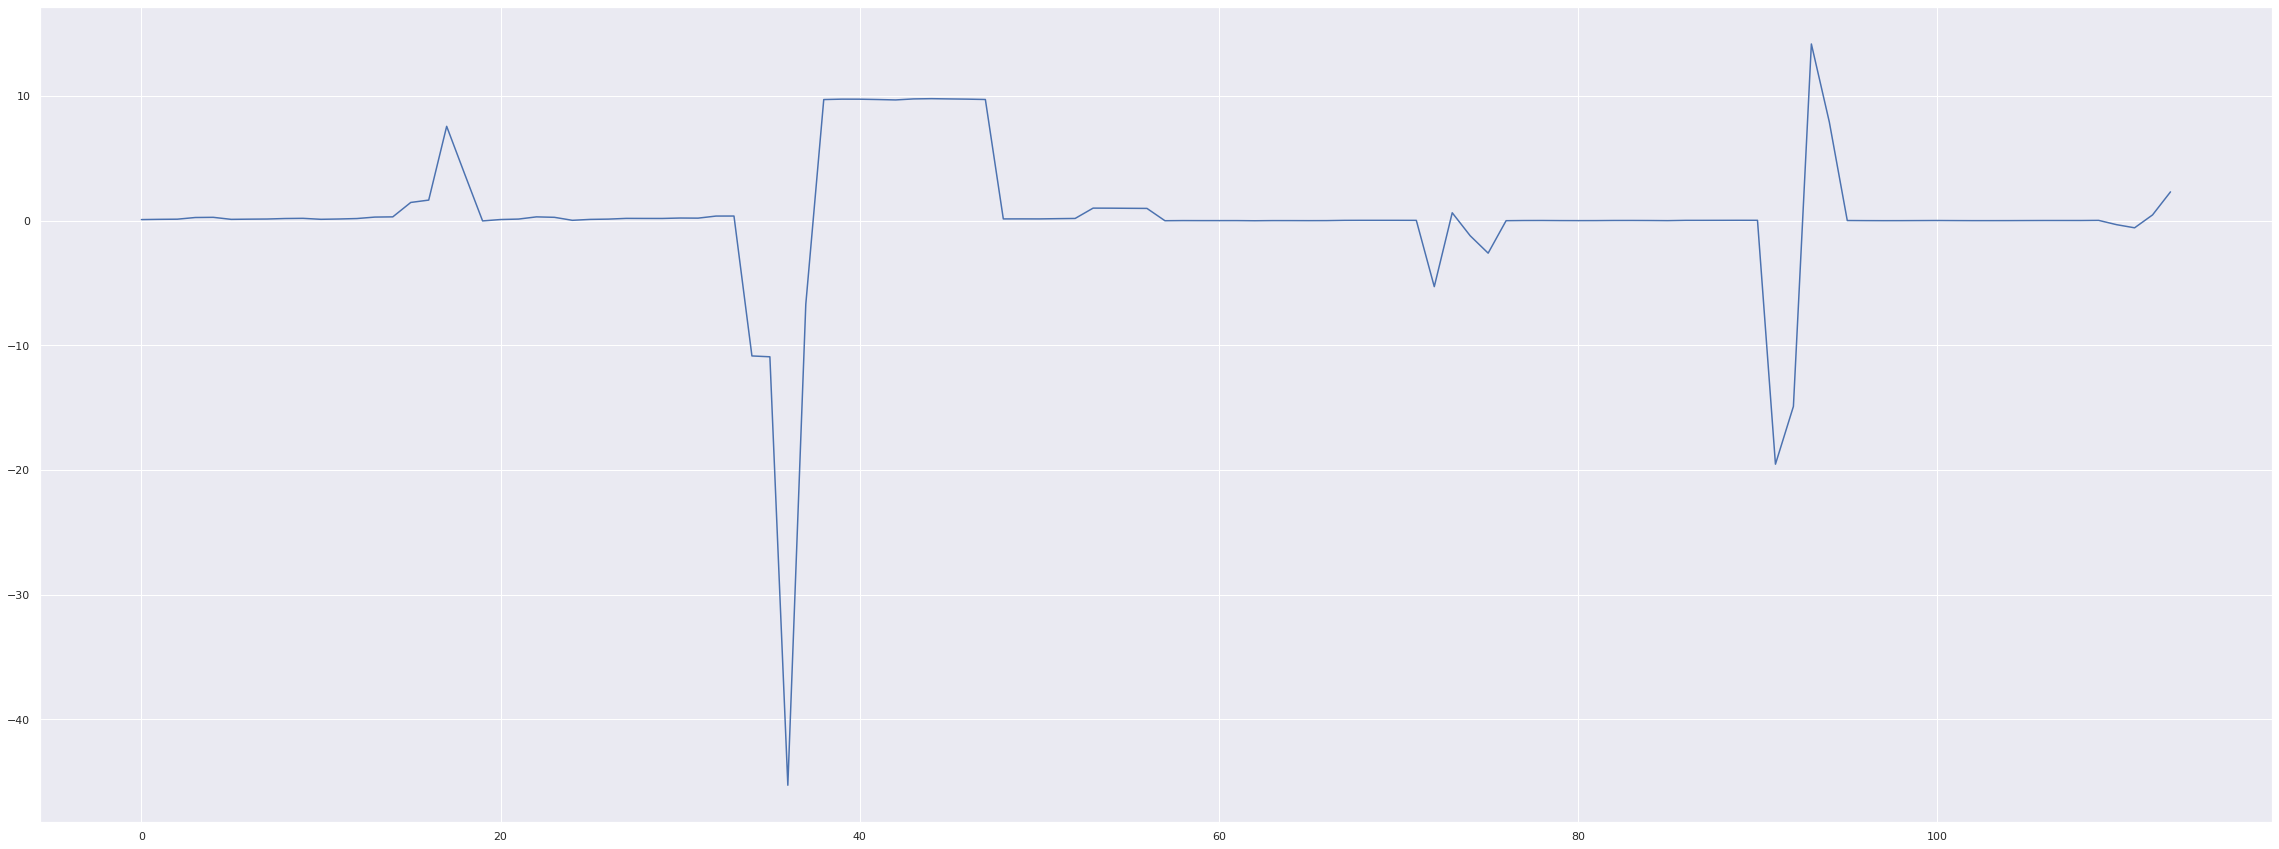

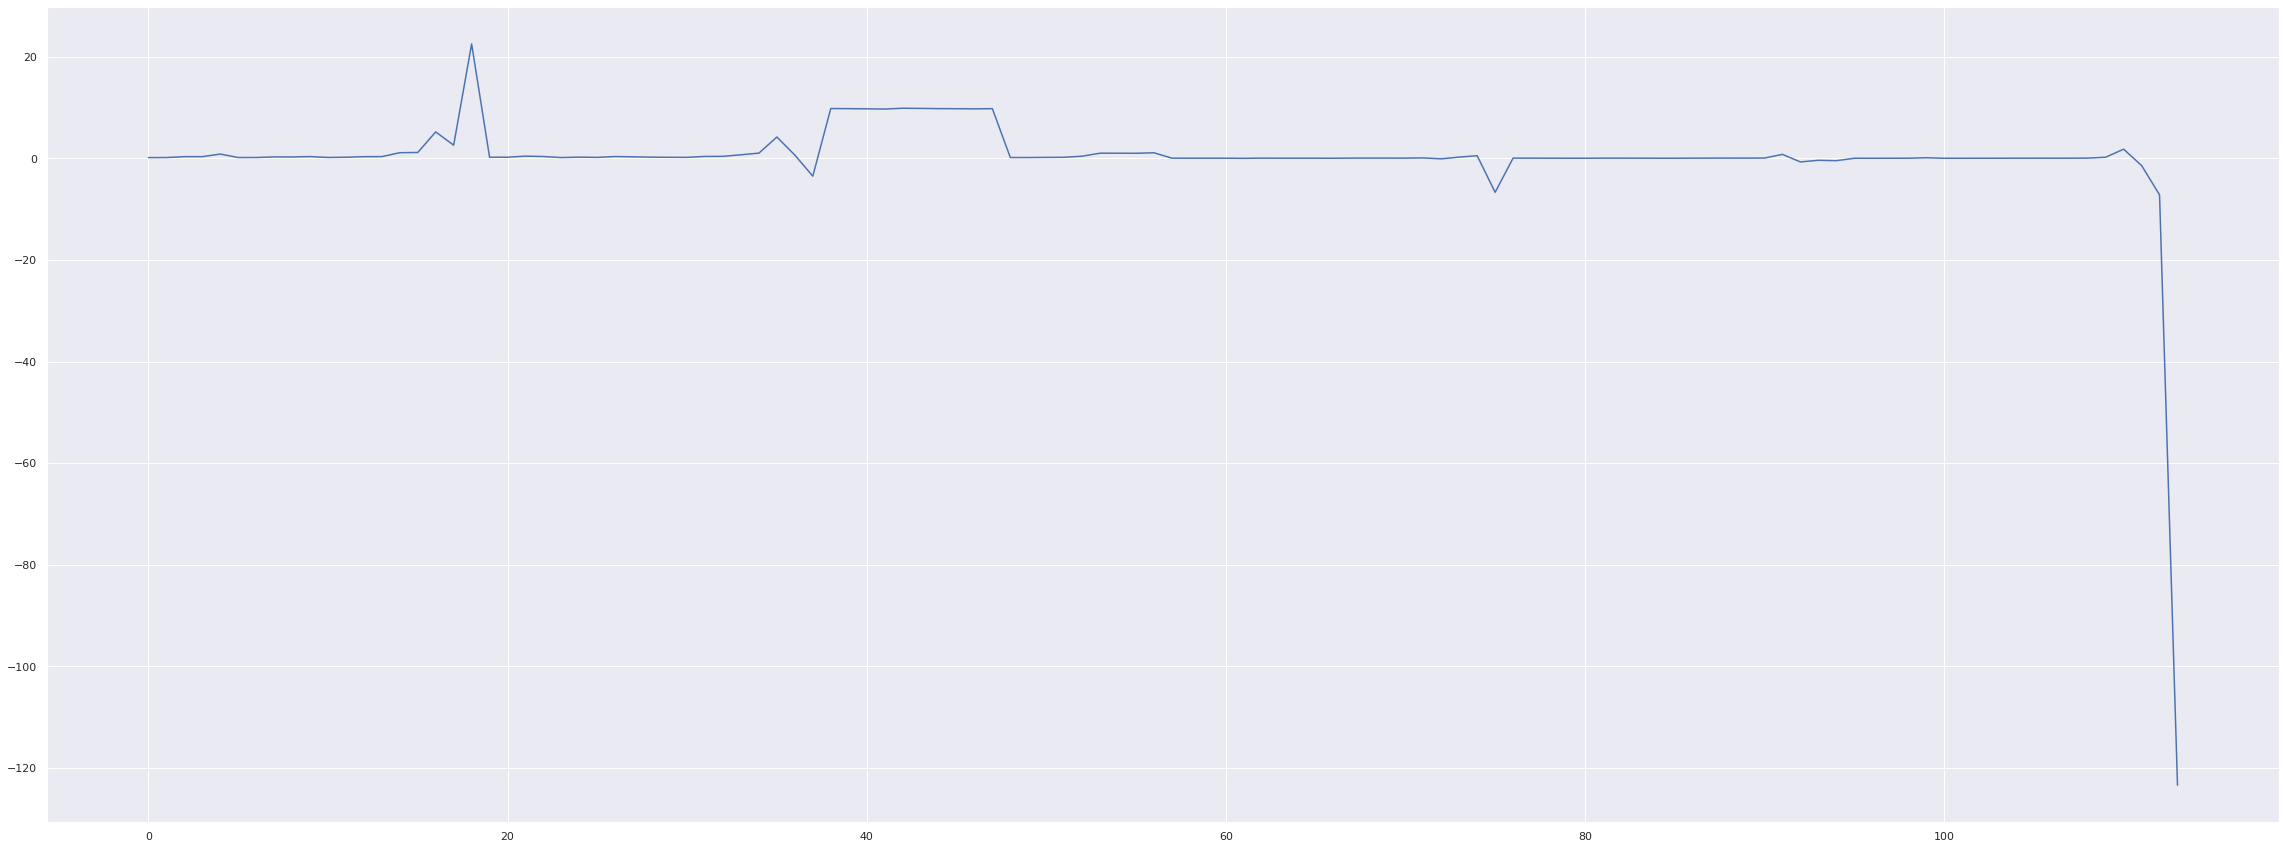

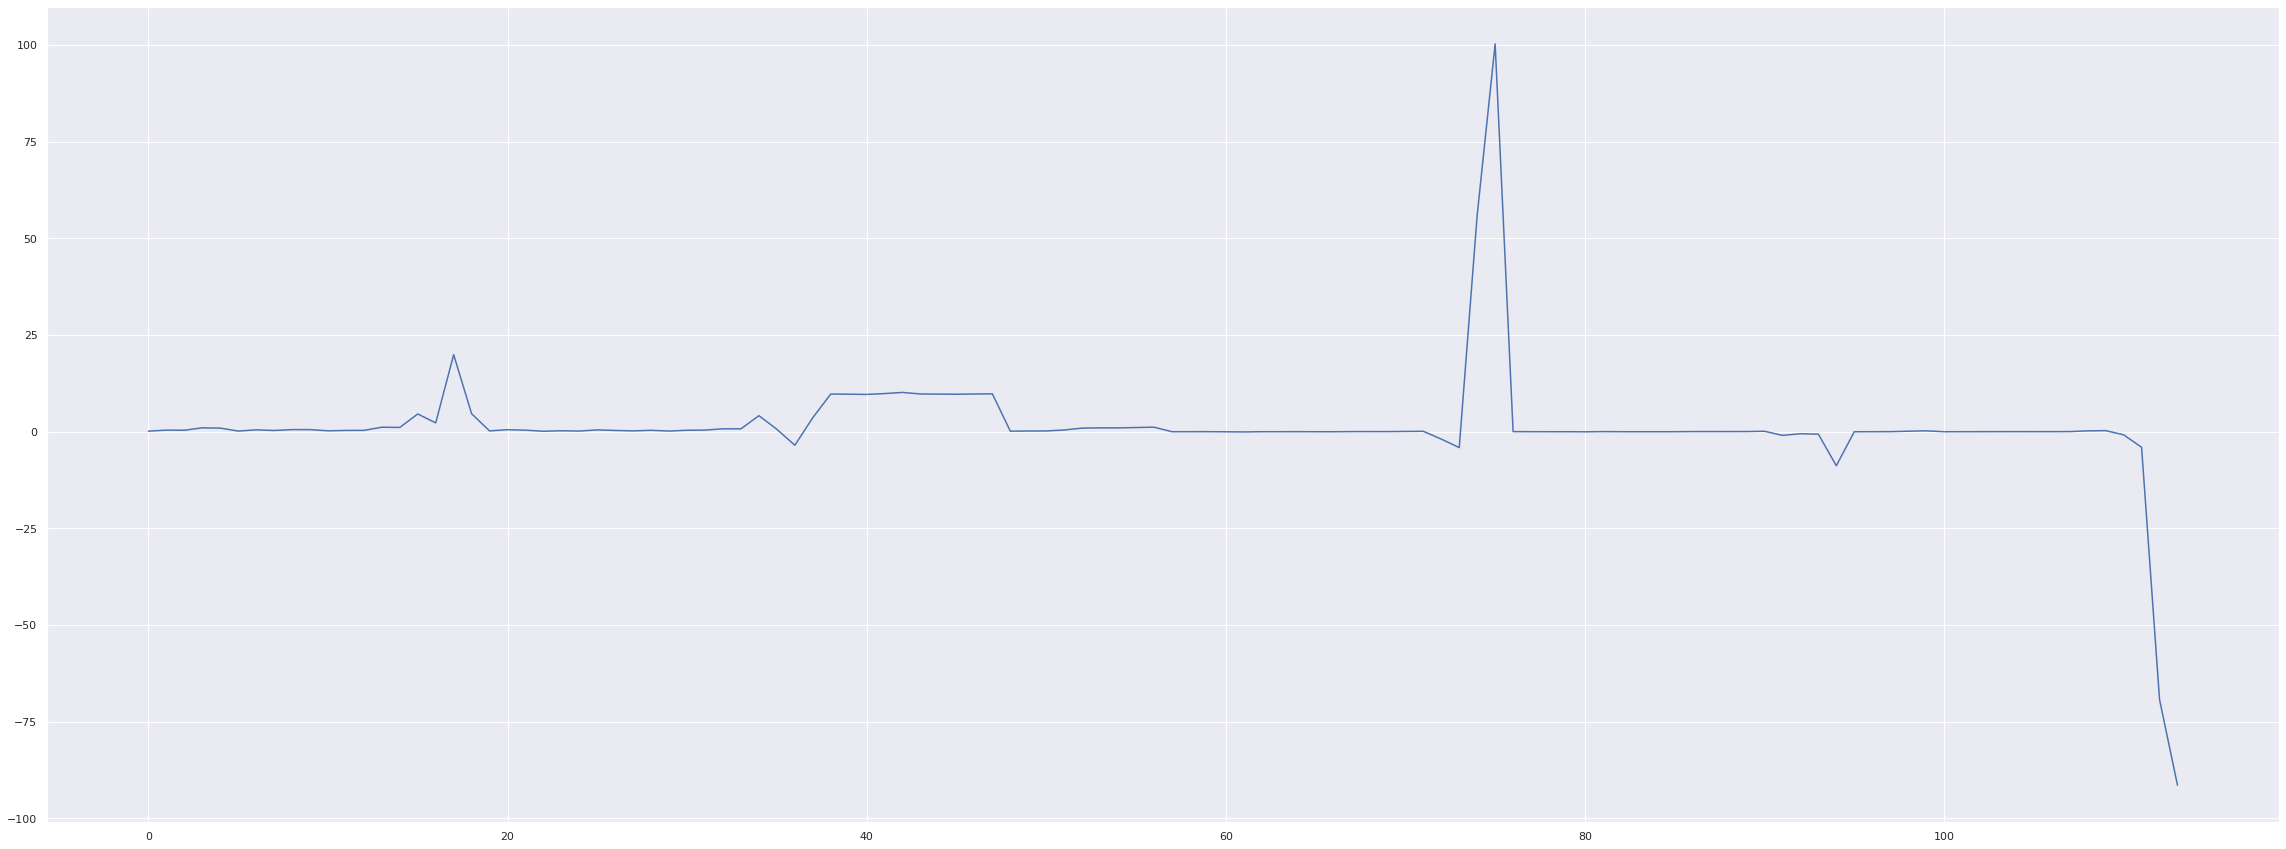

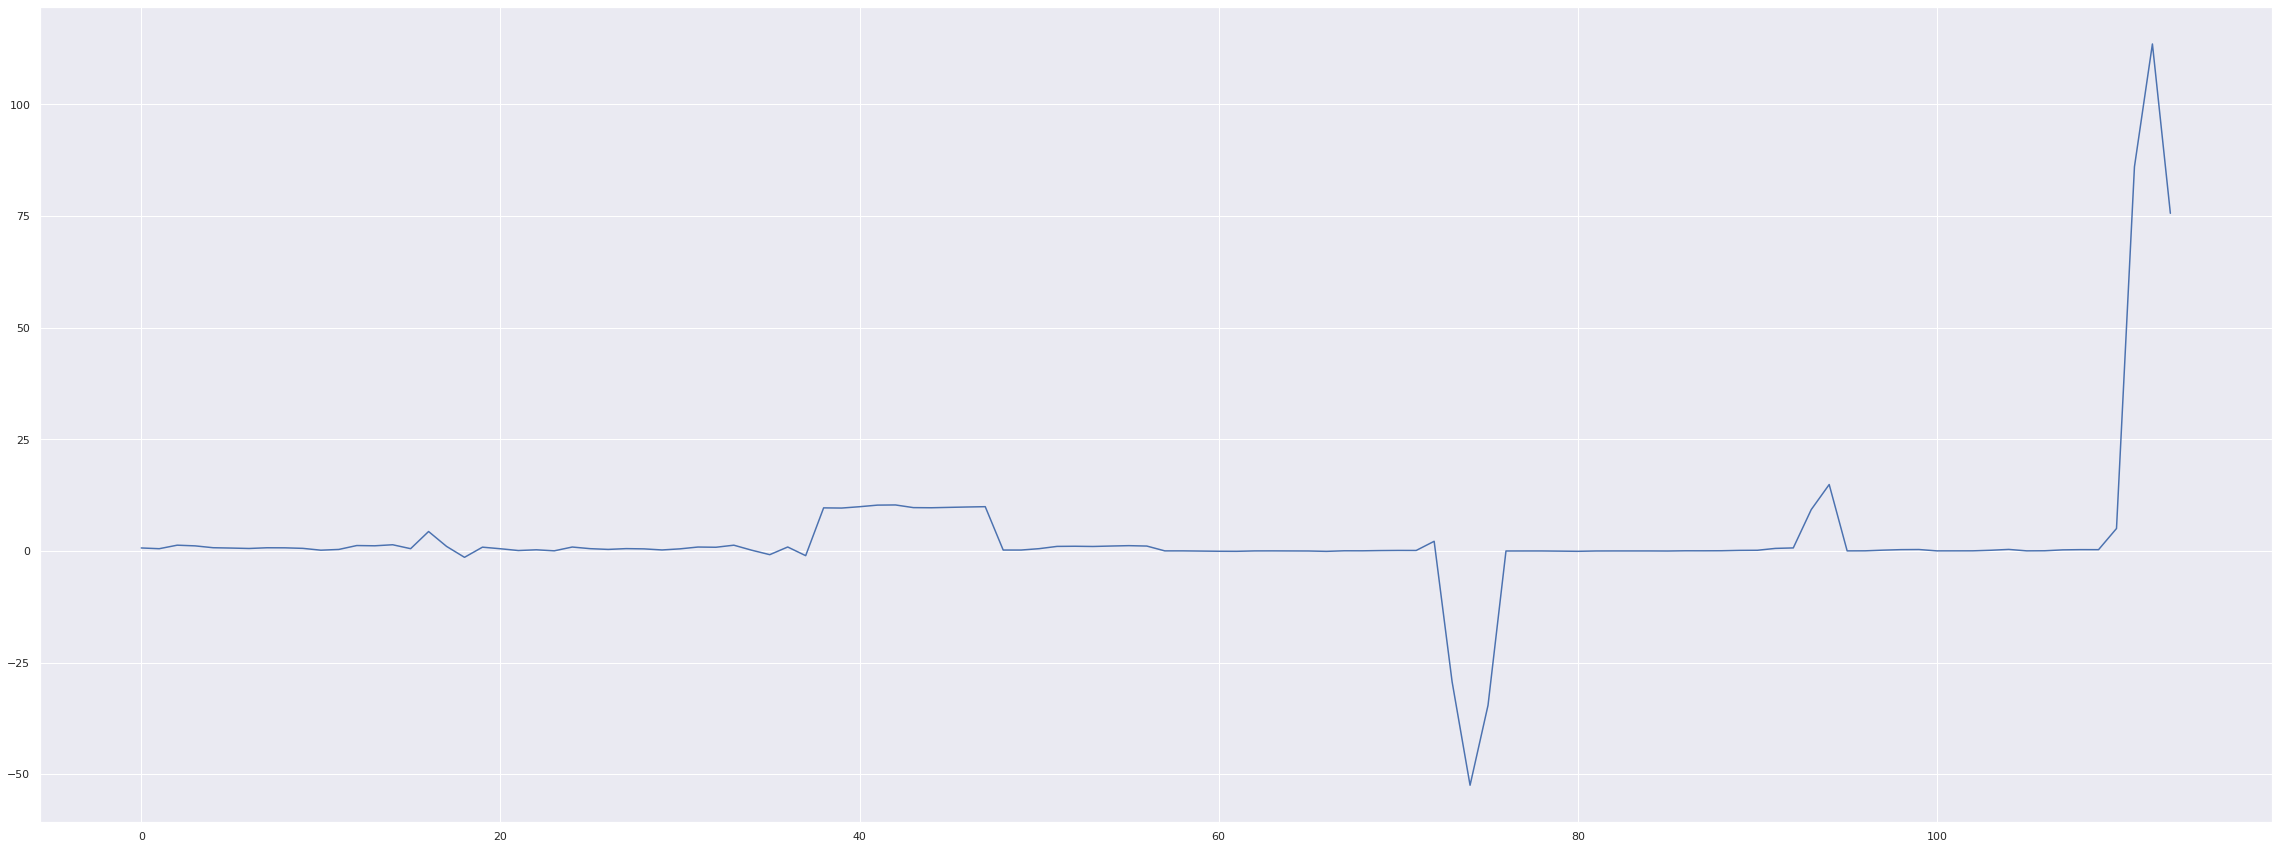

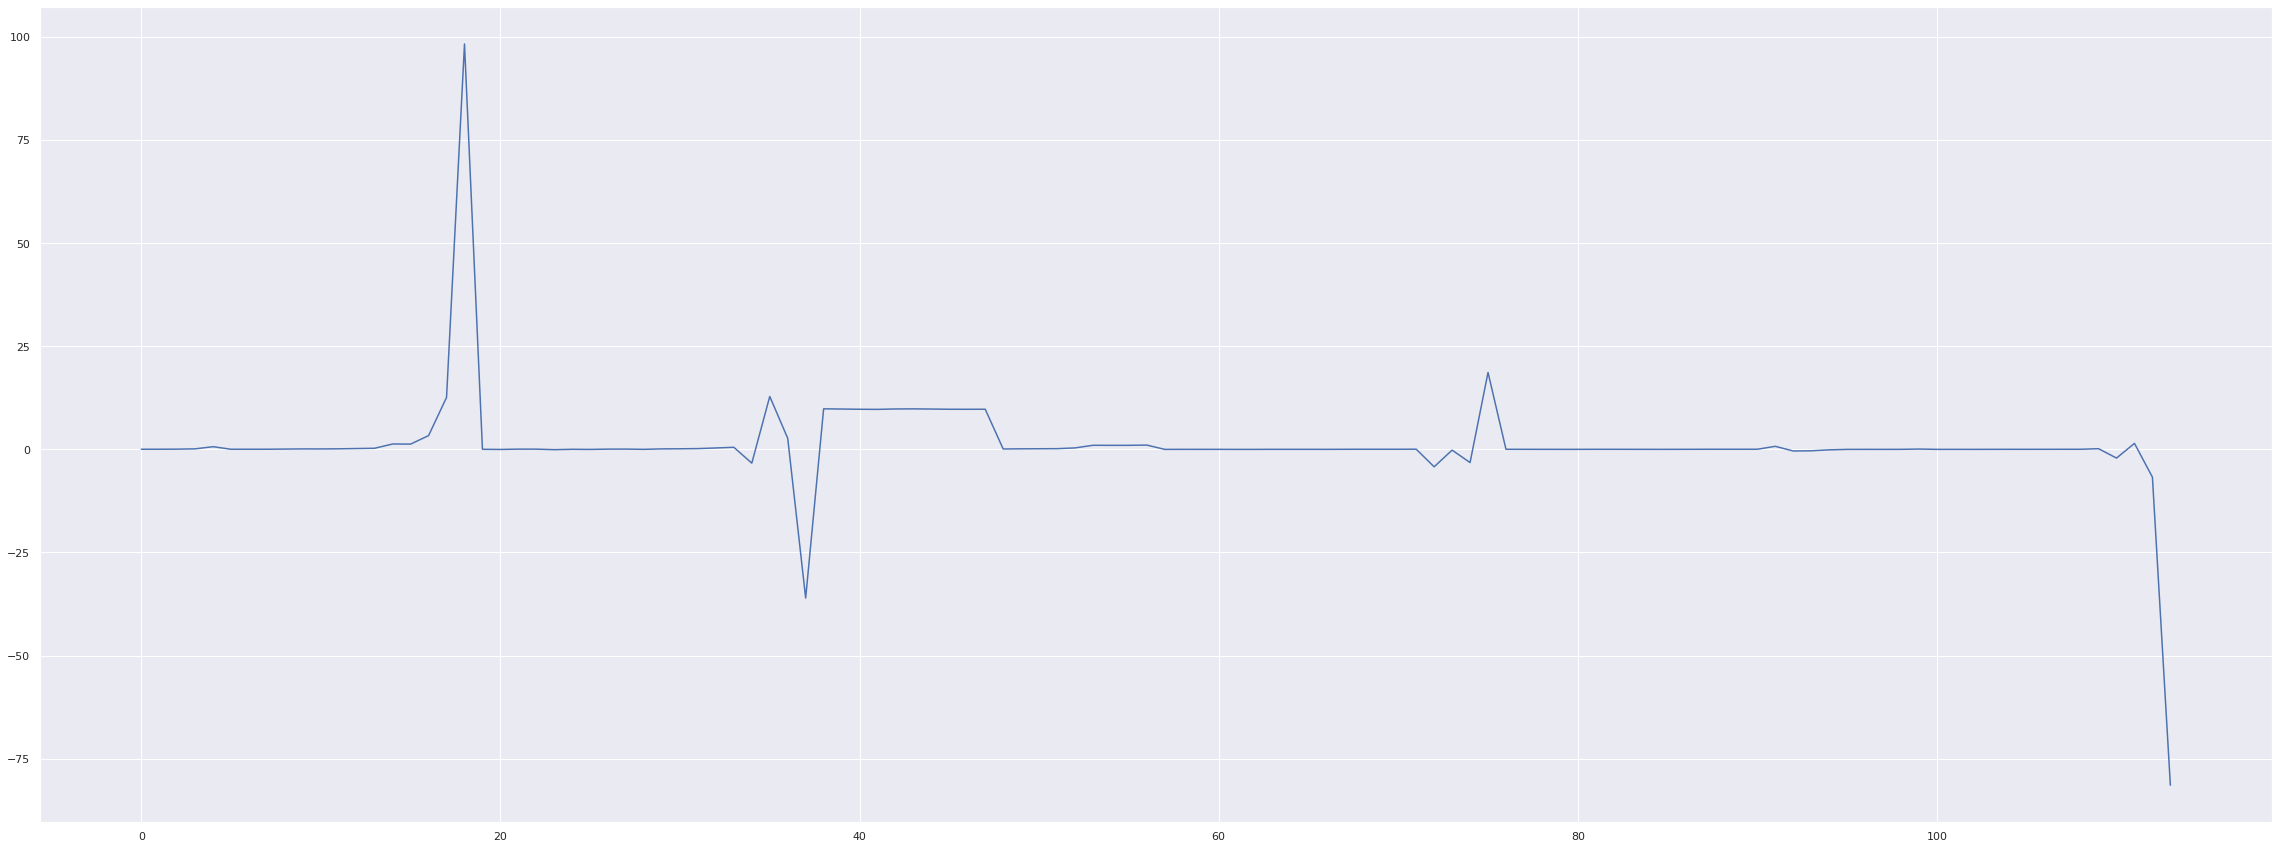

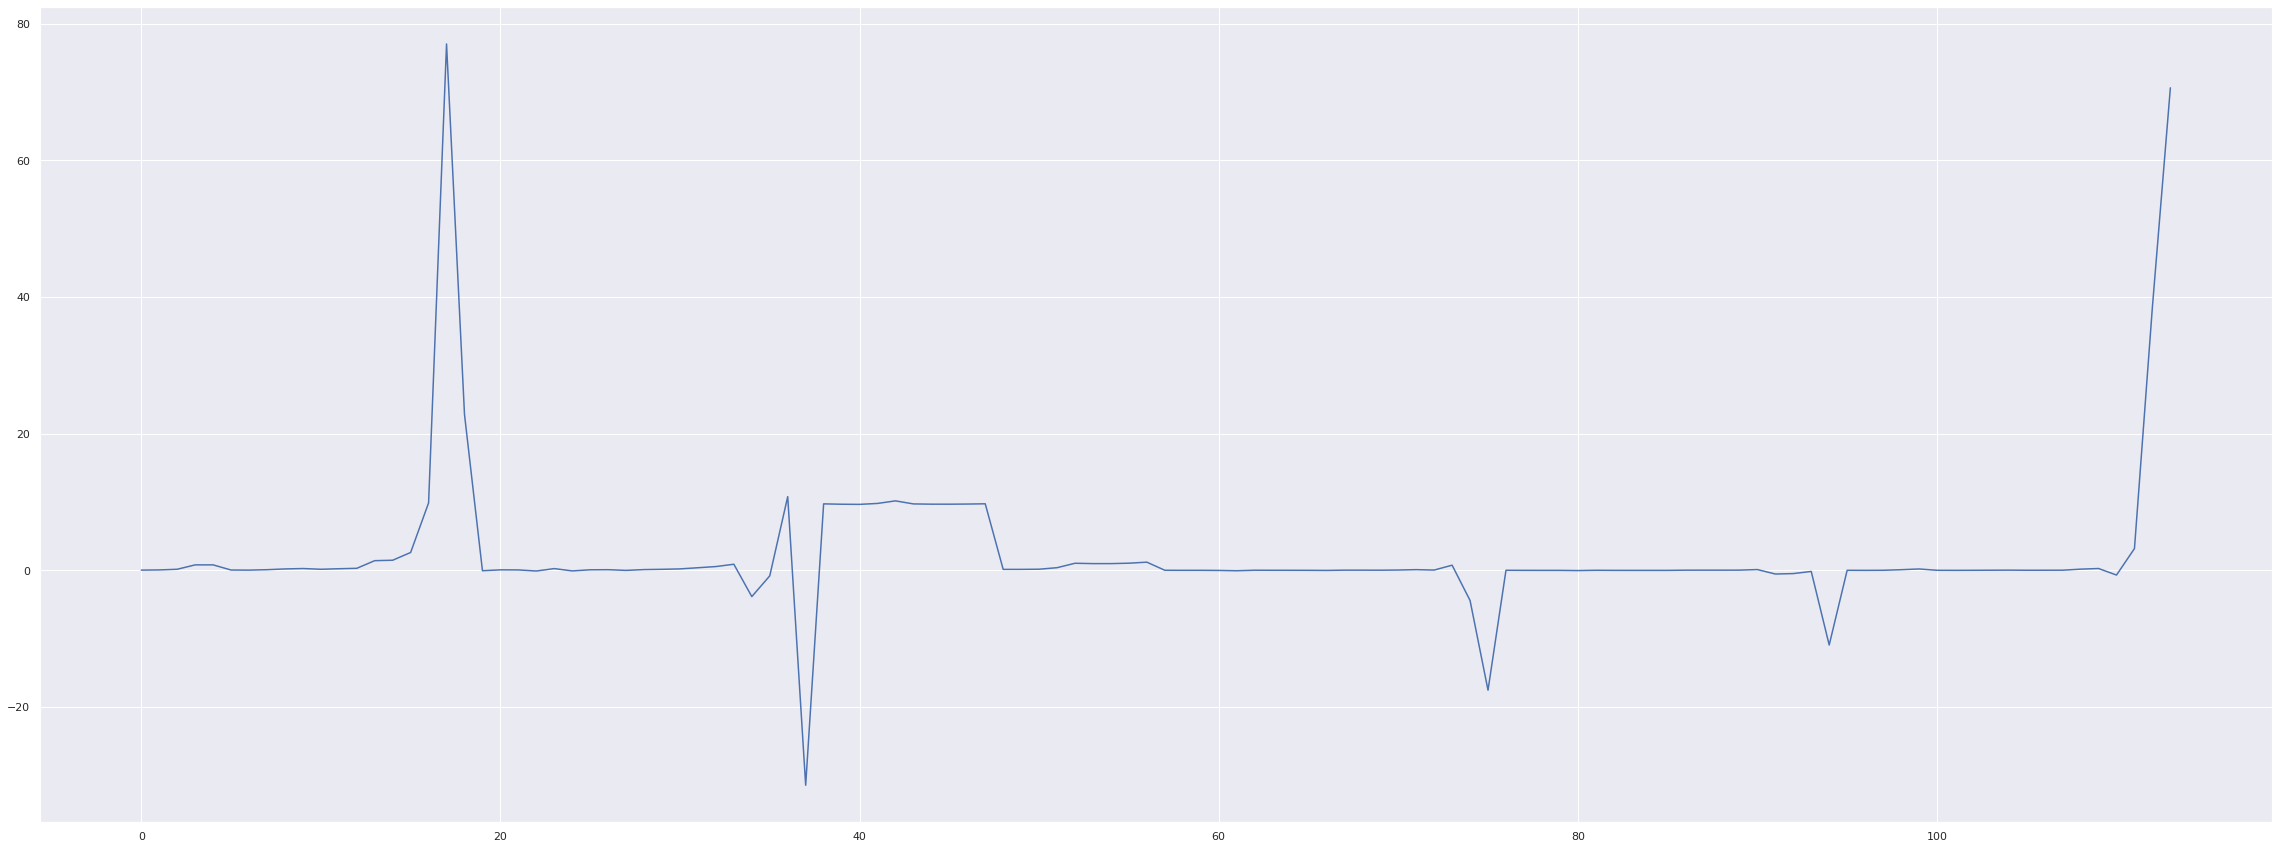

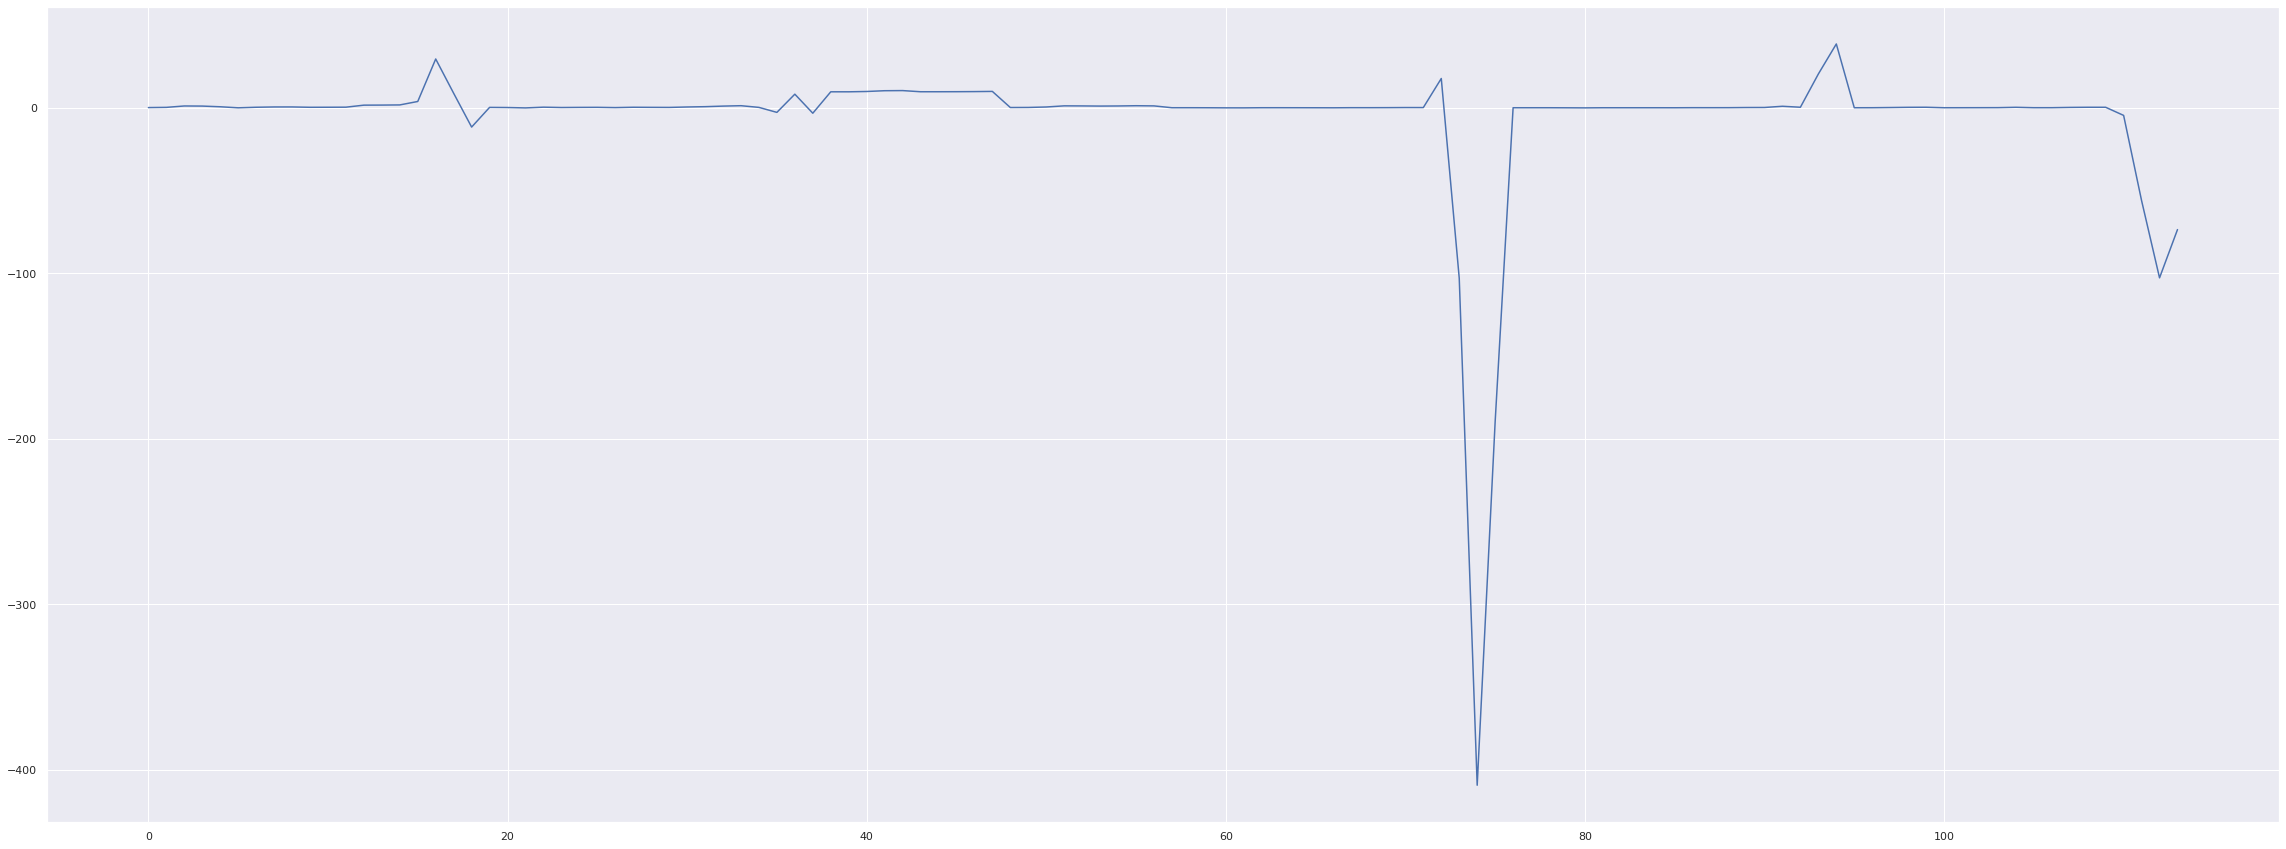

In [ ]:
for i in range(len(pro[(pro["tripid"] == 16) & (pro["maneuver"] == "Aggressive left turn")])):
    plt.plot(pro[(pro["tripid"] == 16) & (pro["maneuver"] == "Aggressive left turn")].iloc[i,3:-1].to_numpy())
    plt.show()


In [ ]:

# def assign_maneuvers(df,truth):
#     """Requires df to be timeseries"""
#     event_no = 0
#     for index, row in truth.iterrows():
#         start = row['Start']
#         finish = row['End']
#         df.loc[((df.index >= start) & (df.index < finish)), 'Event'] = row['Event']
#         df.loc[((df.index >= start) & (df.index < finish)), 'Eventno'] = event_no
#         event_no +=1
#     df["Event"]  = df.Event.fillna("No Maneuver")
#     df["Eventno"]  = df.Eventno.fillna(-1)
def calculate_features(accel,gyro):
    temp = {'timestamp':[],'f1':[],'f2':[],'f3':[],'f4':[], 'f5':[]}
    windows = create_time_segments(gyro,3)
    i = 0

    for key,window in windows.items():

        # calculating Angular Velocity Feature
        f1 = 0
        # for sample in window:
        #     if type(accel.loc[sample]) == "pandas.core.frame.DataFrame":
        #         means = accel.loc[sample].mean()
        #         av = np.sqrt(means.x**2  + means.y**2 + means.z**2)
        #     else:
        #         means = accel.loc[sample]
        #         av = np.sqrt(means.x**2  + means.y**2 + means.z**2)
        #     f1 += av
        # f1 /= 3
        
        # calculating Lateral Acceleration Feature
        f2 = gyro.loc[window].x.apply(lambda x: x**2).var()

        # calculating Longitudinal Acceleration Feature
        f3 = gyro.loc[window].y.apply(lambda x: x**2).var()
        
        # calculating Angle Variation Feature
        f4 = gyro.loc[window].z.apply(lambda x: (x-9.81)**2).var()

        f5 = 0
        for sample in window:
            means = accel.loc[sample].z.mean()
            f5 += means**2
        f5 *= 2

        temp['timestamp'].append(window[0])
        temp['f1'].append(f1)
        temp['f2'].append(f2)
        temp['f3'].append(f3)
        temp['f4'].append(f4)
        temp['f5'].append(f5)

    data = pd.DataFrame.from_dict(temp)
    # ccel.loc[create_time_windows(accel,3)[0]].x.apply(lambda x: x**2).var()
    data = convert_to_timeseries(data)
    # Uncomment to add_labels
    # add_event_label(data,truth)
    return data


turn_color = px.colors.sequential.RdBu
na_color = px.colors.sequential.Teal
colors = {'Aggressive left lane change': turn_color[-4], 'Aggressive left 45-turn': turn_color[-3], 'Aggressive left turn': turn_color[-2], "Aggressive left 180-turn":turn_color[-1], "Aggressive left Overtake": turn_color[-5],
          'Aggressive right lane change': turn_color[3], 'Aggressive right 45-turn':turn_color[2] ,'Aggressive right turn':turn_color[1], "Aggressive right 180-turn": turn_color[0],  "Aggressive right Overtake": turn_color[4],
          'Aggressive acceleration': 'darkviolet', 'Aggressive breaking': 'mediumvioletred', 'Non-aggressive event': na_color[-2],  'No Maneuver': na_color[-2],
          'Aggressive right 90-turn': turn_color[1], 'Aggressive left 90-turn': turn_color[-2]}

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]),int(rgb[1]),int(rgb[2]))

labels = {'Aggressive left lane change': "ll", 'Aggressive left 45-turn': "l45", 'Aggressive left turn': "lt", "Aggressive left 180-turn":"lu", "Aggressive left Overtake": "lo",
          'Aggressive right lane change': "rl", 'Aggressive right 45-turn':"r45" ,'Aggressive right turn':"rt", "Aggressive right 180-turn": "ru",  "Aggressive right Overtake": "ro",
          'Aggressive acceleration': 'a', 'Aggressive breaking': "b", 'Non-aggressive event': "na",  'No Maneuver': "nm",
          'Aggressive right 90-turn': "rt", 'Aggressive left 90-turn': "lt"}


def add_event_label(data,truth):
    event_no = 0
    for index, row in truth.iterrows():
        start = row['Start']
        finish = row['End']
        data.loc[((data.index >= start) & (data.index < finish)), 'Event'] = row['Event']
        data.loc[((data.index >= start) & (data.index < finish)), 'Eventno'] = event_no
        event_no +=1
    data["Event"]  = data.Event.fillna("No Maneuver")
    data["Eventno"]  = data.Eventno.fillna(-1)
    data["color"] = data.Event.apply(lambda x: colors[x])

def get_shape(truth):
    return [dict(
        type="rect",
        # x-reference is assigned to the x-values
        xref="x",
        # y-reference is assigned to the plot paper [0,1]
        yref="paper",
        x0=truth['Start'][i],
        y0=0,
        x1=truth['End'][i],
        # y1=1,
        fillcolor=colors[truth["Event"][i]],
        opacity=0.3,
        layer="below",
    ) for i in truth.index]    


In [ ]:
ac = convert_to_timeseries(temp.accel.smooth().to_dataframe())
gy = convert_to_timeseries(temp.gyro.smooth().to_dataframe())
# add_event_label(ac,temp.events)
# add_event_label(gy,temp.events)

In [ ]:
d1 = calculate_features(ac,gy)

In [ ]:
# calculate_features(convert_to_timeseries(accel1),convert_to_timeseries(gyro1))

In [ ]:
import plotly.graph_objs as go


In [ ]:
ac.loc[seg[2][2]]

In [ ]:
ac[ac.index == seg[2][2]]

In [ ]:
def create_figures(data_list = [], truth = []):
    figures = []
    t= 0
    for data in  data_list:
        fig = data.plot(y = ["f2","f3","f4","f5"])
        fig.update_layout(
            shapes=get_shape(truth[t]))

        # # Create scatter trace of text labels
        # fig.add_trace(go.Scatter(
        # # y =[10+t*7 for i in truth[i].index],
        # x = [truth[t]['Start'][i] for i in truth[t].index],
        # text=[labels[truth[t]["Event"][i]] for i in truth[t].index],
        #     mode="text",

        # ))

        fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                activecolor = "#eefeef",
                buttons=list([
                    dict(count=2, label="2m", step="minute", stepmode="todate"),
                    dict(count=30, label="30s", step="second", stepmode="todate"),

                ])
            )
        )
        figures.append(fig)
        t+=1
    return figures
f = create_figures([d1],[temp.events])
for i in f:
    i.show()

In [ ]:
ggg = (d1 - d1.mean() )/ d1.std()

In [ ]:
d1.describe()

f1            f2            f3          f4          f5
count  446.0  4.460000e+02  4.460000e+02  446.000000  446.000000
mean     0.0  2.238846e-08  2.455194e-07    1.562374  560.715922
std      0.0  7.008363e-08  1.763628e-06    3.991065    9.267695
min      0.0  9.836144e-12  2.895443e-13    0.000413  501.061517
25%      0.0  9.325124e-10  6.778755e-10    0.016888  556.875521
50%      0.0  3.838079e-09  3.216339e-09    0.092821  561.526982
75%      0.0  1.132098e-08  1.357614e-08    1.135217  565.923330
max      0.0  9.531317e-07  3.178877e-05   34.131255  582.108949

In [ ]:
ggg.plot(y = ["f2","f3","f4","f5"])